# Análisis Predictivo de Series Temporales



## Modelos en espacio de estados:

## Modelo lineal dinámico (Dynamic Linear Model)

In [1]:
#install.packages("astsa")
library(astsa) ##Nota: es necesario una versión mayor a la 2.0
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300) #ajusta tamaño de graficas

## Modelos en espacio de estados:

La idea de los modelos en espacio de estados es poder representar procesos que tienen una *dinámica interna*, es decir:

 * Poseen un *estado* $x_t$, que evolucione en el tiempo, y que en general no es observable.
 * Podemos medir uno o más valores $y_t$, denominados *observaciones*, y cuyo comportamiento depende del estado $x_t$ en que se encuentra el proceso.
 
### Problemas:

 * Dadas las observaciones $y_0,\ldots,y_n$, ¿como reconstruimos $x_0,\ldots,x_n$?
 * Dado un conjunto de observaciones $y_0,\ldots,y_n$, ¿cómo ajustamos un modelo a la evolución del estado $x$?
 * ¿Como podemos predecir estados/observaciones futuras?

### Diagrama:

![espacio_estados](../images/statespace.png "Estados y obsevaciones")


### Ejemplos de modelos:

 * Modelos con estados continuos y observaciones continuas (sistemas dinámicos de tiempo discreto con ruido)
     
     * Para ello se estudian herramientas matriciales, en particular el filtro de Kalman.
     * Se aplican en general cuando hay un modelo físico subyacente.
     * Un ejemplo de esto es el **Modelo lineal dinámico**.
     
 * Modelos con estados discretos y observaciones discretas o continuas.
     
     * En este caso una buena técnica es usar Modelos de Markov Escondidos.
     * Los estados representan situaciones en las que se encuentra el sistema que generan respuestas distintas de acuerdo a ellos (ej: lluvioso/seco, símbolo transmitido 0 o 1, etc.)

## Dynamic Linear Model (DLM)

El modelo lineal dinámico es un modelo en espacio de estados que se compone de:

* Un *estado* $x_t$, que puede ser vectorial si el sistema presenta múltiples variables de interés.
* Una *ecuación de evolución* (dinámica lineal) que dice como se genera $x_{t+1}$ a partir de $x_t$ y el *ruido de estado* $w_t$.
* Una *observación* $y_t$, que puede ser vectorial si tenemos múltiples medidas del sistema relacionadas entre sí.
* Una *ecuación de observación* (lineal) que indica cómo se calculan las las observaciones a partir de $x_t$ y el *ruido de observación* $v_t$.

### Ejemplo: Calentamiento global

Volvamos a analizar la serie `globtemp` de la biblioteca:

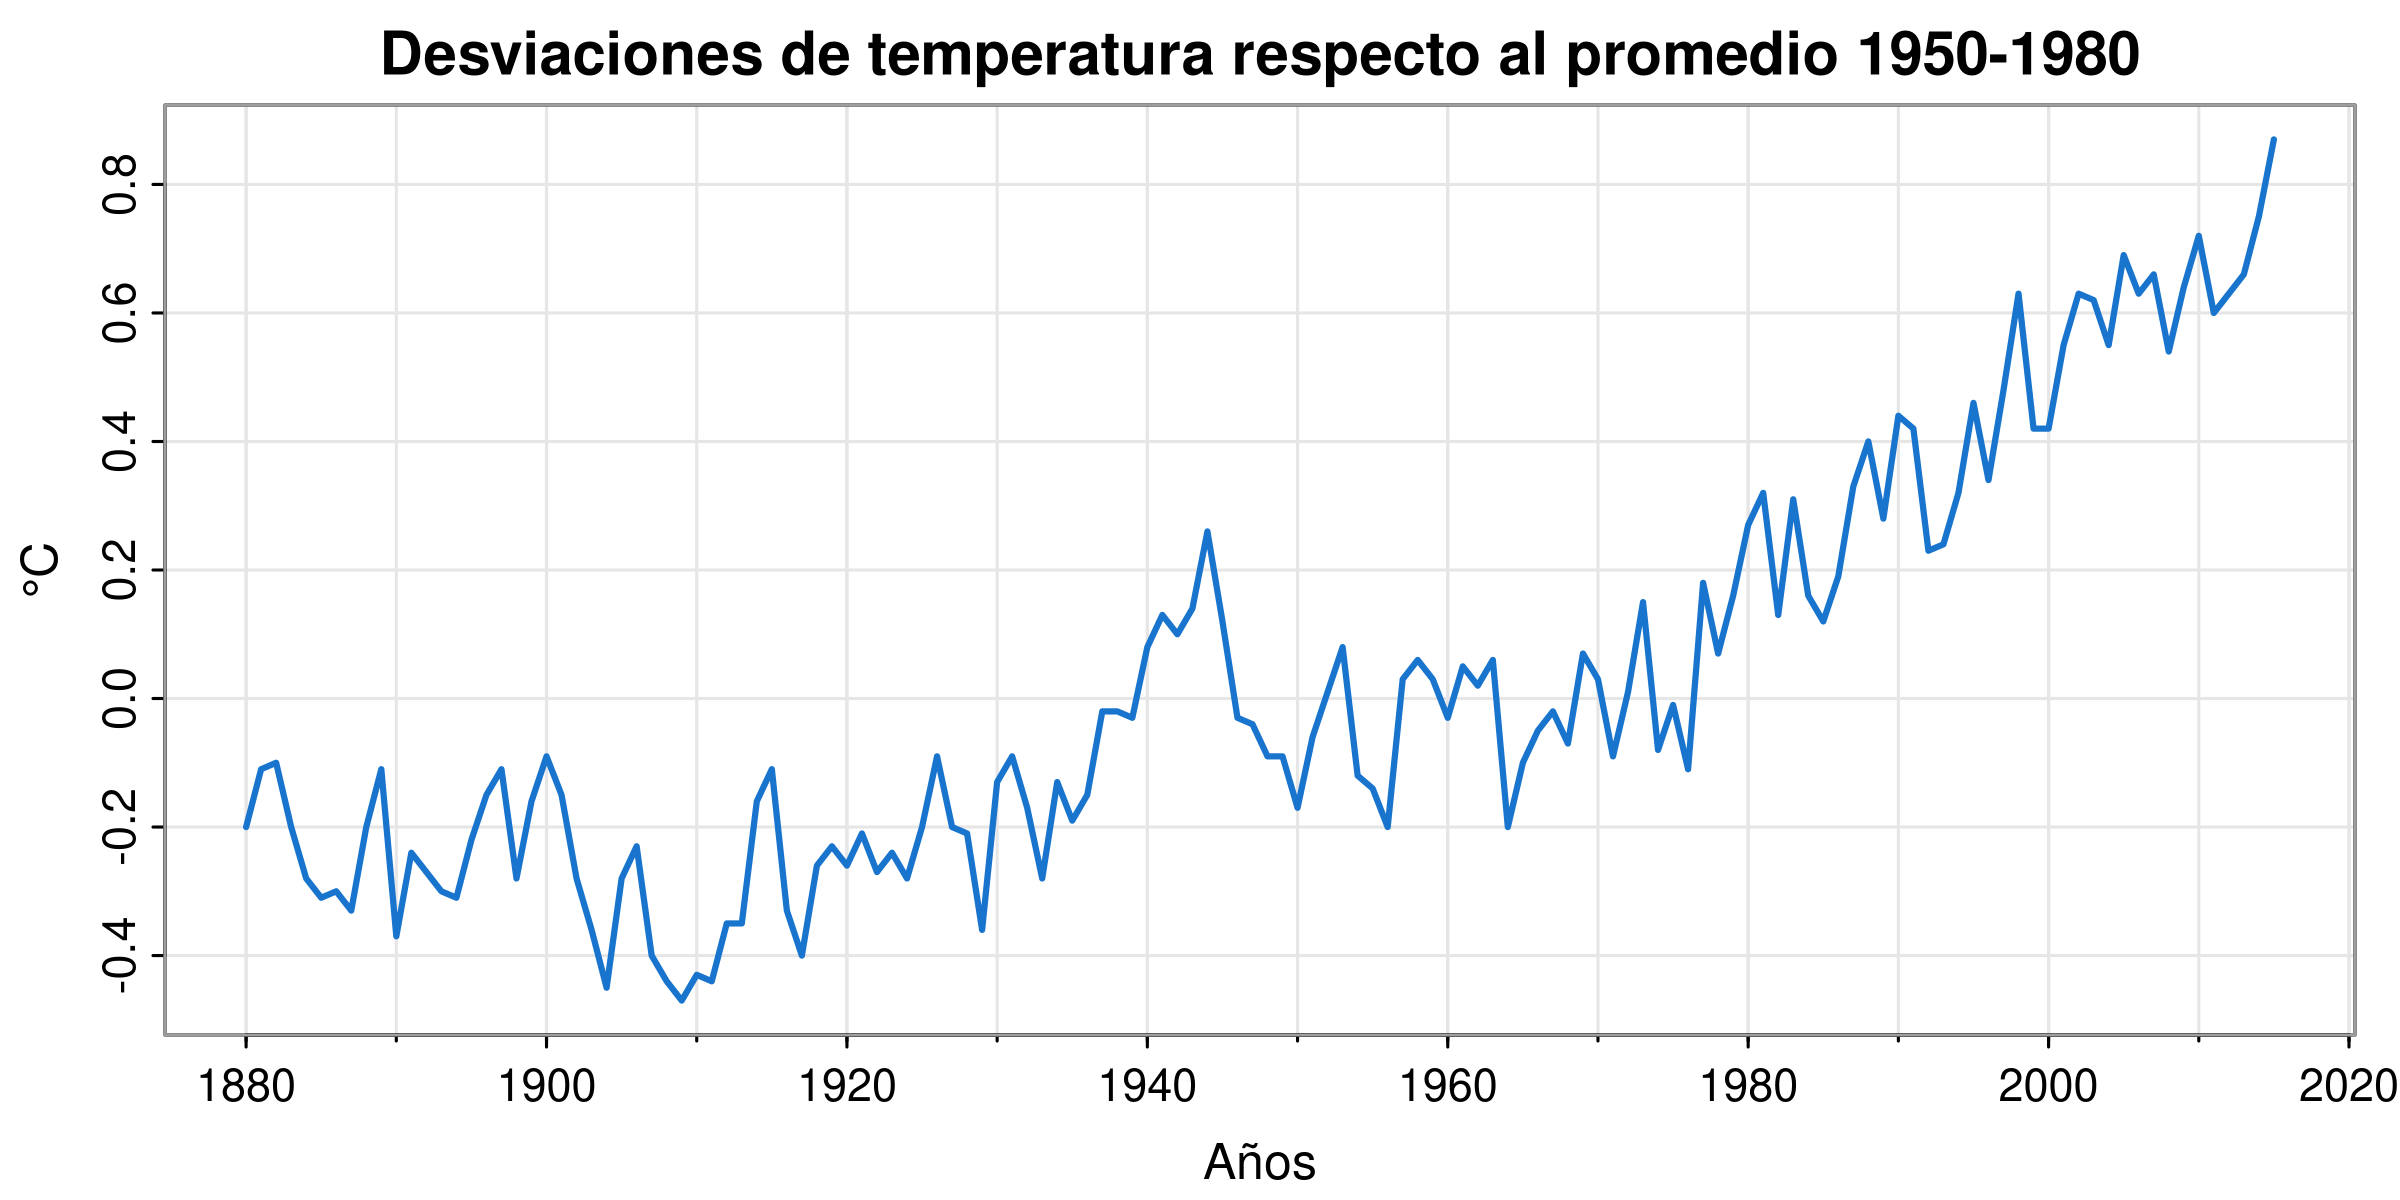

In [2]:
tsplot(globtemp, lwd=2, col=4, 
       main="Desviaciones de temperatura respecto al promedio 1950-1980", 
       xlab="Años", ylab="°C")

### Estado y observación:

   * La serie presenta una evolución temporal *lenta* correspondiente a la temperatura media.
   * Pero presenta variaciones anuales *rápidas* de mayor varianza producto de la observación.
  
#### Modelo:

   * Sea $x_t$ la tendencia central de la temperatura e $y_t$ la temperatura real medida.
   * Propongamos un modelo de la forma:
    
   $$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_{t} = ax_t + v_t, \end{cases}$$
   
   con $\phi$ y $a$ parámetros a ajustar, $w_t$ y $v_t$ ruido blanco de varianzas $\sigma_w^2$ y $\sigma_v^2$, también a ajustar.

### Problemas para la estimación:

Tenemos $4$ parámetros a ajustar: $\phi$, $a$, $\sigma_w^2$ y $\sigma_v^2$. Si **supiéramos la secuencia** de estados $x_t$, entonces:

 * La ecuación de $x_t$ es un AR(1) de parámetros $\phi$ y $\sigma_w^2$. Se podría ajustar como vimos anteriormente.
 * $y_t-x_t = v_t$ por lo que dicho residuo debería ser ruido blanco de varianza $\sigma_v^2$ que podríamos estimar.
 
 
> **Problema:**
>
>Solo conocemos $y_t$. ¿Cómo podemos reconstruir el valor "más probable" de $x_t$ a partir de estos datos?

## Estimación de estados

Un primer problema entonces es, dados:

* Un modelo conocido de estado-observación como el anterior.
* un conjunto de observaciones $\{y_1,\ldots,y_s\} = y^s$ hasta tiempo $s$, 

como estimar el valor de $x_t$ subyacente.


**Notación:**

* Si $t=s$ el problema se llama *filtrado* (filtering), es decir recuperar el *estado actual* con las observaciones hasta ahora.
* Si $t<s$, el problema se llama *suavizado* (smoothing) porque puedo usar información del futuro para recuperar el estado.
* Si $t>s$, tenemos el problema de *predicción*.

La solución a este problema es el **filtro de Kalman** o el **suavizador de Kalman**, según el caso.


### Filtro de Kalman

Comencemos con el caso $s=t$, en este caso queremos hallar el mejor estimador de $x_t$ usando $y_1,\ldots,y_t$. El mejor estimador en términos de error cuadrático medio es:

$$x_t^t = E[x_t \mid y^t]$$

y la varianza del error de estimación está dada por:

$$P^t_{t} = E\left[(x_{t}-x_{t}^t)^2\right].$$

En el caso Gaussiano, este estimador se puede hallar mediante una recursión denominada *filtro de Kalman*, que veremos a continuación para el modelo unidimensional anterior.


### Filtro de Kalman: modelo

Supongamos un modelo de la forma:

$$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_t = ax_t + v_t \end{cases}$$

Con $\phi$ y $a$ dados, así como las varianzas de los ruidos $\sigma_w^2$ y $\sigma_v^2$. Supongamos que el proceso comienza en una condición inicial $x_0$ con distribución $N(\mu_0,\sigma_0^2)$.

El proceso se descompone en dos pasos, que luego se aplican de forma recursiva:

 * Conociendo la estimación $x_{t-1}^{t-1}$, realizo la *predicción a un paso* $x_{t}^{t-1}$ y estimo su varianza $P_{t}^{t-1}$.
 * Con la observación $y_t$, calculo la *diferencia* entre lo observado y lo que esperaba observar de acuerdo a la predicción realizada.
 * Se realiza la corrección de $x_{t}^{t-1}$ ponderando el error anterior por la *ganancia de Kalman* (el coeficiente adecuado), calculando $x_t^t$ y $P_t^t$.

### Filtro de Kalman, algoritmo.

Dado un modelo en espacio de estados como los anteriores, con condición inicial $N(\mu_0,\Sigma_0)$ realizamos la siguiente iteración:

1. Se fija $x_0^0 = \mu_0$ y $P_0^0 = \sigma_0^2$ es decir la estimación inicial corresponde a la media y varianza de la condición inicial.

2. Se actualiza la predicción del estado siguiente usando la info hasta $t-1$ y su error:

    $$\begin{align} x_t^{t-1} &= \phi x_{t-1}^{t-1} \\    
     P_{t}^{t-1} &= \phi^2 P_{t-1}^{t-1} + \sigma_w^2. \end{align}$$
    
    
3. Considero la nueva información $y_t$ y calculo la *innovación* o error de predicción:

    $$\epsilon_t = y_t - ax_t^{t-1}$$
       
4. *Corrijo la estimación* y construyo la nueva:
    $$\begin{align}x_t^t &= x_t^{t-1} + K_t (y_t - ax_t^{t-1}), \\
               P_{t}^{t} &= [1-K_ta] P_{t}^{t-1},\end{align}$$
    siendo
    
    $$ K_t = \frac{P_t^{t-1}a}{a^2P_t^{t-1} + \sigma_v^2}$$ 
    la *ganancia de Kalman*.

### Ejemplo (local level model):

Tomemos un modelo *conocido* y apliquemos el procedimiento anterior. Para ello, consideremos el llamado *local level model*:

$$\begin{cases} x_{t+1} = x_t + w_t, \\ y_t = x_t + v_t. \end{cases}$$

Es decir, tomemos $\phi=1$, $a=1$ y el estado es entonces un paseo al azar con ruido de varianza $\sigma_w^2$. Pero éste es medido a través de un ruido de varianza $\sigma_v^2$.

**Observación:** si $\sigma_w^2\ll \sigma_v^2$, tenemos un paseo al azar que se mueve *lentamente* pero que observamos con mucho ruido. Sirve para extraer tendencias centrales. El filtro debería *promediar* las observaciones cercanas para eliminar el ruido de observación y recuperar el estado.

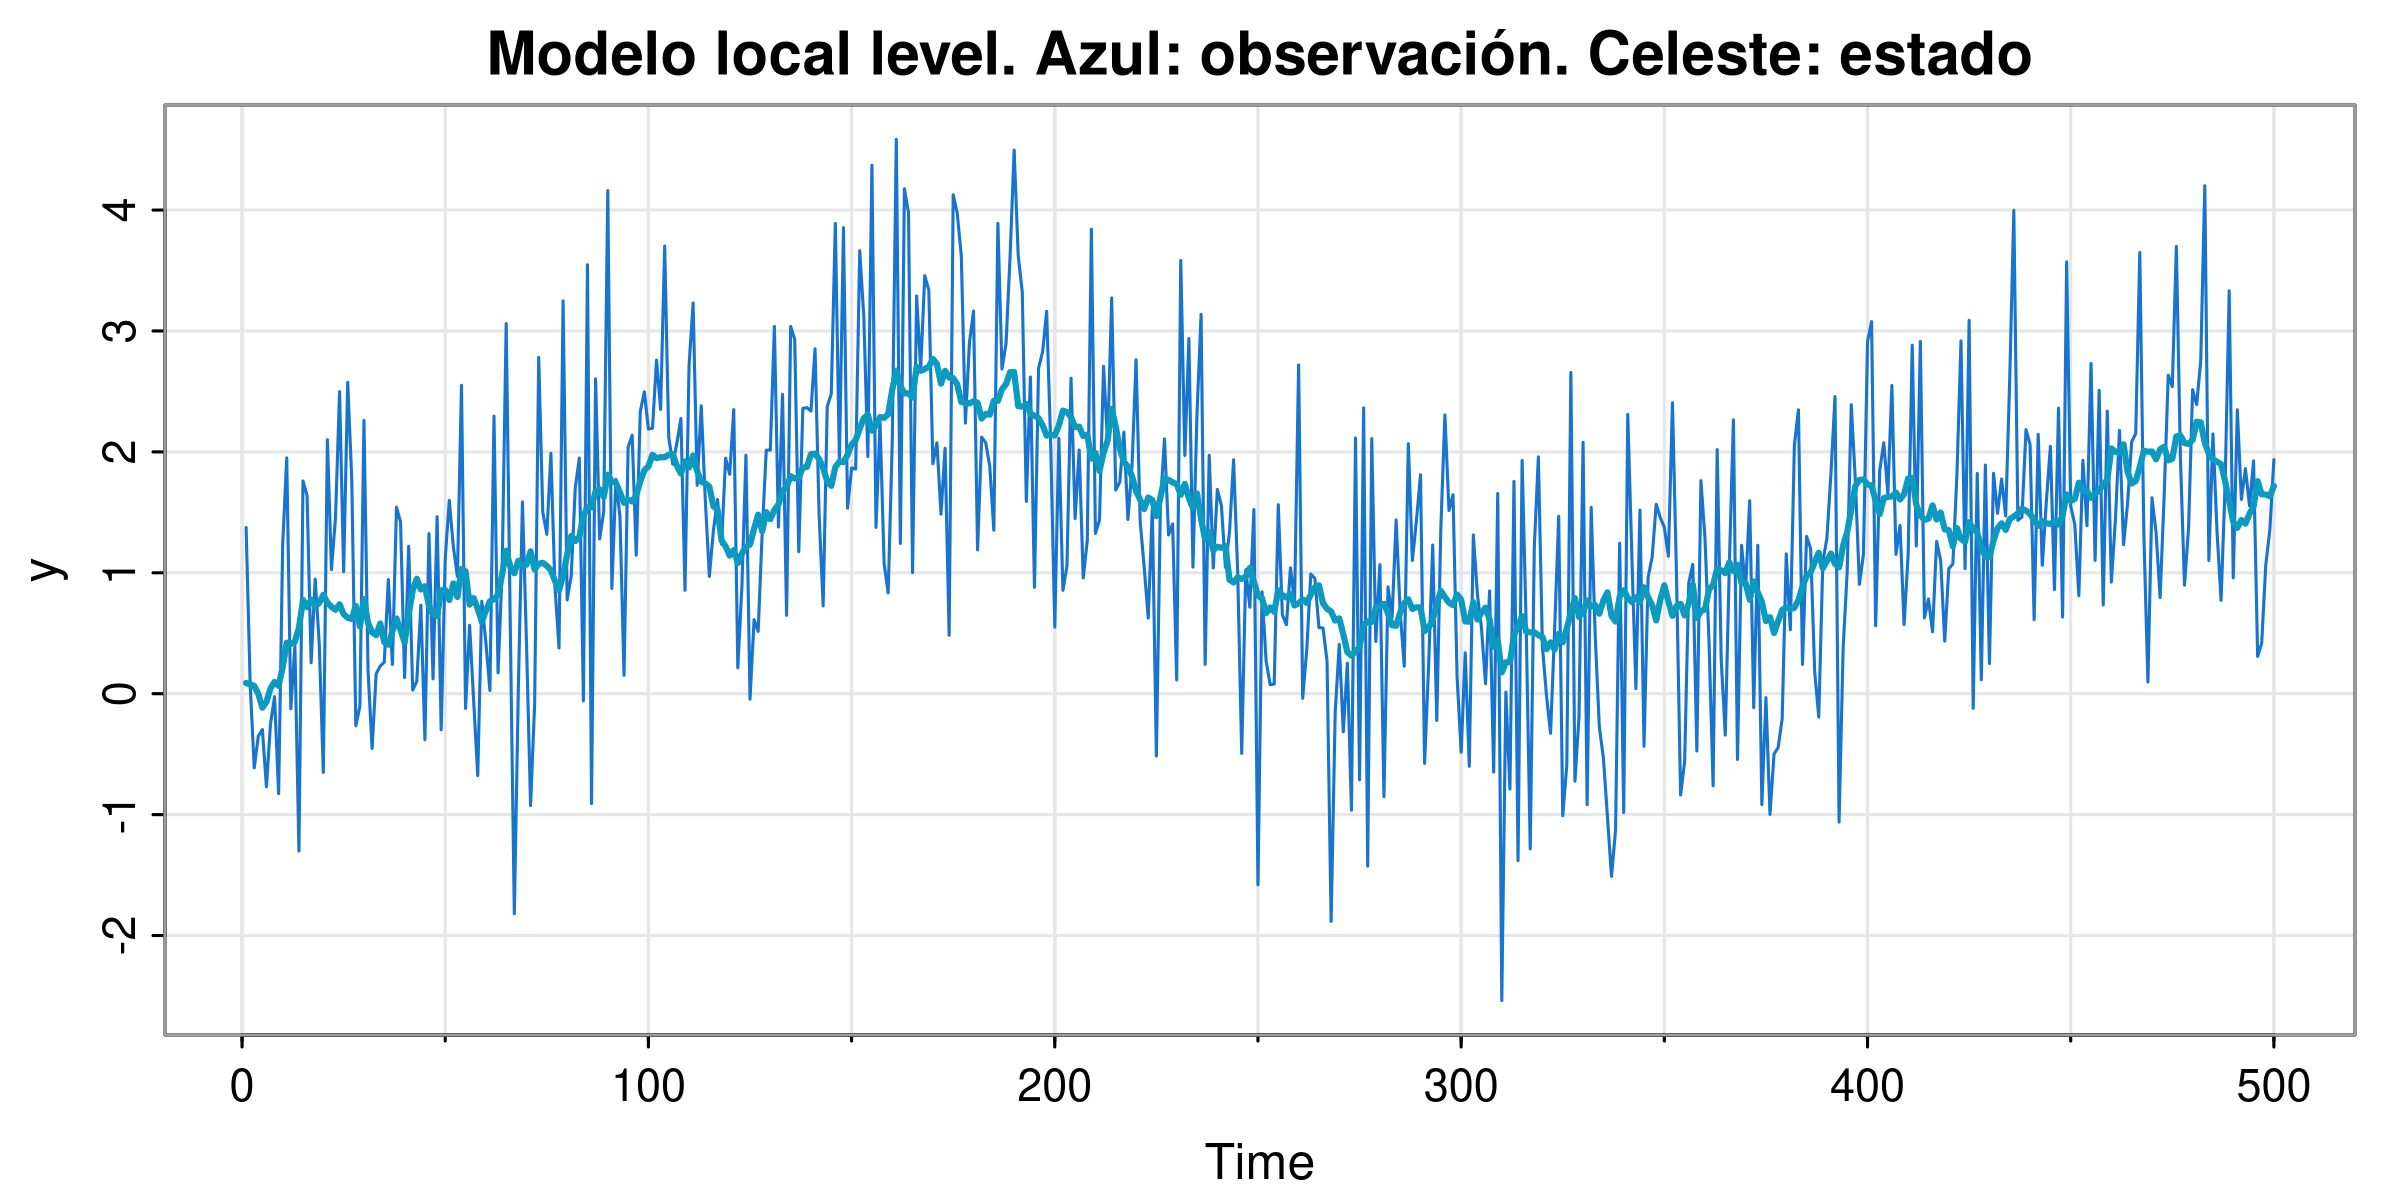

In [3]:
n=500 #cant de observaciones
sigmaw = 0.1
sigmav = 1
w=rnorm(n,0,sigmaw) #ruido blanco
x = cumsum(w) #genero el x acumulando los ruidos.
v=rnorm(n,0,sigmav)
y=x+v #genero la observación

tsplot(y, lwd=1, col=4, main="Modelo local level. Azul: observación. Celeste: estado")
lines(x, lwd=2, col=5)


### Aplicación del filtro de Kalman

Como conocemos los parámetros, podemos aplicar el filtrado usando `Kfilter` de la biblioteca `astsa`:

In [4]:
# Filtrado: trato de reconstruir el valor actual de x a partir de la historia pasada de y hasta el valor actual.

# Los parámetros son:
#  * y: serie de observaciones
#  * Phi: parámetro de la ecuación de estado.
#  * A: parámetro de la ecuación de observación
#  * mu0: estimación de la media de la condición inicial.
#  * Sigma0: error de estimación de la condición inicial.
#  * sQ: desvío de ruido de estado
#  * sR: desvío de ruido de observación

kf = Kfilter(y, Phi=1, A=1, mu0=0, Sigma0=.1, sQ=sigmaw, sR=sigmav)
xfilter = as.numeric(kf$Xf) #lo paso a numerico porque si no da problemas

En el objeto `kf` queda guardado el resultado del filtro en `kf$Xf`, entre otras cosas.

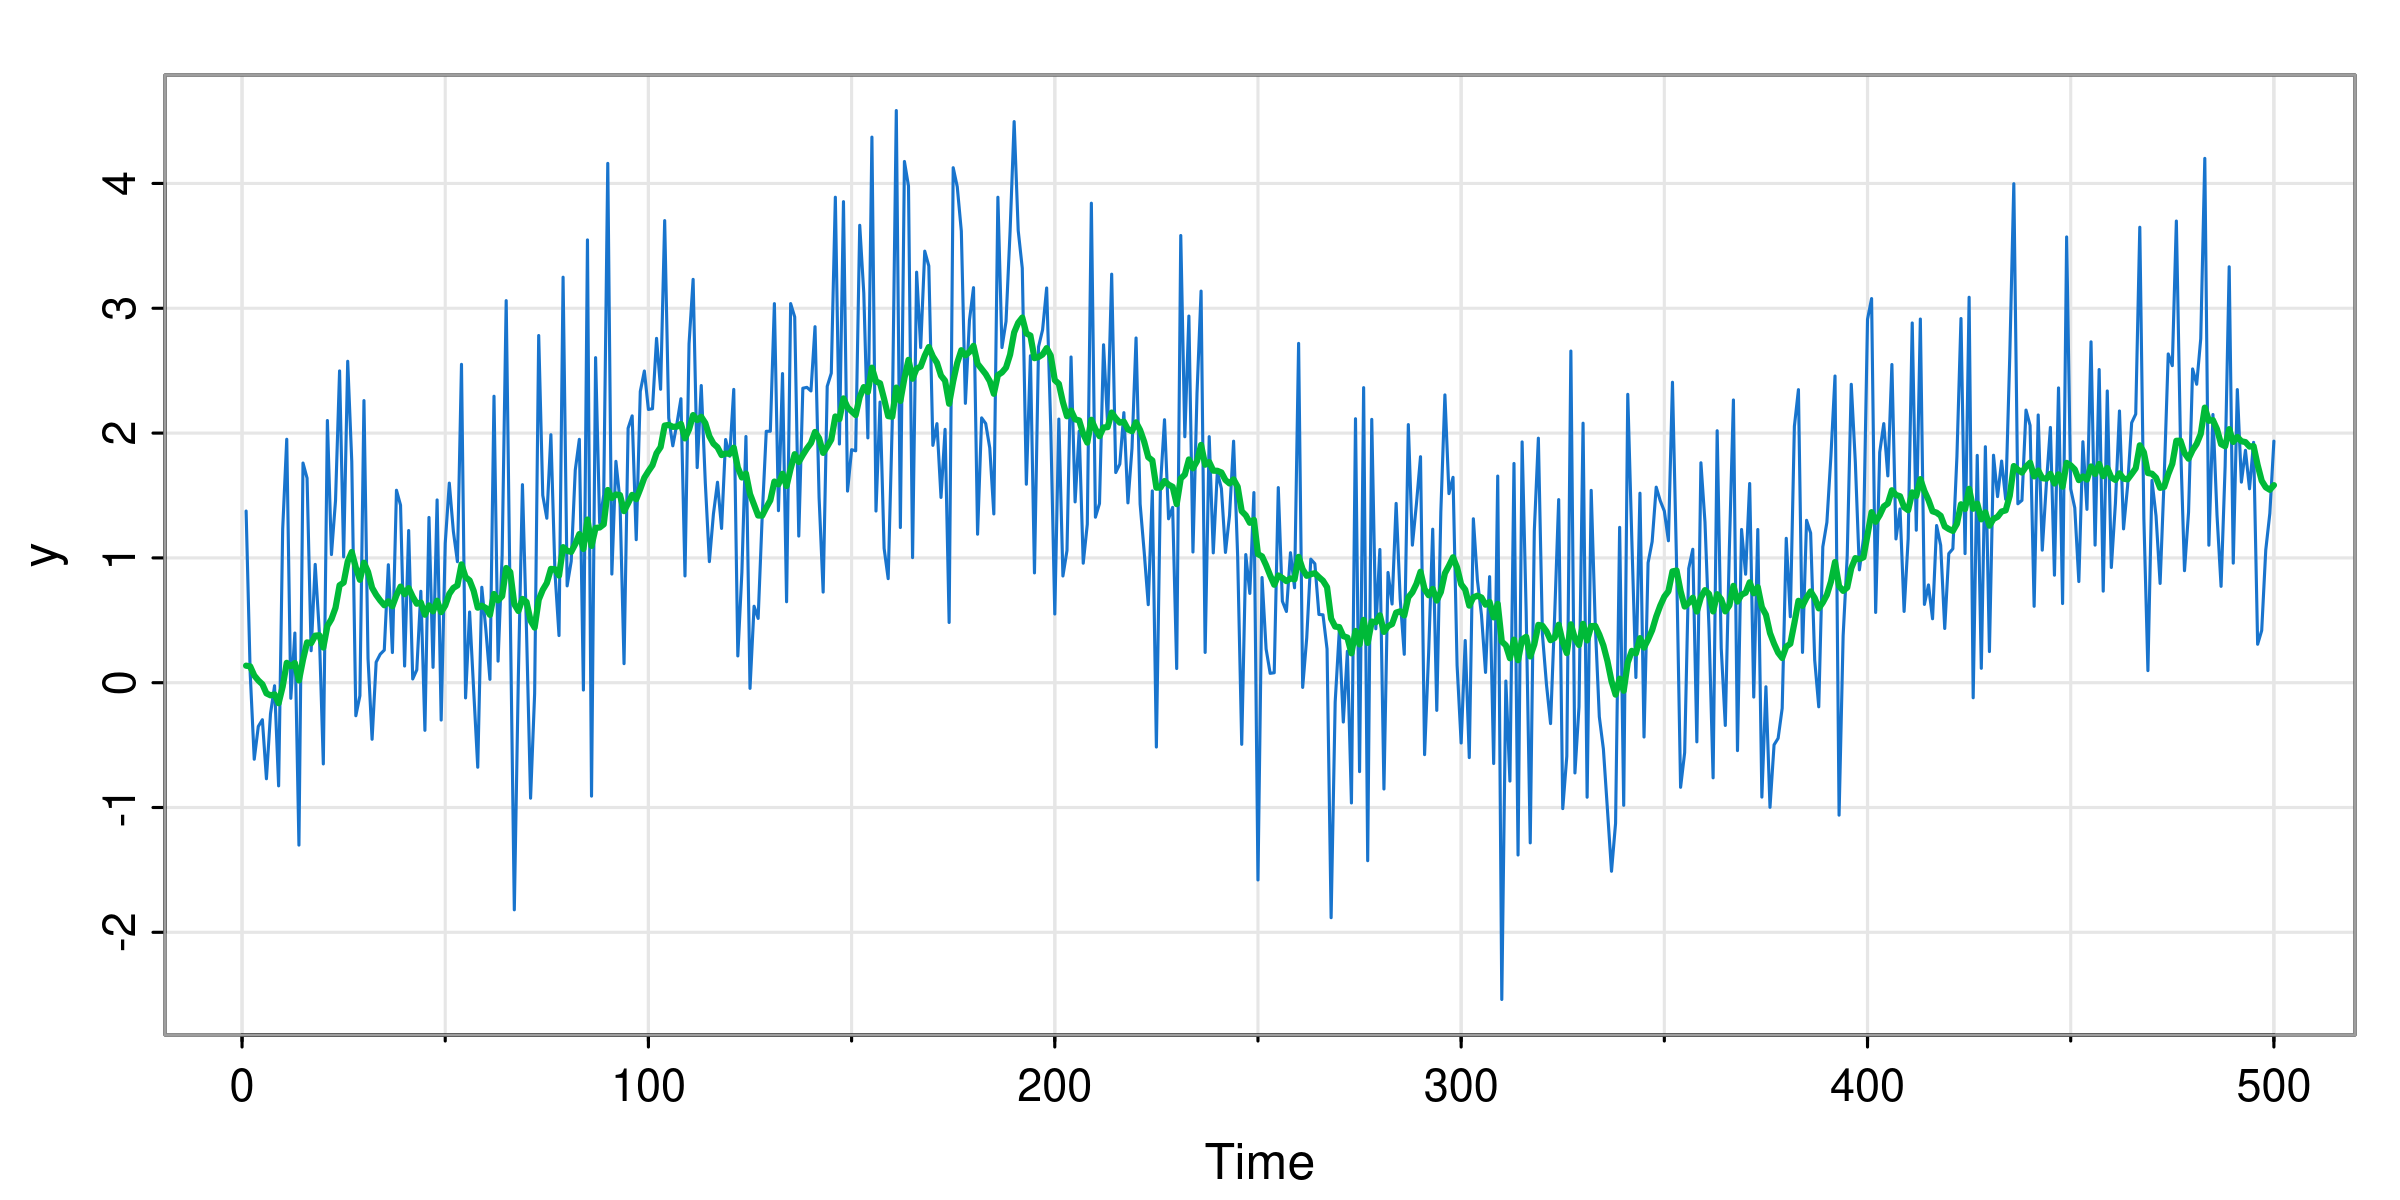

In [5]:
tsplot(y, col=4)
lines(xfilter, lwd=2, col=3)

### Error de filtrado

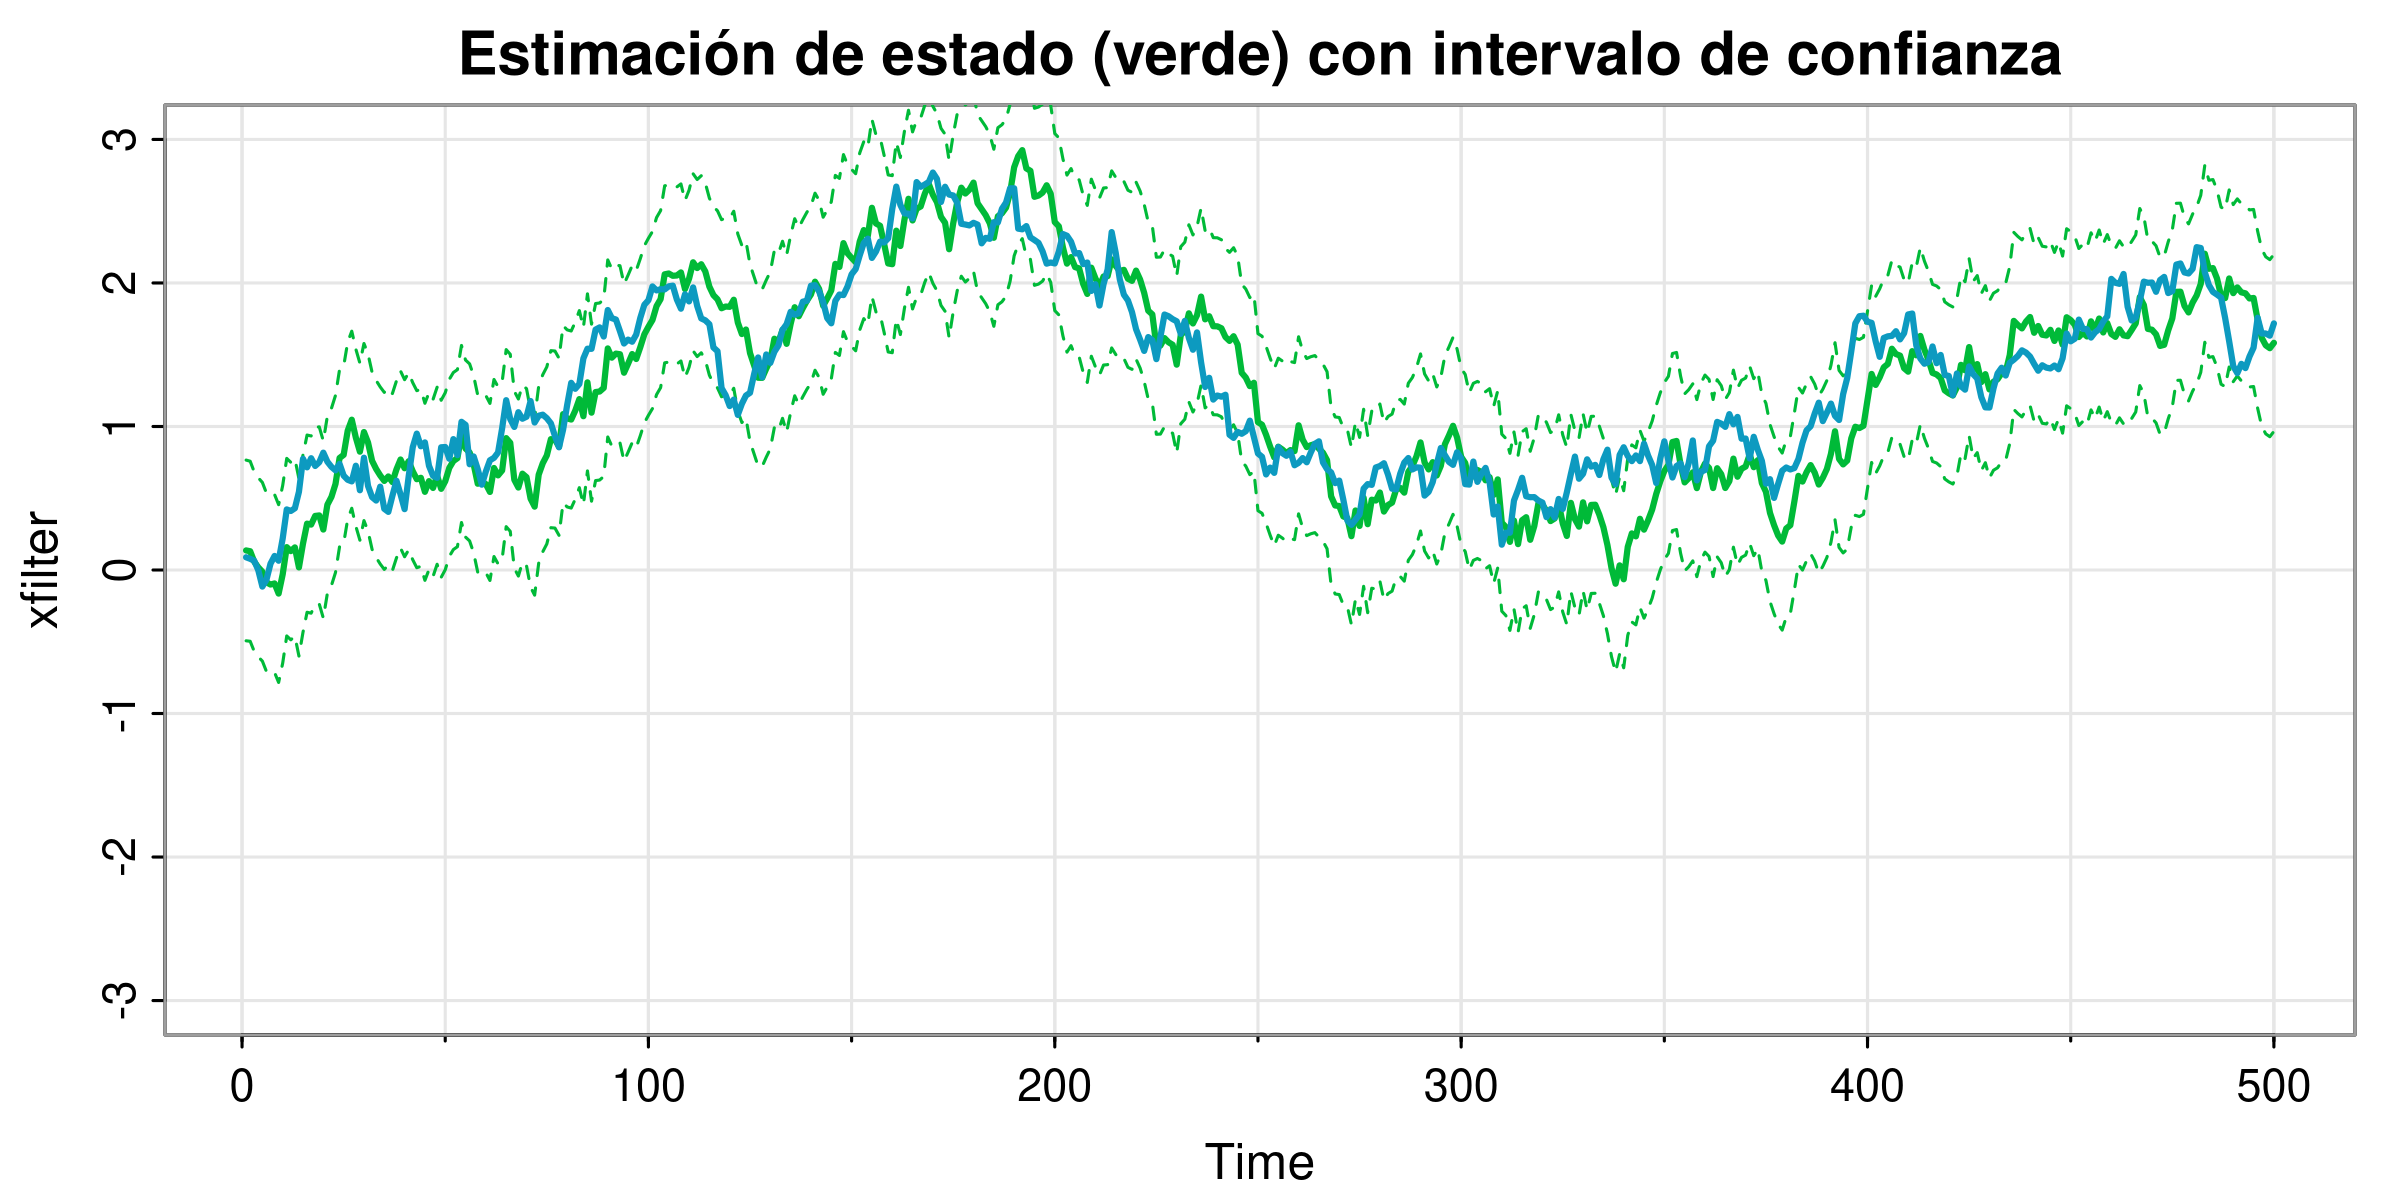

In [6]:
tsplot(xfilter, ylim=c(-3,3), lwd=2, col=3, main="Estimación de estado (verde) con intervalo de confianza")
lines(xfilter + 2*sqrt(kf$Pf), col=3, lty=2)
lines(xfilter - 2*sqrt(kf$Pf), col=3, lty=2)
lines(x, col=5, lwd=2)

### Análisis de residuos

Primero veamos el tamaño del error de estimación:

[1] "RMSE estimación:  0.273330655422117"


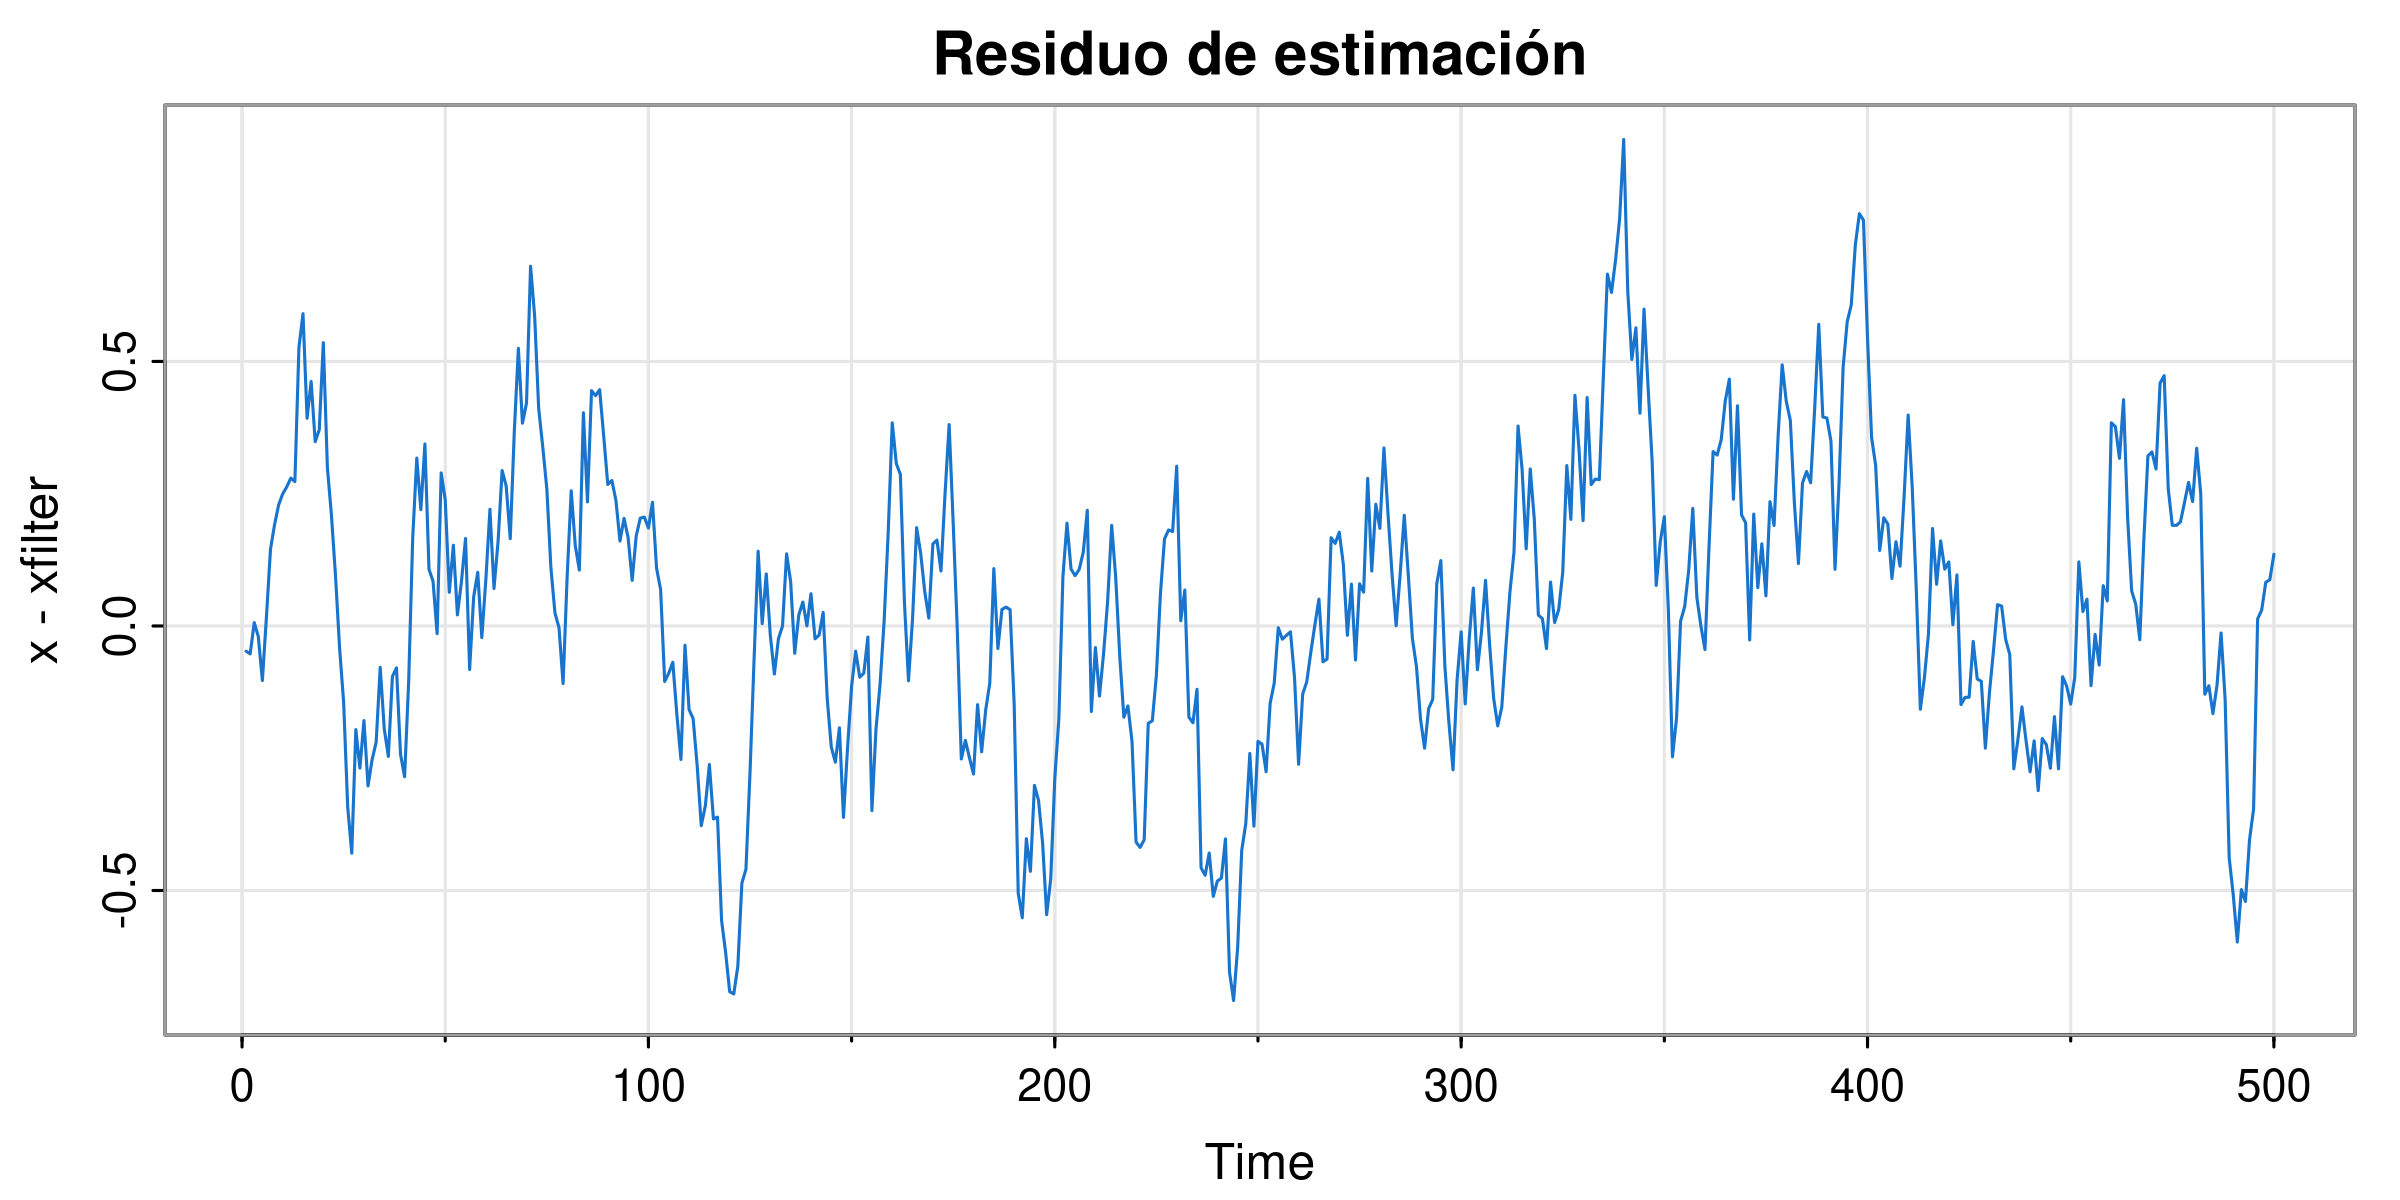

In [7]:
print(paste("RMSE estimación: ",sd(xfilter-x)))
tsplot(x-xfilter, main="Residuo de estimación", col=4)

### Análisis de innovaciones:

Un subproducto del algoritmo es la secuencia de *innovaciones*:

$$\epsilon_t = y_t - a x_t^{t-1},$$

el *error de predicción a un paso* entre el $y_t$ observado y el que deberíamos haber observado en base a los datos anteriores. Este residuo, en las hipótesis de Kalman, debería ser **ruido blanco gaussiano** y podemos usarlo para chequear el ajuste.

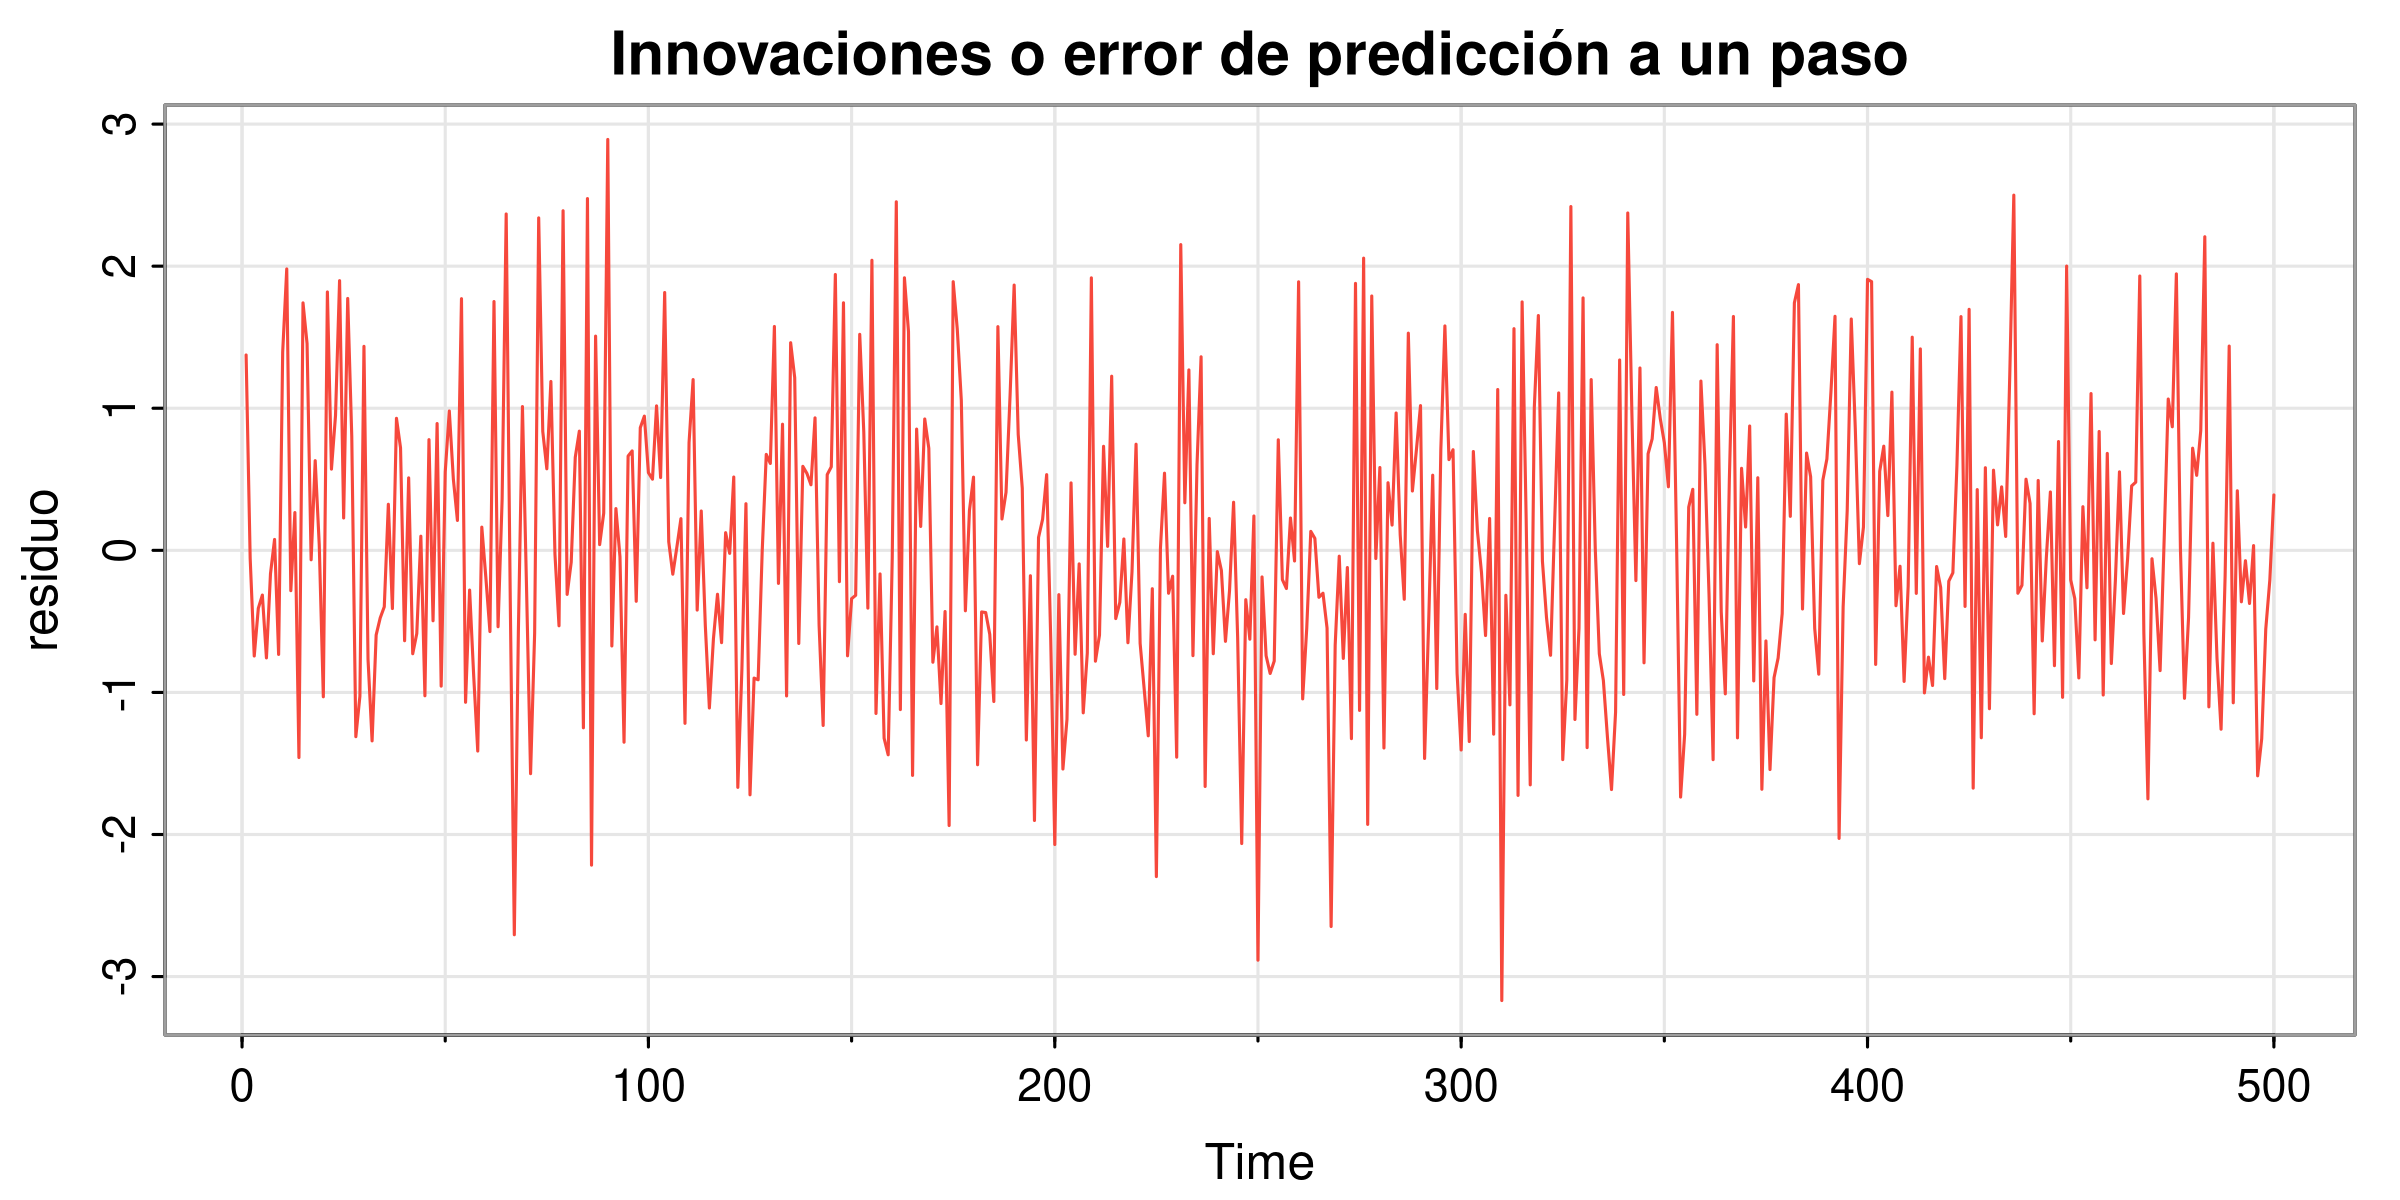

In [8]:
residuo = as.numeric(kf$innov) #recupero las innovaciones del objeto
tsplot(residuo, col=2, main="Innovaciones o error de predicción a un paso")


	Ljung-Box test

data:  Residuals
Q* = 14.788, df = 10, p-value = 0.14

Model df: 0.   Total lags used: 10



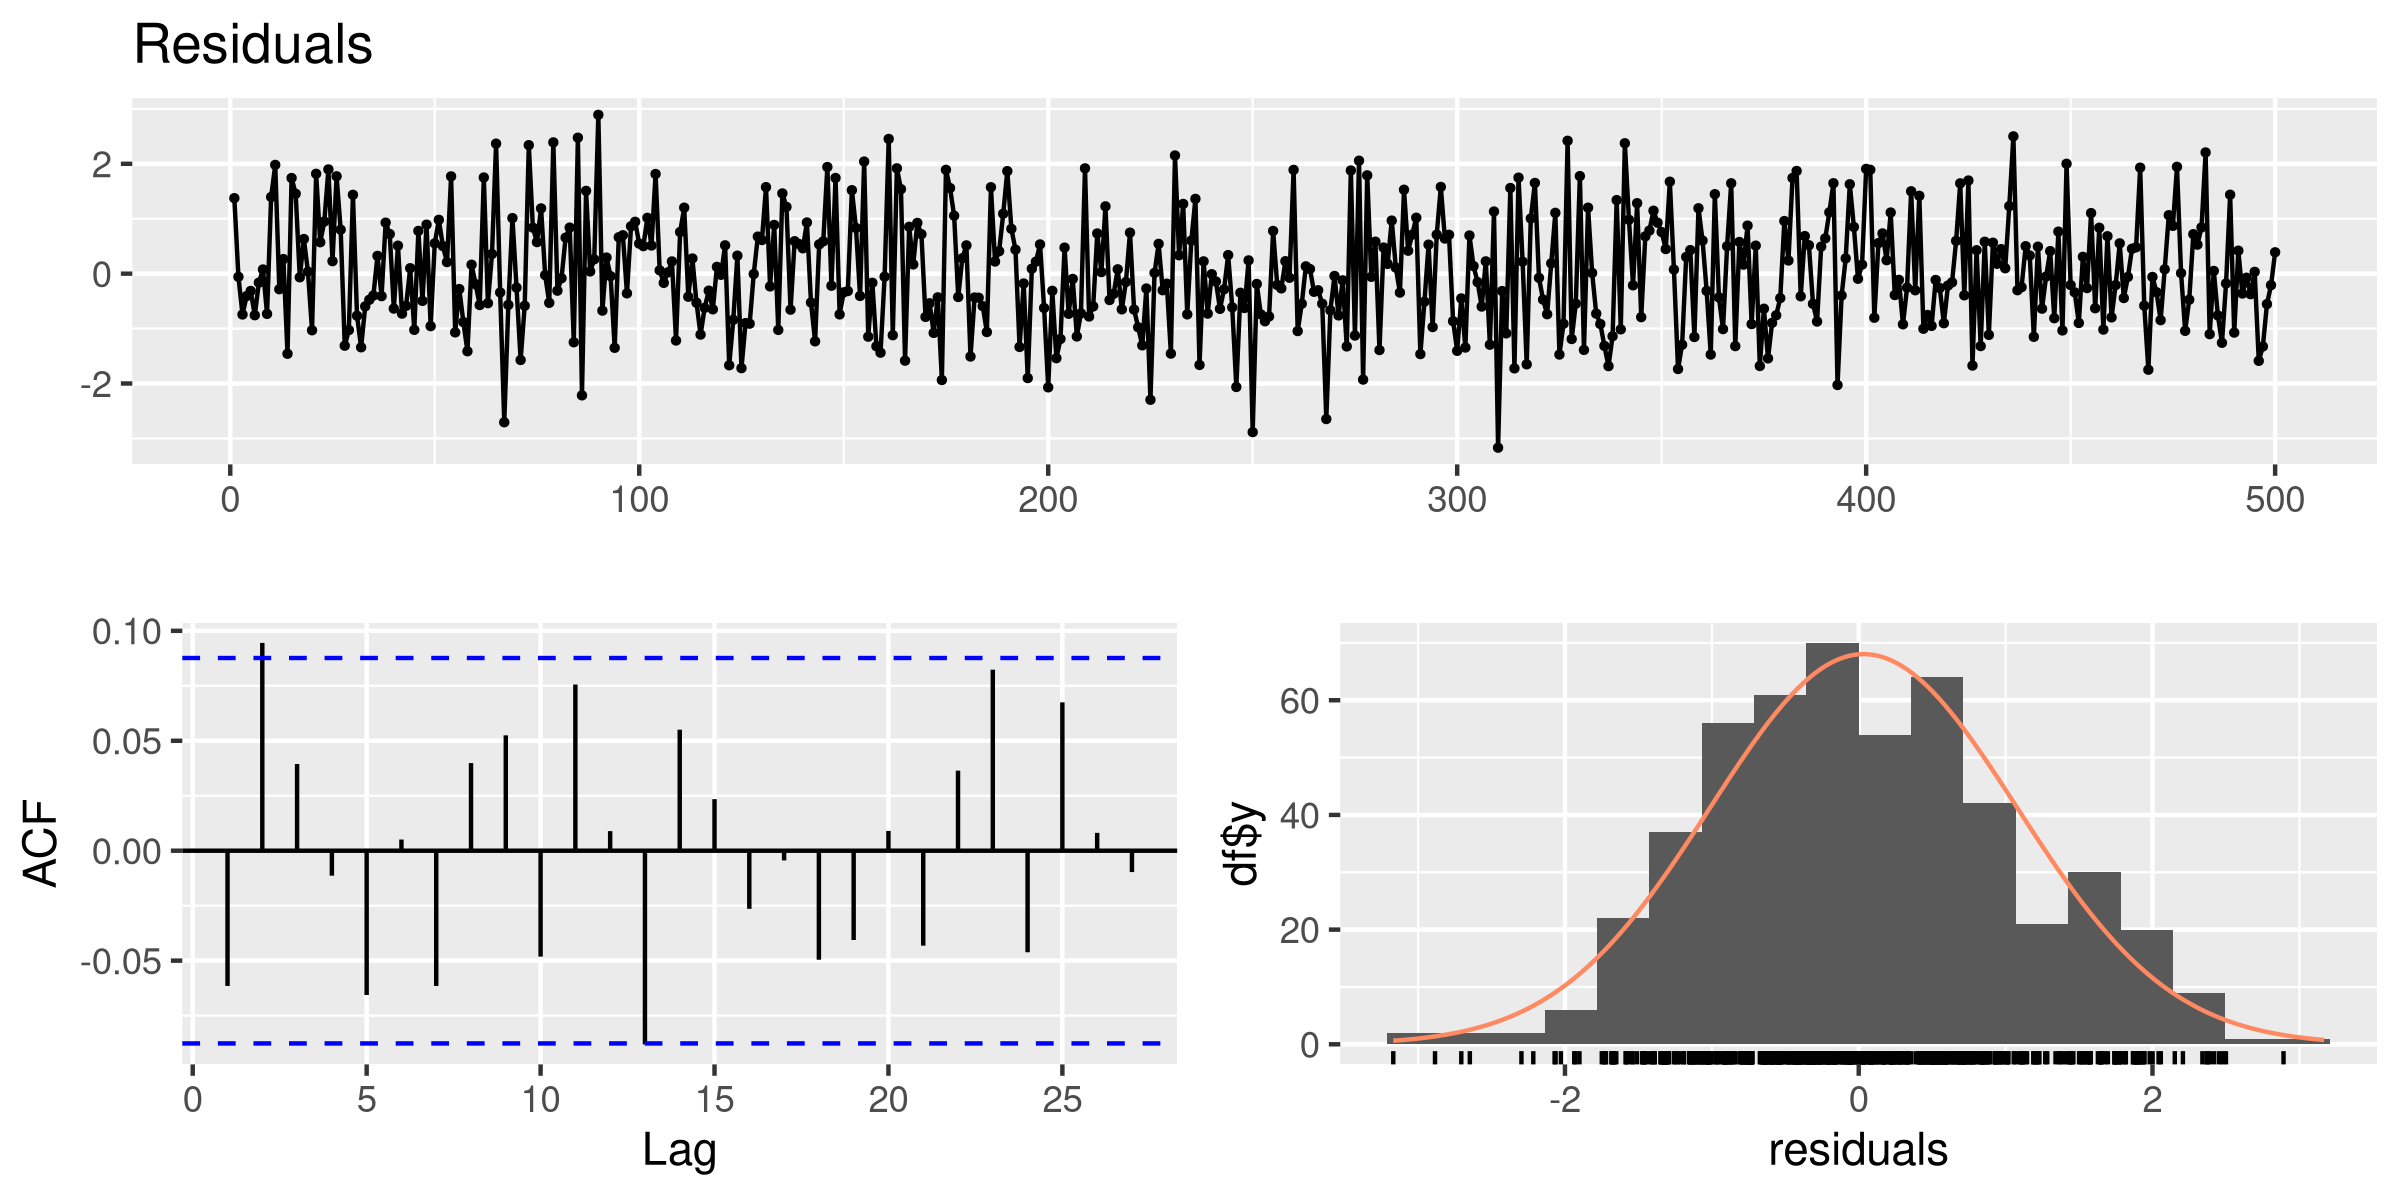

In [10]:
library(forecast)
checkresiduals(residuo)

### Suavizador de Kalman

El procedimiento anterior usa la información de $y_0,\ldots,y_t$ para estimar $x_t$ de manera óptima. ¿Qué ocurre si tenemos información futura? ¿La podemos usar?

**Idea:** calcular $x_t^n = E[x_t\mid y^n] = E[x_t \mid y_0,\ldots,y_n]$ donde $t\leqslant n$.

Para hacerlo se usa el **suavizador de Kalman**. Es un procedimiento recursivo *hacia atrás*. Luego de obtener el filtrado anterior, se usa la información del futuro para volver a corregir la estimación.

### Suavizador de Kalman: procedimiento

Dados los datos $y_0,\ldots,y_n$ y el modelo:

 * Realizamos una pasada de filtrado (*forward*). En particular obtenemos $x^n_n$, la mejor estimación del estado final usando todos los datos, y su error $P_n^n$.
 
 * Se realiza una pasada hacia atrás (*backwards*), donde se corrigen recursivamente las estimaciones $x_t^t$ usando la información de $x_{t+1}^n$, la mejor estimación (ya corregida) del estado siguiente y su varianza.

### Suavizador de Kalman, algoritmo.

Para un modelo en espacio de estados como el que ya vimos y un conjunto de observaciones $\{y_1,\ldots,y_n\} = y^n$:

1. Se corre el filtro de Kalman hasta hallar $x^n_n$ y $P_n^n$.
2. Se itera $t=n,n-1,\ldots,1$ corrigiendo la estimación del filtro $x_{t}^t$ usando la información del futuro:
 
 $$ x^n_{t} = x_{t}^{t} + J_{t}(x^n_{t+1} - x_{t+1}^{t}),$$
 
 $$ P^n_{t} = P^{t}_{t} + J_{t}^2\left(P_{t+1}^n − P_{t+1}^{t}\right).$$ 

siendo:
$$ J_{t} = \frac{P_{t}^{t}}{P^t_{t+1}}\phi$$
el factor de corrección.


In [11]:
# Suavizado: trato de reconstruir el valor actual de x a partir de toda la secuencia.

# Los parámetros son:
#  * y: serie de observaciones
#  * Phi: parámetro de la ecuación de estado.
#  * A: parámetro de la ecuación de observación
#  * mu0: estimación de la media de la condición inicial.
#  * Sigma0: error de estimación de la condición inicial.
#  * sQ: desvío de ruido de estado
#  * sR: desvío de ruido de observación

ks = Ksmooth(y, Phi=1, A=1, mu0=0, Sigma0=1, sQ=sigmaw, sR=sigmav)
xsmooth = as.numeric(ks$Xs) #lo paso a numerico porque si no da problemas

En el objeto `ks` queda guardado el resultado del suavizado en `ks$Xs` y el del filtro (que igual lo tuvo que hacer) en `kf$Xf`.

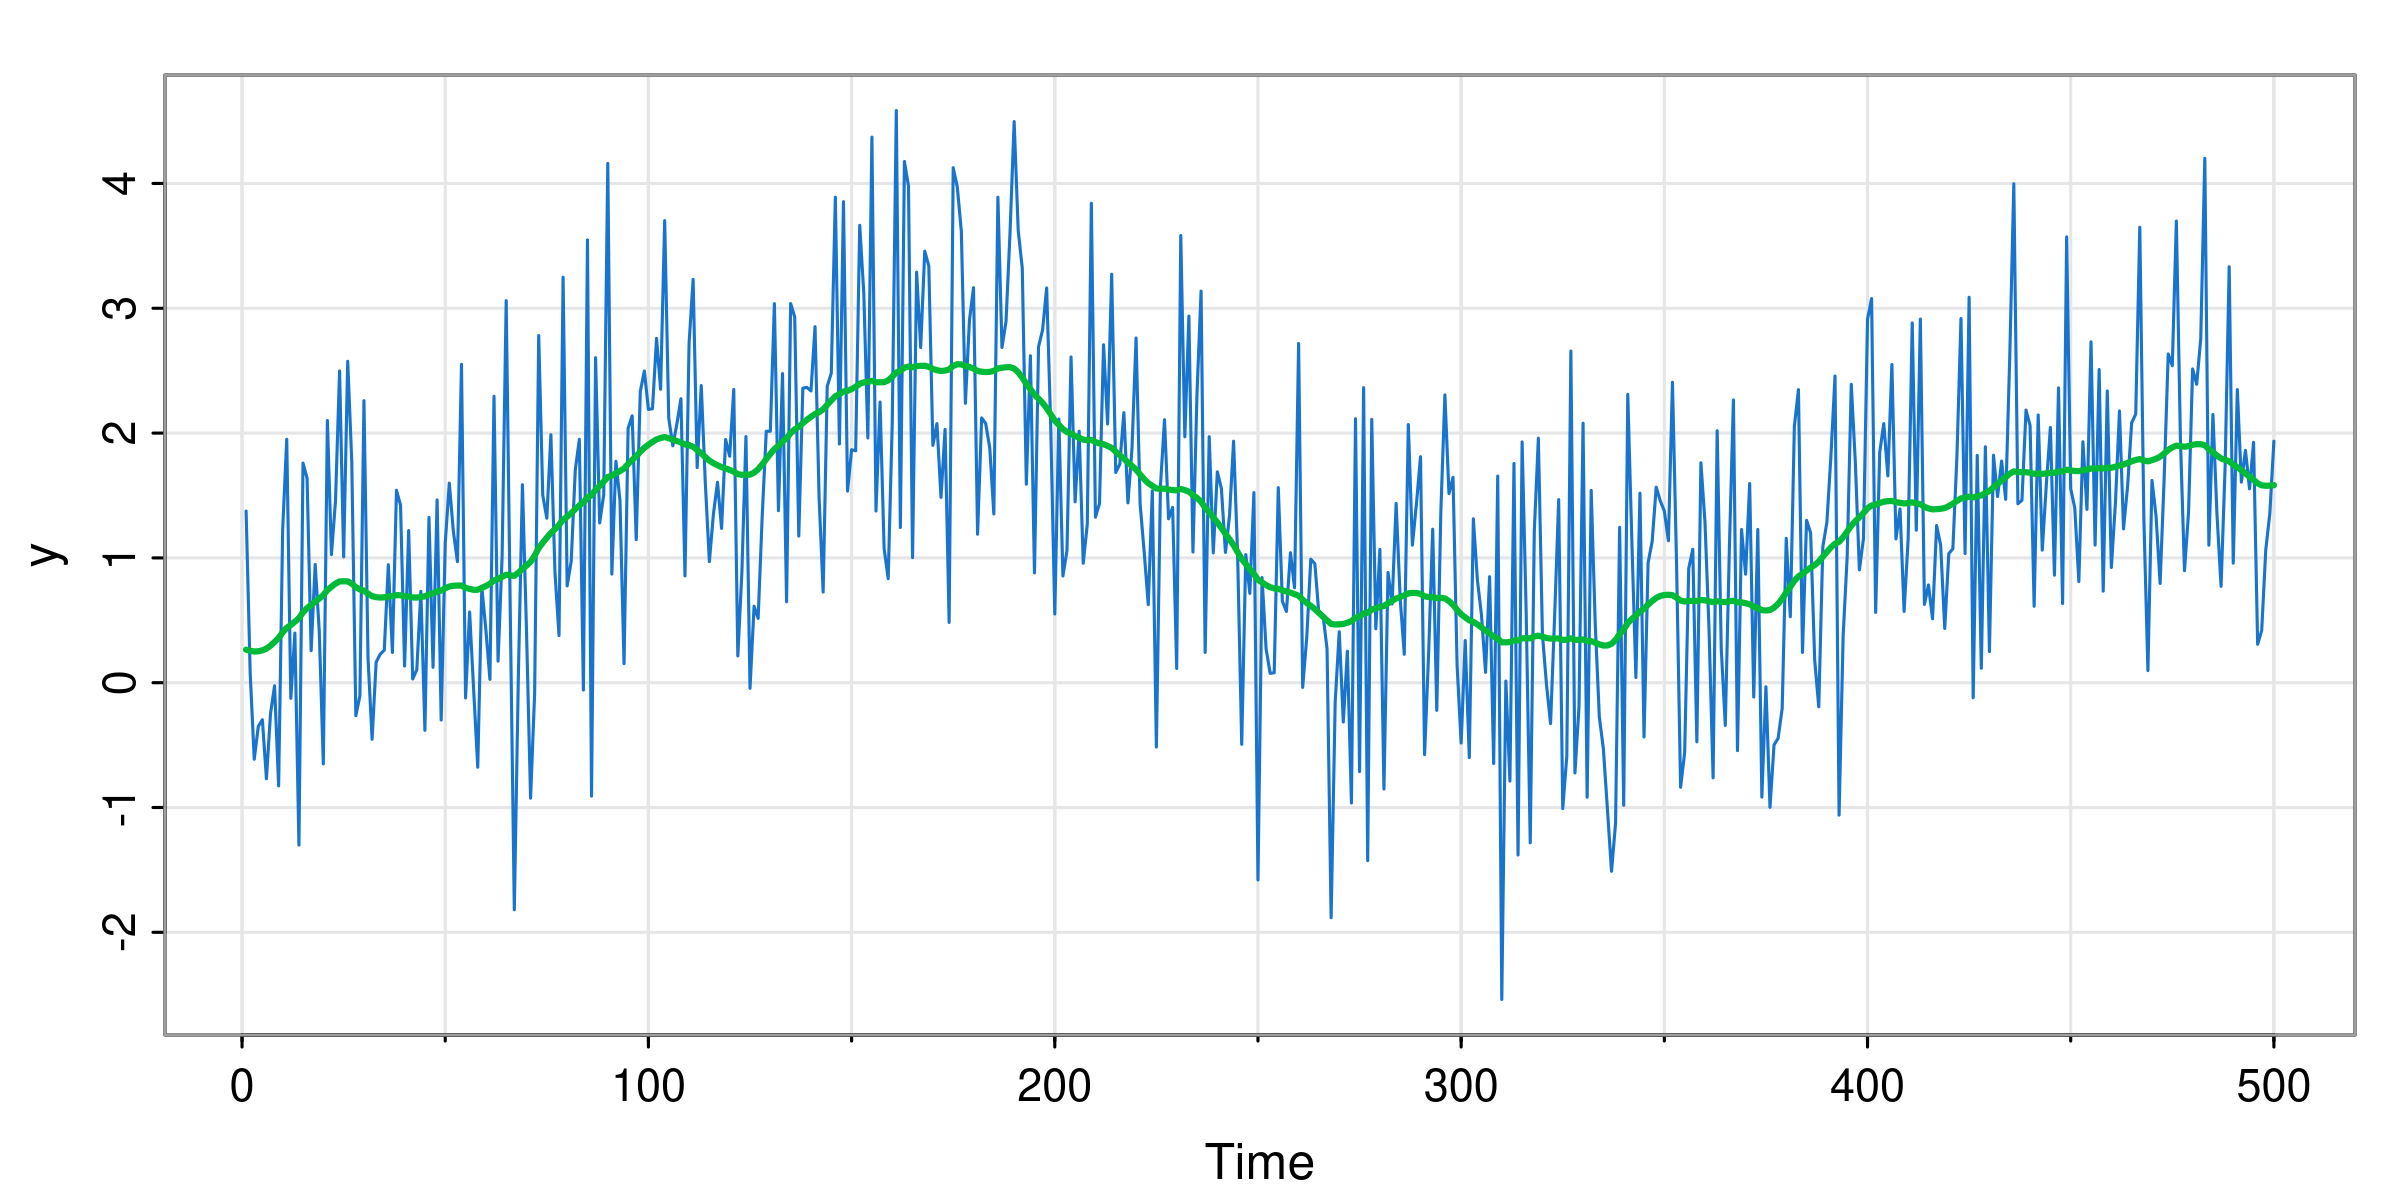

In [12]:
tsplot(y, col=4)
lines(xsmooth, lwd=2, col=3)

### Error de suavizado

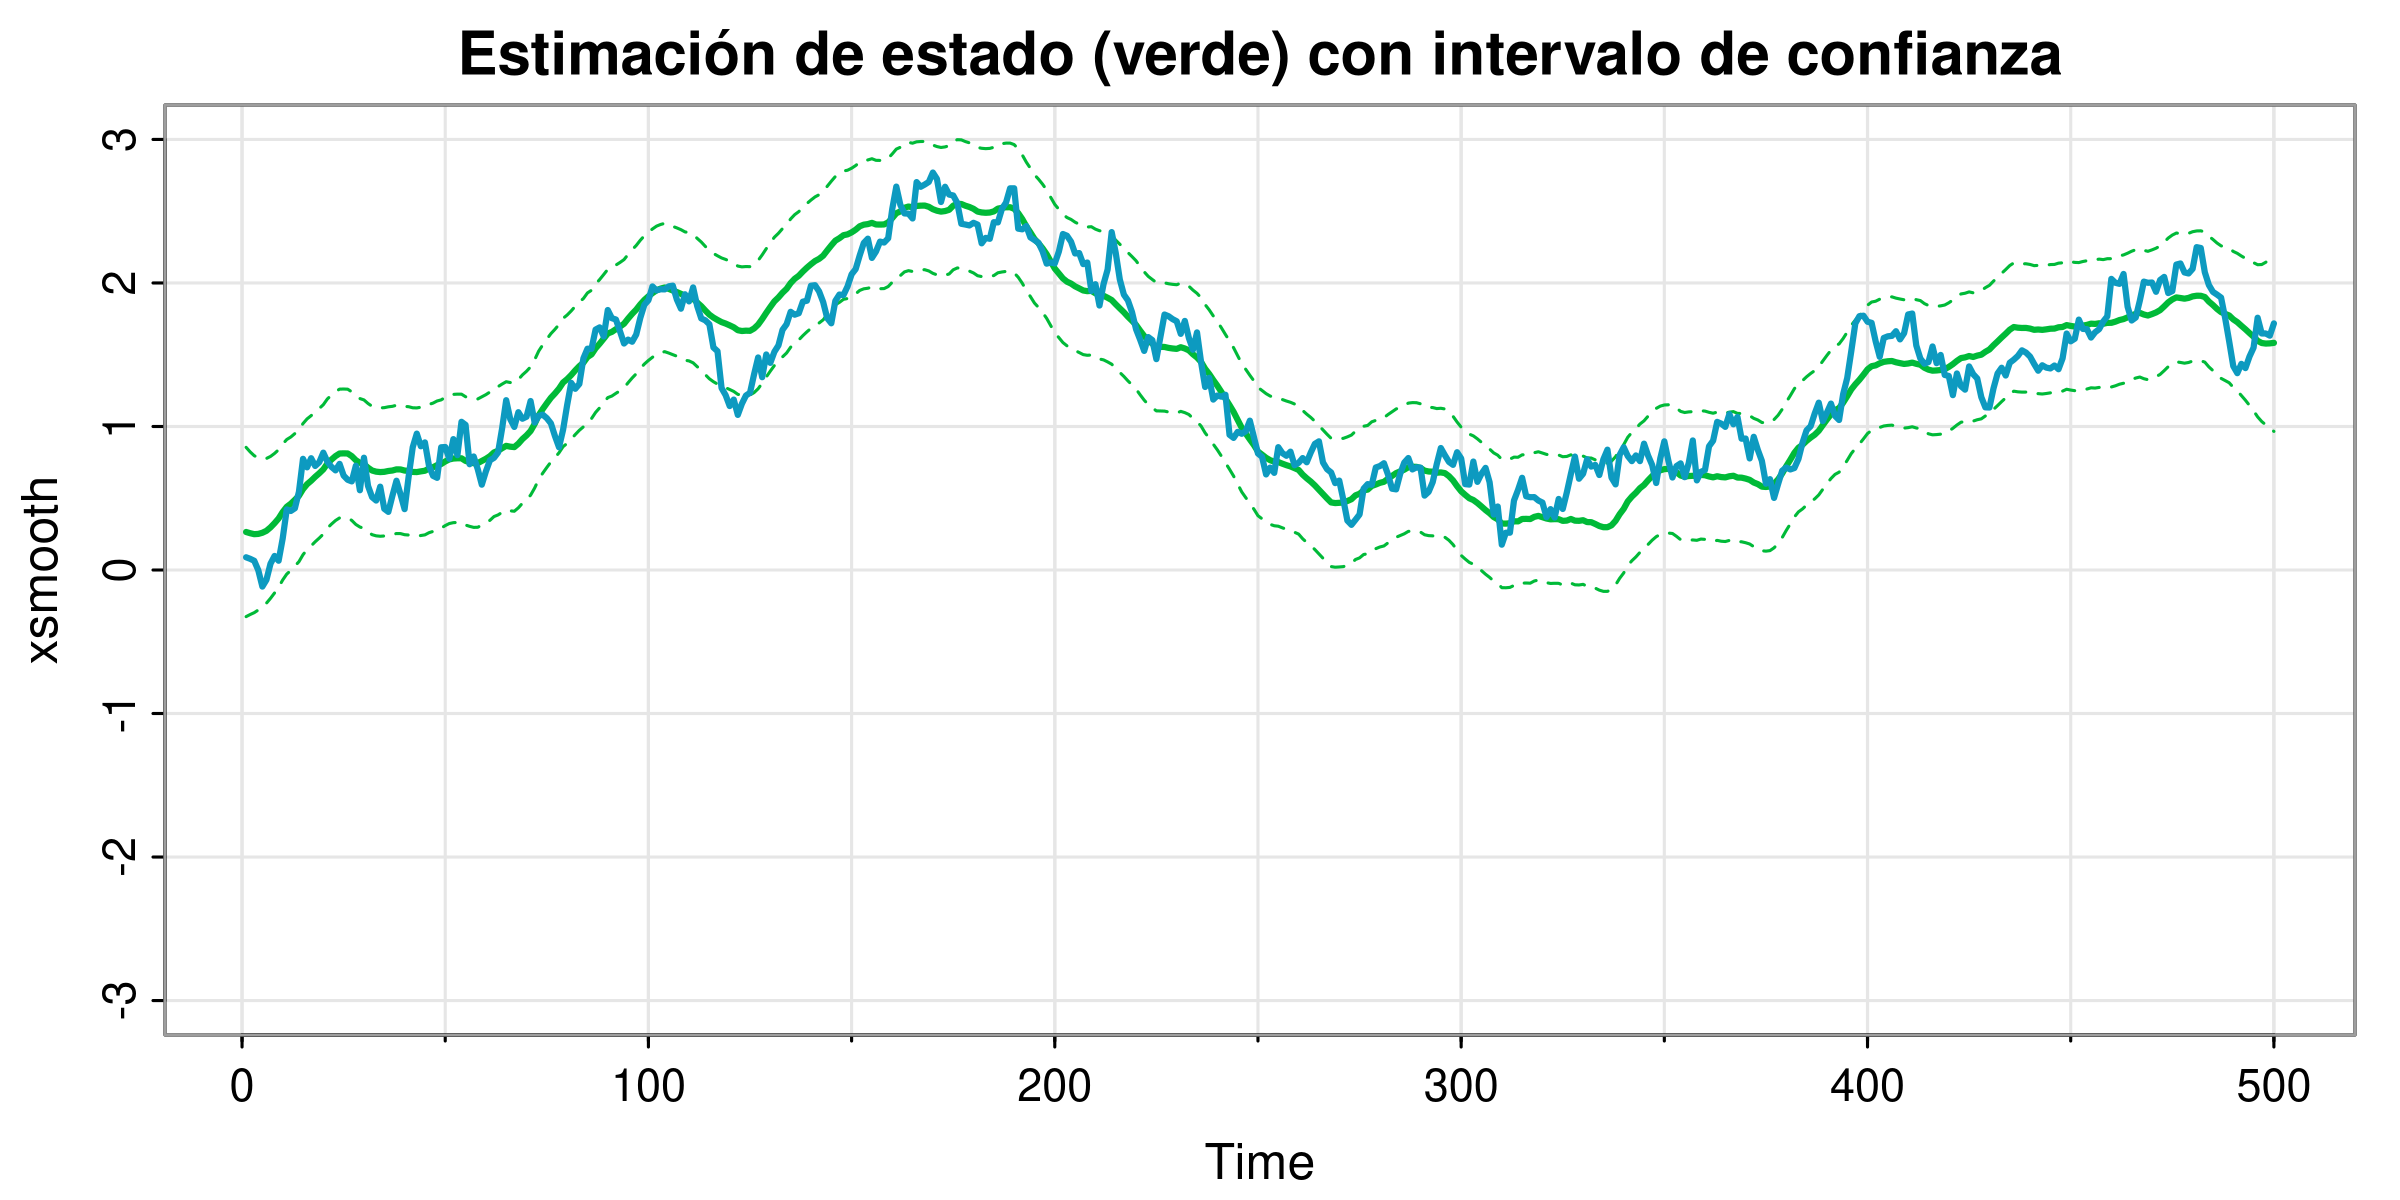

In [13]:
tsplot(xsmooth, ylim=c(-3,3), lwd=2, col=3, main="Estimación de estado (verde) con intervalo de confianza")
lines(xsmooth + 2*sqrt(ks$Ps), col=3, lty=2)
lines(xsmooth - 2*sqrt(ks$Ps), col=3, lty=2)
lines(x, col=5, lwd=2)

## Ajuste por máxima verosimilitud

El procedimiento de filtrado y/o suavizado funciona *una vez que conocemos el modelo*. ¿Cómo podemos ajustar los parámetros?

> **Idea: ajuste por máxima verosimilitud.**
>
>  * Para un modelo dado, podemos estimar las innovaciones $\{\epsilon_t\}$ mediante el filtro.
>  * Las innovaciones son gaussianas independientes de media y varianza dadas. Podemos calcular su verosimilitud.
>  * Luego, mediante un algoritmo tipo gradiente vamos reestimando los parámetros $(\phi,a,\sigma_w,\sigma_v)$ para maximizarla.

### Ejemplo: local level model

Supongamos que tenemos únicamente acceso a la serie $y_t$ anterior y no sus parámetros:

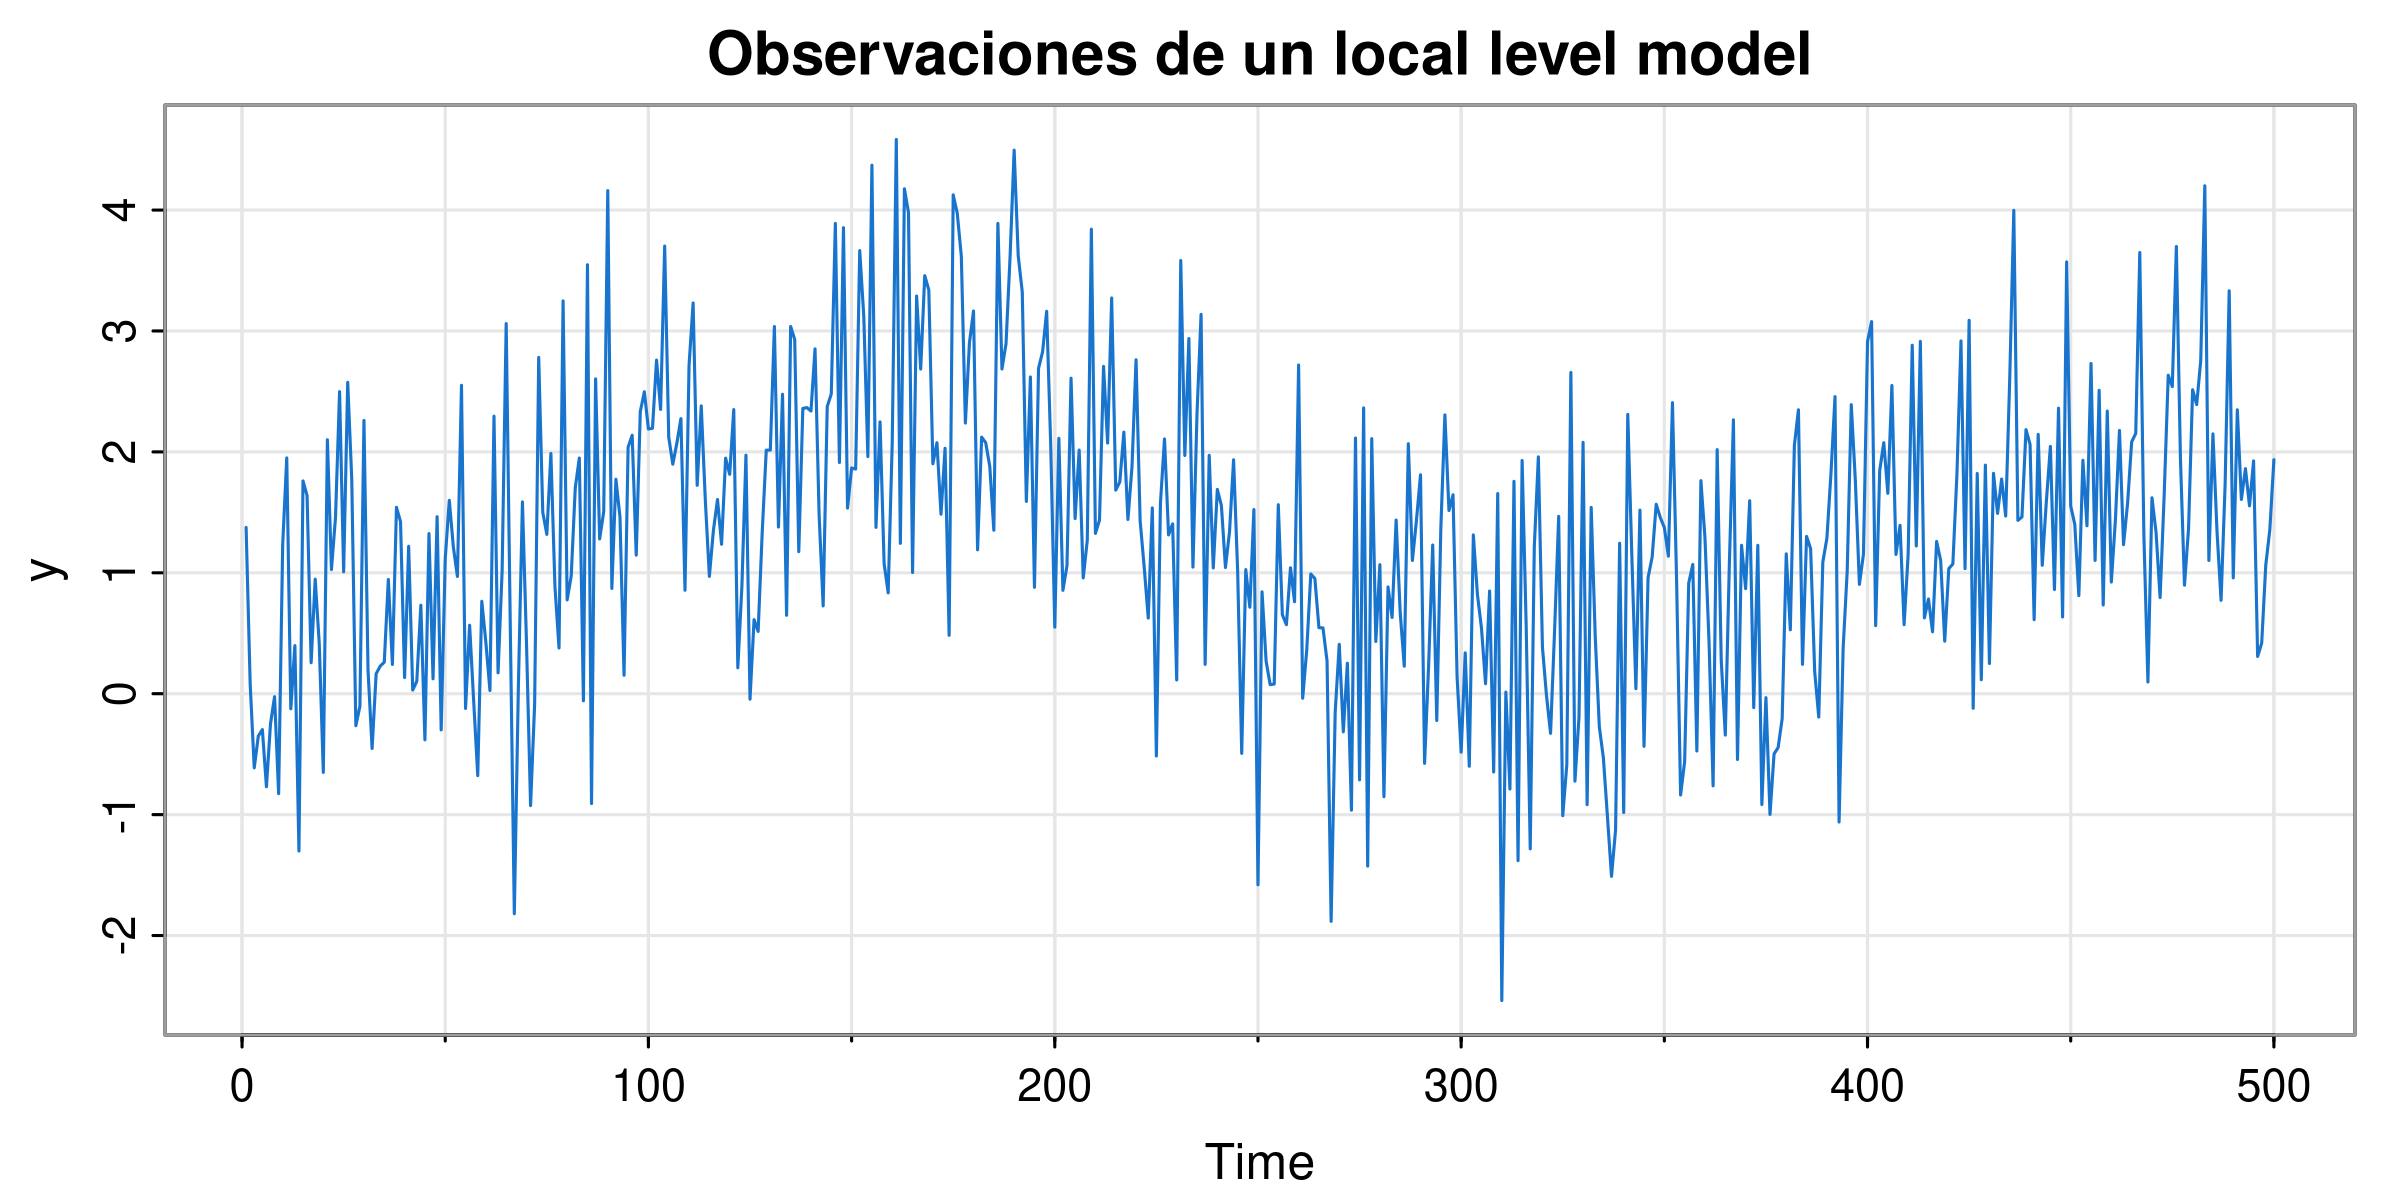

In [14]:
tsplot(y, col=4, main="Observaciones de un local level model")

### Ejemplo: parámetros a ajustar

Si es un local level model, sabemos que $\phi = 1$ y $a=1$ en la ecuación general:

$$\begin{cases} x_{t+1} = x_t + w_t, \\ y_t = x_t + v_t. \end{cases}$$

Resta ajustar $\sigma_w$ y $\sigma_v$.

**Nota:** La función `Kfilter`, para ciertos parámetros dados, nos calcula ya la verosimilitud y la almacena en `kf$like` (en realidad almacena $-\log(L(\theta))$ por lo que debemos minimizar).

In [15]:
# Función que evalúa la verosimilitud para los parámetros libres
#Parámetros (guardados en el vector para):
# sigma_w, ruido de estado
# sigma_v, ruido de observación
# Dados los parámetros, se usa Kfilter para aplicar filtro de Kalman y se computa la verosimilitud.
# Para la condición inicial se usan los primeros valores de y
mu0 = mean(head(y),5)
Sigma0 = var(head(y,15)) #en sigma0 va la varianza ojo

LikelihoodFunction = function(para){
    sigma_w = para[1]
    sigma_v = para[2]    
    kf = Kfilter(y,Phi=1,A=1,mu0,Sigma0,sigma_w,sigma_v)
    return(kf$like) 
 }

In [16]:
# Ajuste por maxima verosimilitud:

#Construyo una estimación inicial de mis desvíos a ajustar.
#En este caso elegimos como sigma_v el desvío estándar de toda la serie y,
#y para sigma_w un 10% de eso ya que esperamos que oscile menos.
init.par = c(0.1*sd(y),sd(y))

#Llamo al optimizador de R usando el método de gradiente mejorado BFGS y guardo la estimación
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1))

#Las derivadas segundas de la estimación me dan info del error de ajuste (significación).
estimation_error = sqrt(diag(solve(est$hessian)));

initial  value 290.899854 
final  value 272.647404 
converged


In [17]:
# Asigno los parametros finales de la optimizacion
sigma_w_est = est$par[1]
sigma_v_est = est$par[2]

print(paste("Valor inicial de sigma_w: ", init.par[1]))
print(paste("Valor inicial de sigma_v: ", init.par[2]))
print(paste("Valor estimado de sigma_w: ", sigma_w_est))
print(paste("Valor estimado de sigma_v: ", sigma_v_est))

print(paste("Int. de confianza para sigma_w: ", sigma_w_est-2*estimation_error[1], sigma_w_est+2*estimation_error[1]))
print(paste("Int. de confianza para sigma_v: ", sigma_v_est-2*estimation_error[2], sigma_v_est+2*estimation_error[2]))

print(paste("Valor real de sigma_w: ", sigmaw))
print(paste("Valor real de sigma_v: ", sigmav))


[1] "Valor inicial de sigma_w:  0.121938721757412"
[1] "Valor inicial de sigma_v:  1.21938721757412"
[1] "Valor estimado de sigma_w:  0.103695043915714"
[1] "Valor estimado de sigma_v:  0.99202184901688"
[1] "Int. de confianza para sigma_w:  0.0620068137550149 0.145383274076413"
[1] "Int. de confianza para sigma_v:  0.925732168157202 1.05831152987656"
[1] "Valor real de sigma_w:  0.1"
[1] "Valor real de sigma_v:  1"


### Resultado del ajuste

Finalmente, con los valores ajustados podemos:

 * Correr una pasada más del suavizado para estimar el estado final.
 * Hacer un chequeo de residuos en las innovaciones calculadas.

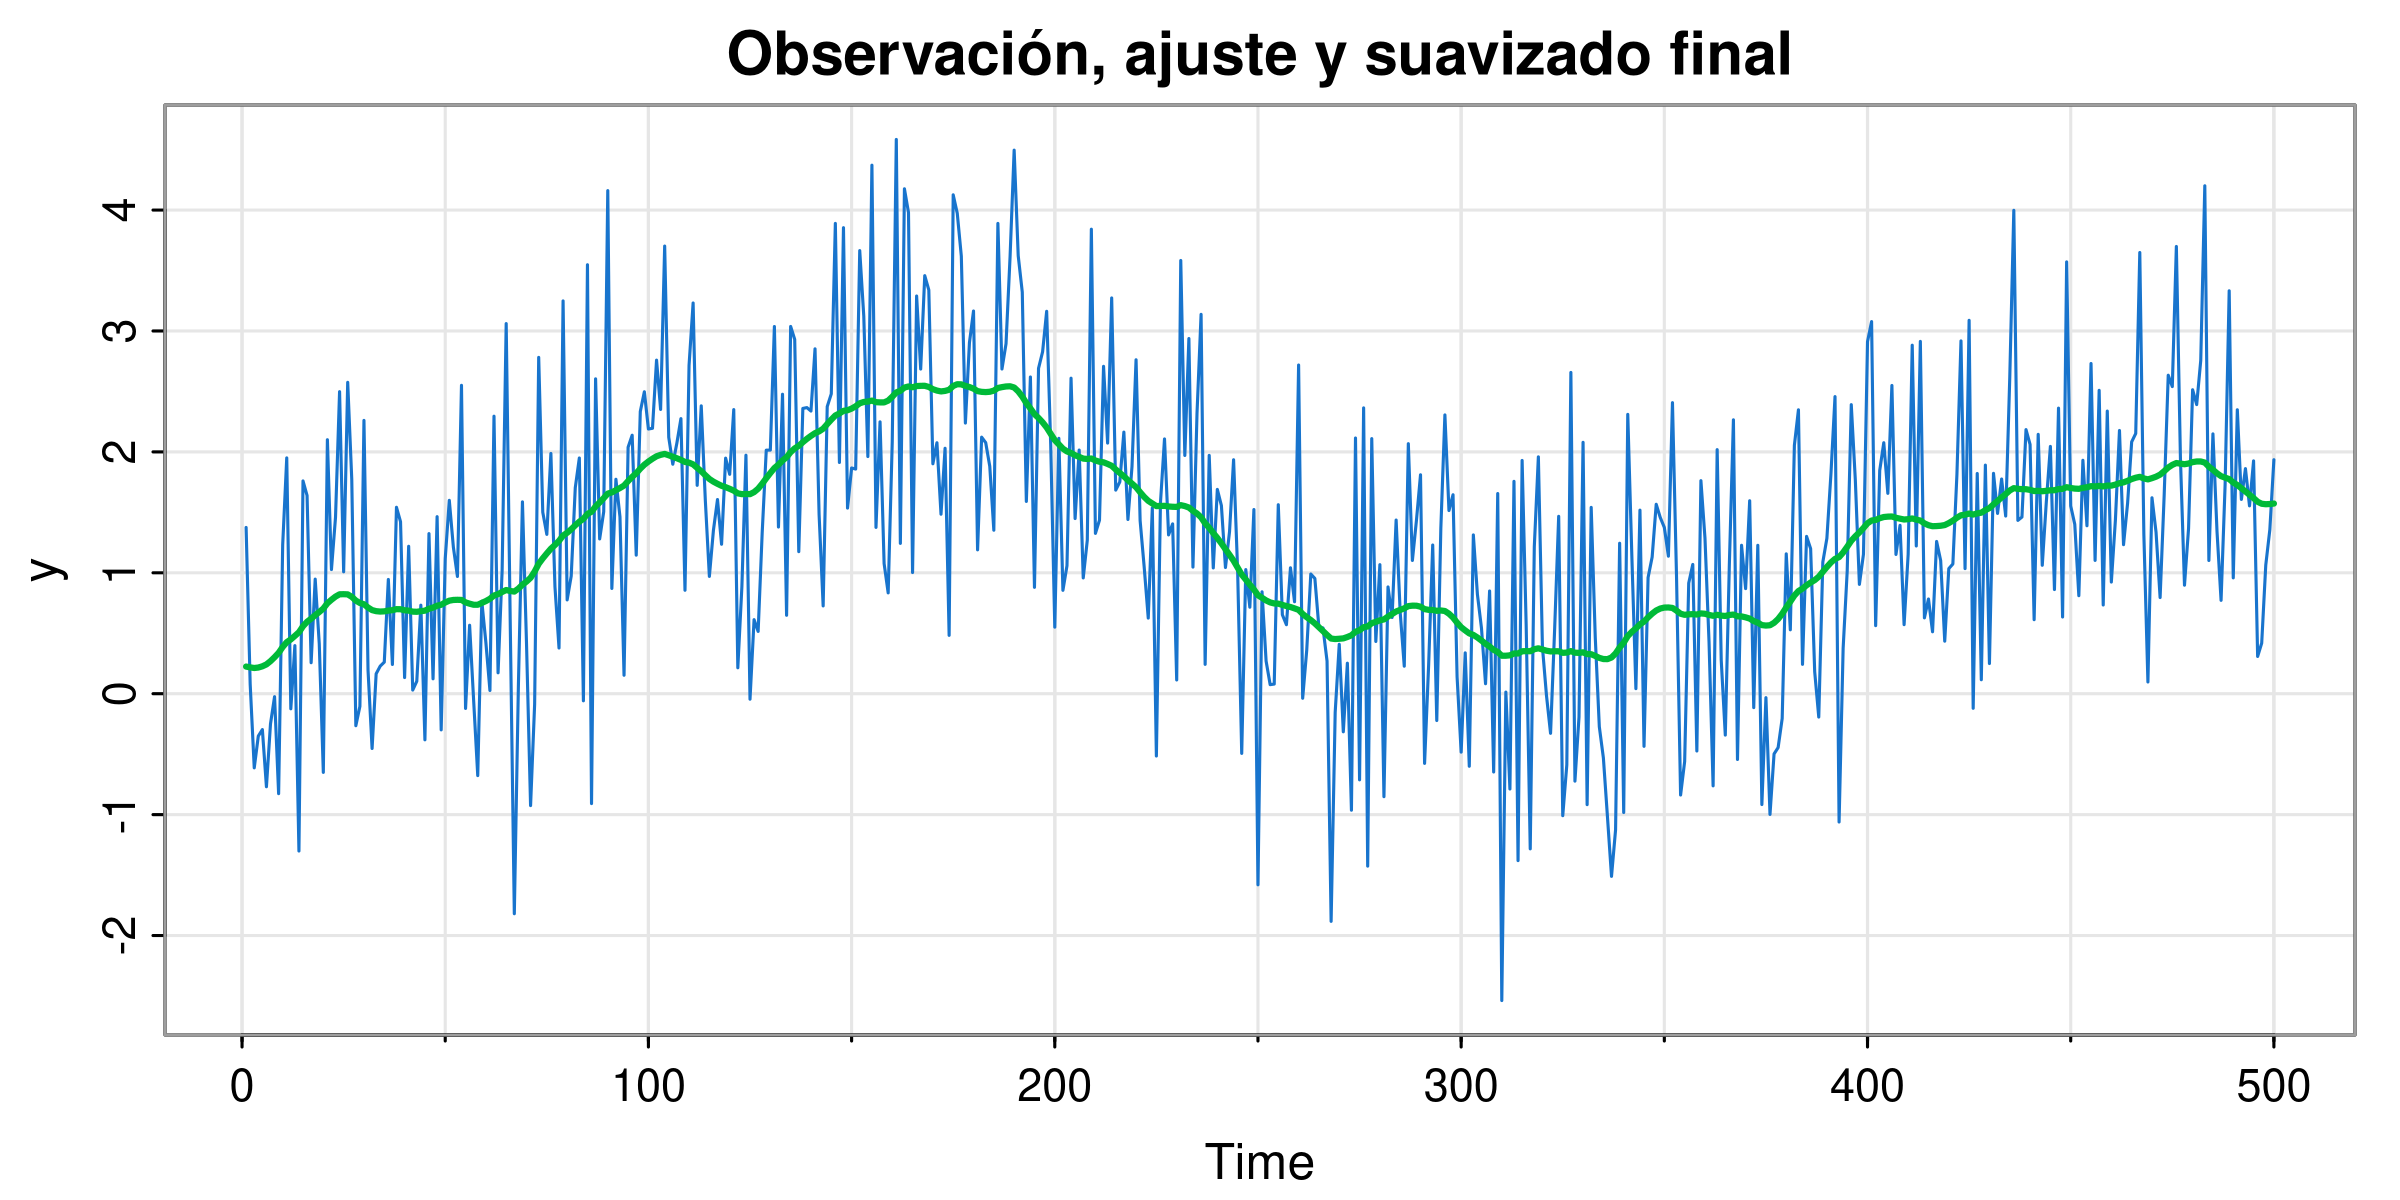

In [18]:
ks2 = Ksmooth(y, Phi=1, A=1, mu0=mu0, Sigma0=Sigma0, sQ=sigma_w_est, sR=sigma_v_est)
xsmooth2 = as.numeric(ks2$Xs) #lo paso a numerico porque si no da problemas
tsplot(y, col=4, main="Observación, ajuste y suavizado final")
lines(xsmooth2, lwd=2,col=3)


	Ljung-Box test

data:  Residuals
Q* = 14.688, df = 10, p-value = 0.1438

Model df: 0.   Total lags used: 10



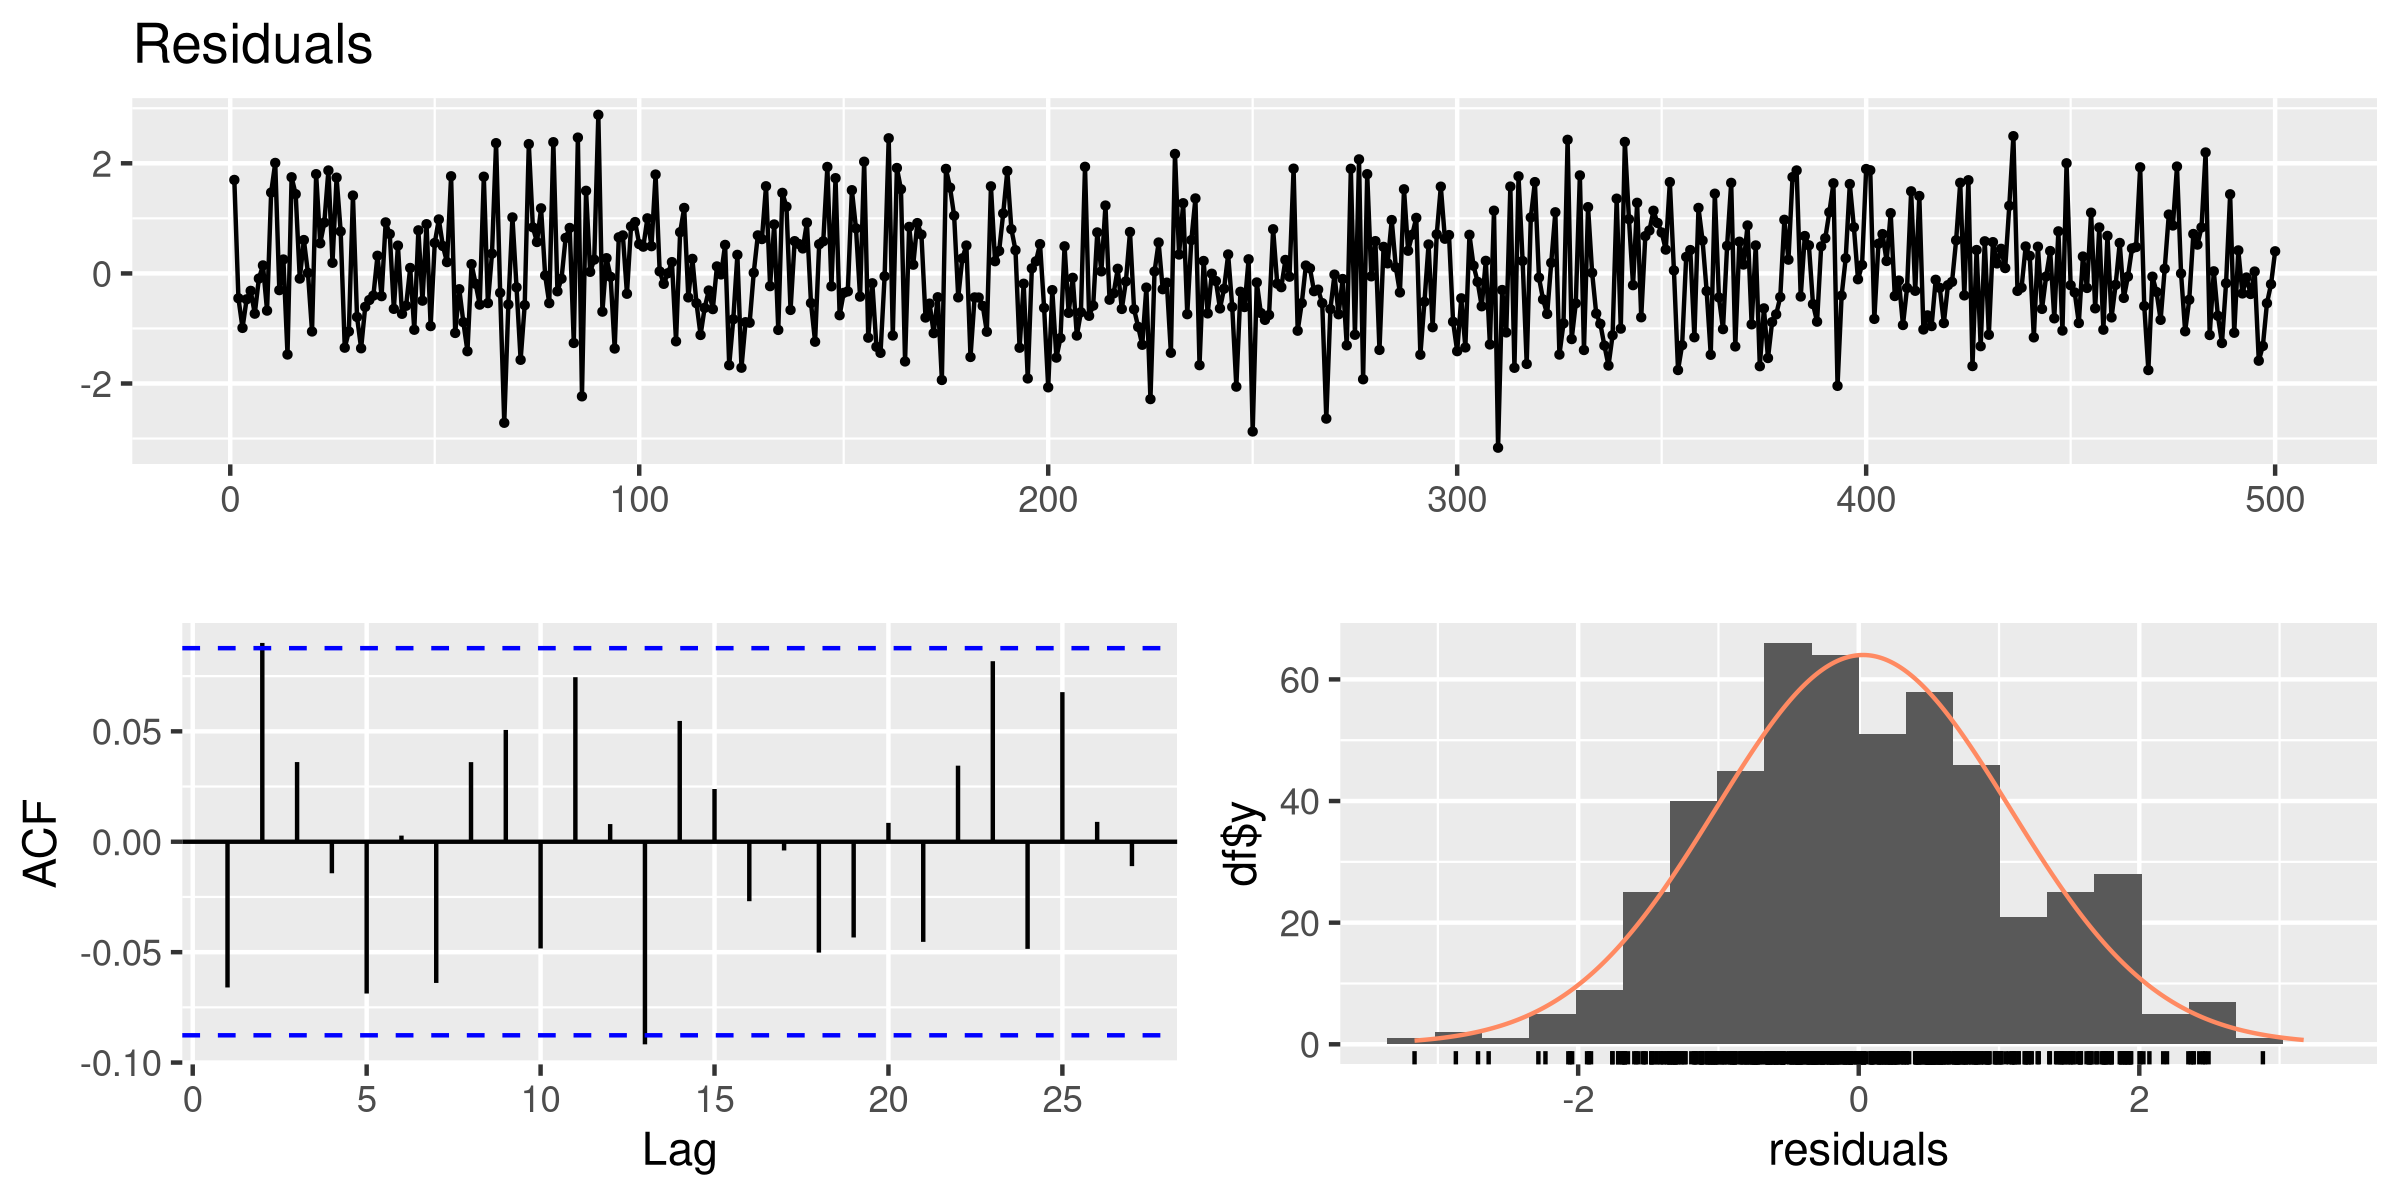

In [19]:
residuos = as.numeric(ks2$innov)
checkresiduals(residuos)

## Modelo lineal dinámico: generalizaciones

El modelo básico anterior se puede generalizar de muchas maneras. Una básica para modelar tendencias es agregar una *entrada* $u_t$ conocida, que fuerza al estado y posiblemente a la observación.

   $$\begin{cases} x_{t+1} = \phi x_t + b u_t + w_t, \\ y_{t} = ax_t + cu_t + v_t, \end{cases}$$
   
   con $(\phi,a,b,c)$ parámetros y como antes $w_t$ y $v_t$ ruido blanco de varianzas $\sigma_w^2$ y $\sigma_v^2$, también parámetros.

### Ejemplo: calentamiento global

Volvamos a la serie de temperaturas globales vista antes:

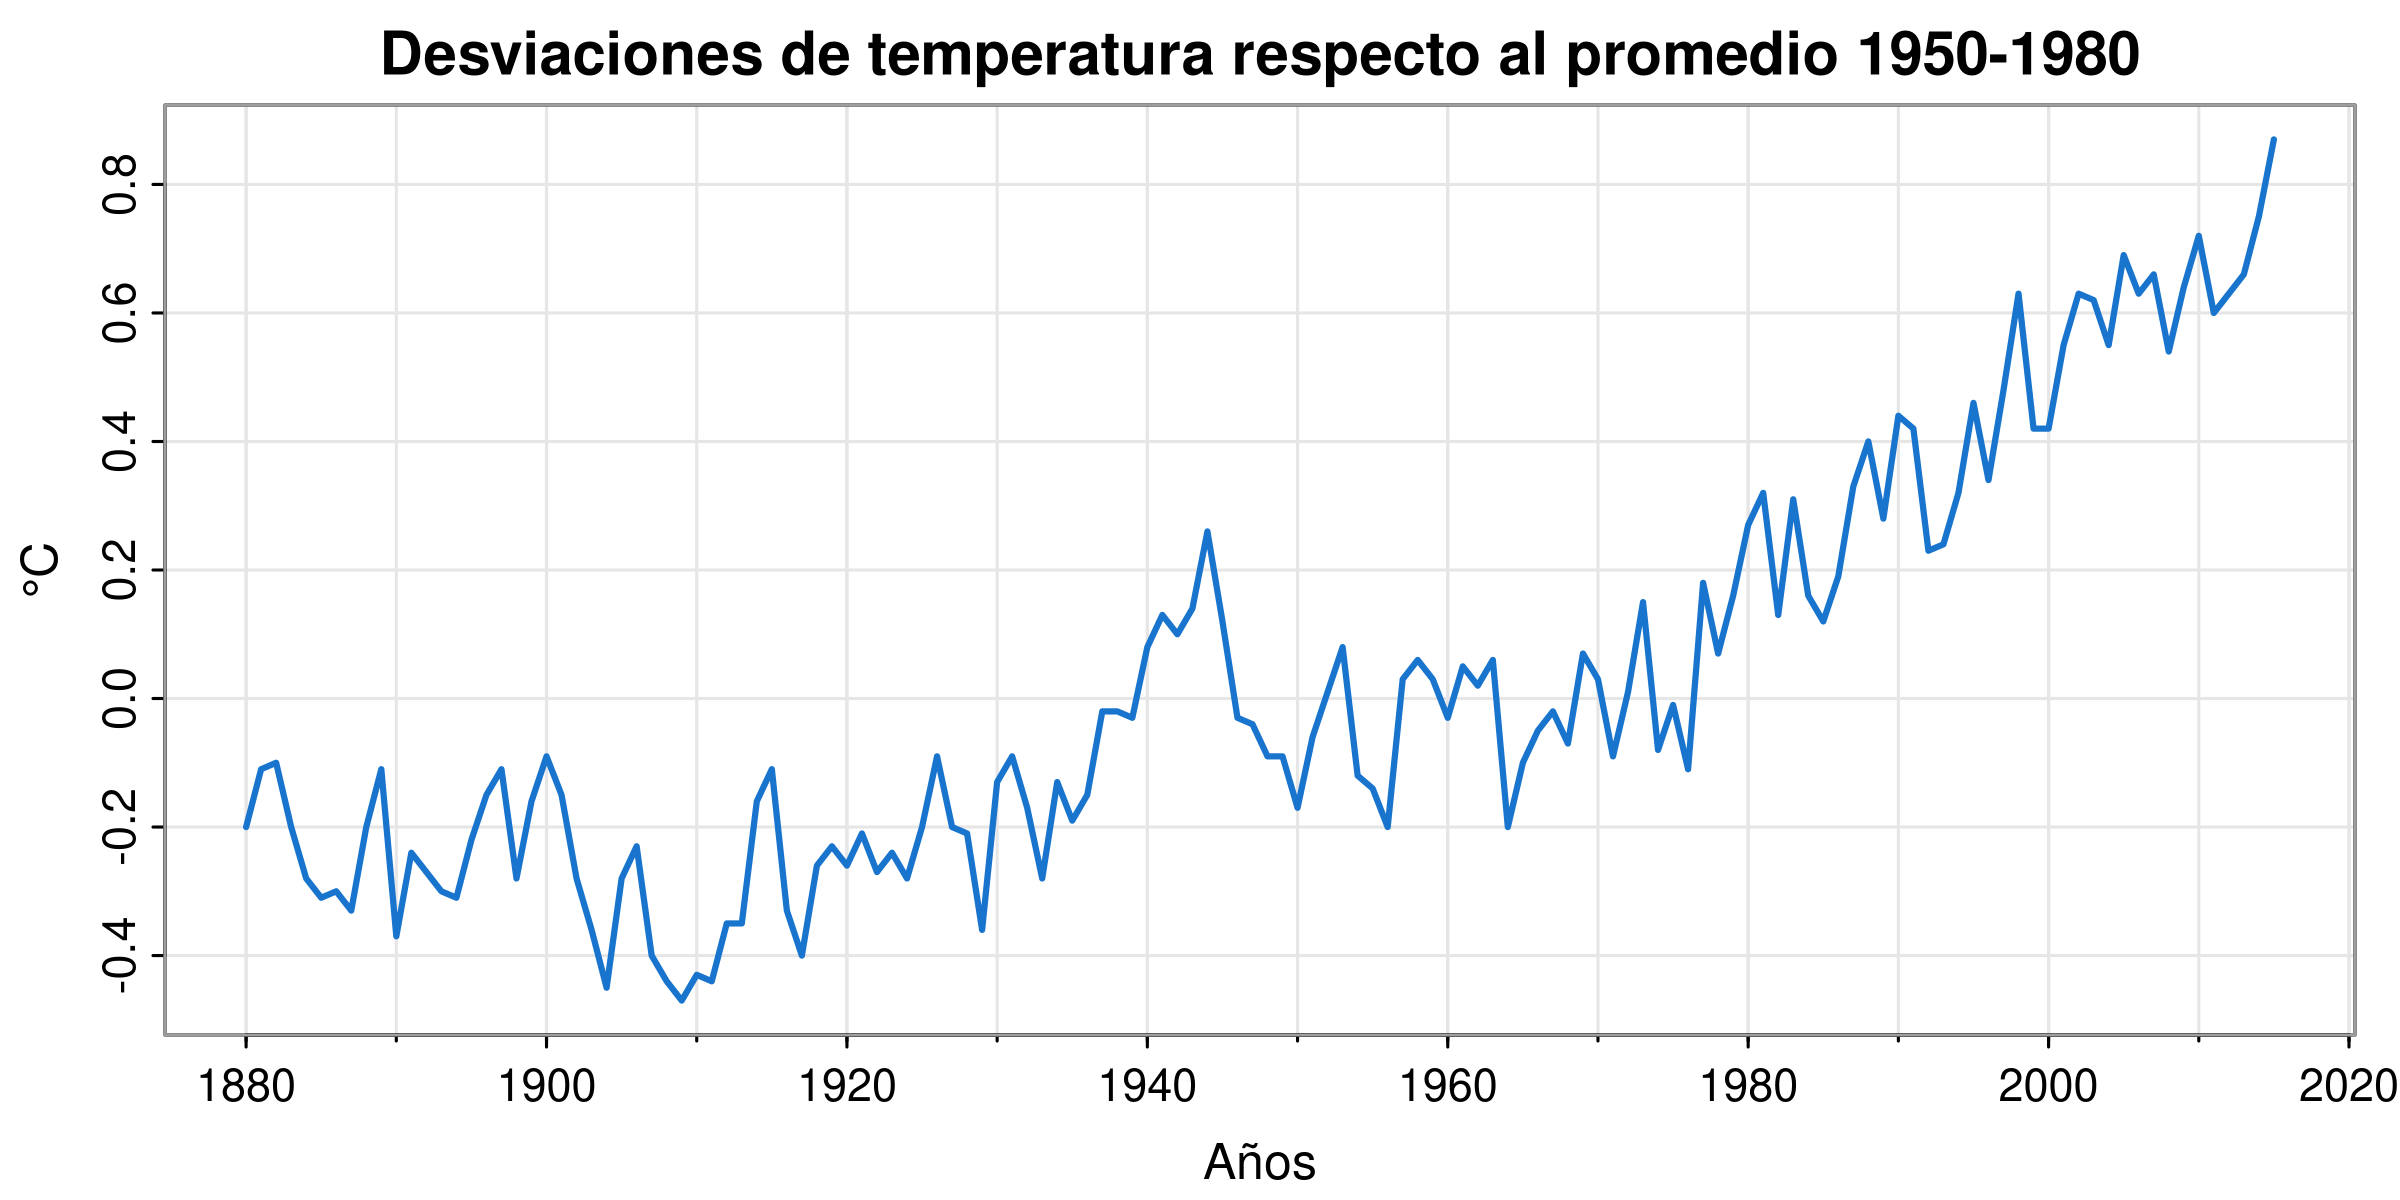

In [20]:
tsplot(globtemp, lwd=2, col=4, 
       main="Desviaciones de temperatura respecto al promedio 1950-1980", 
       xlab="Años", ylab="°C")

### Modelo:

Supongamos que la serie tiene un estado $x_t$ que se mueve como un *paseo al azar con tendencia* y que además observamos a través de ruido. Matemáticamente:

   $$\begin{cases} x_{t+1} = x_t + \delta + w_t, \\ y_{t} = x_t + v_t, \end{cases}$$
   
Corresponde al modelo anterior con:

 * $\phi=1$, $a=1$.
 * $b = \delta$ y $u_t \equiv 1$ constante (tendencia constante, su valor $\delta$ no lo conocemos).
 * $c = 0$ ya que no afecta la medida directamente.
 * $\sigma_w$ y $\sigma_v$ desconocidos.

### Estimación por máxima verosimilitud.

Podemos hacer el mismo algoritmo que antes, especificandole a Kfilter que hay una entrada, y que la misma depende de un parámetro a ajustar.

In [21]:
# Función que evalúa la verosimilitud para los parámetros libres
#Parámetros (guardados en el vector para):
# sigma_w, ruido de estado
# sigma_v, ruido de observación
# delta, valor de tendencia
# Dados los parámetros, se usa Kfilter para aplicar filtro de Kalman y se computa la verosimilitud.
# Para la condición inicial se usan los primeros valores de y
mu0 = mean(head(globtemp),3)
Sigma0 = var(head(globtemp,12)) #en sigma0 va la varianza ojo

LikelihoodFunction = function(para){
    sigma_w = para[1]
    sigma_v = para[2] 
    delta = para[3]
    #Ups es el nombre que Kfilter le da a b (Matriz Upsilon, muy feo el nombre)
    kf = Kfilter(globtemp,Phi=1,A=1,Ups=delta,mu0,Sigma0,sigma_w,sigma_v, input=1)
    return(kf$like) 
 }

In [22]:
# Ajuste por maxima verosimilitud:

#Construyo una estimación inicial de mis parámetros ajustar.
#Para delta, tomo la pendiente del ultimo valor menos el primero de la serie.
temp_final = as.numeric(tail(globtemp,1))
temp_inicial = as.numeric(head(globtemp,1))
delta_ini = (temp_final-temp_inicial)/(length(globtemp))
print(paste("Estimación inicial de delta (grados/año): ",delta_ini))

#En este caso elegimos como sigma_v el desvío estándar de toda la serie y,
#y para sigma_w un 10% de eso ya que esperamos que oscile menos.
#Para delta 
init.par = c(0.1*sd(globtemp),sd(globtemp),delta_ini)


[1] "Estimación inicial de delta (grados/año):  0.00786764705882353"


In [23]:
#Llamo al optimizador de R usando el método de gradiente mejorado BFGS y guardo la estimación
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1))

#Las derivadas segundas de la estimación me dan info del error de ajuste (significación).
estimation_error = sqrt(diag(solve(est$hessian)));

initial  value -139.889199 
iter  10 value -242.366653
final  value -243.017914 
converged


In [24]:
# Asigno los parametros finales de la optimizacion
sigma_w_est = abs(est$par[1])  #el abs es por si le da la solución negativa
sigma_v_est = abs(est$par[2])
delta_est = est$par[3]

print(paste("Valor inicial de sigma_w: ", init.par[1]))
print(paste("Valor inicial de sigma_v: ", init.par[2]))
print(paste("Valor inicial de delta: ", init.par[3]))

print(paste("Valor estimado de sigma_w: ", sigma_w_est))
print(paste("Valor estimado de sigma_v: ", sigma_v_est))
print(paste("Valor estimado de delta: ", delta_est))

print(paste("Int. de confianza para sigma_w: ", sigma_w_est-2*estimation_error[1], sigma_w_est+2*estimation_error[1]))
print(paste("Int. de confianza para sigma_v: ", sigma_v_est-2*estimation_error[2], sigma_v_est+2*estimation_error[2]))
print(paste("Int. de confianza para delta: ", delta_est-2*estimation_error[3], delta_est+2*estimation_error[3]))

[1] "Valor inicial de sigma_w:  0.0317338983582366"
[1] "Valor inicial de sigma_v:  0.317338983582366"
[1] "Valor inicial de delta:  0.00786764705882353"
[1] "Valor estimado de sigma_w:  0.0499068911723711"
[1] "Valor estimado de sigma_v:  0.072478675607726"
[1] "Valor estimado de delta:  0.0072076552584884"
[1] "Int. de confianza para sigma_w:  0.0287837284717907 0.0710300538729514"
[1] "Int. de confianza para sigma_v:  0.0557893597346964 0.0891679914807555"
[1] "Int. de confianza para delta:  -0.00142867832956422 0.015843988846541"


### Resultado del ajuste

Finalmente, con los valores ajustados podemos estimar la tendencia y chequear residuos:

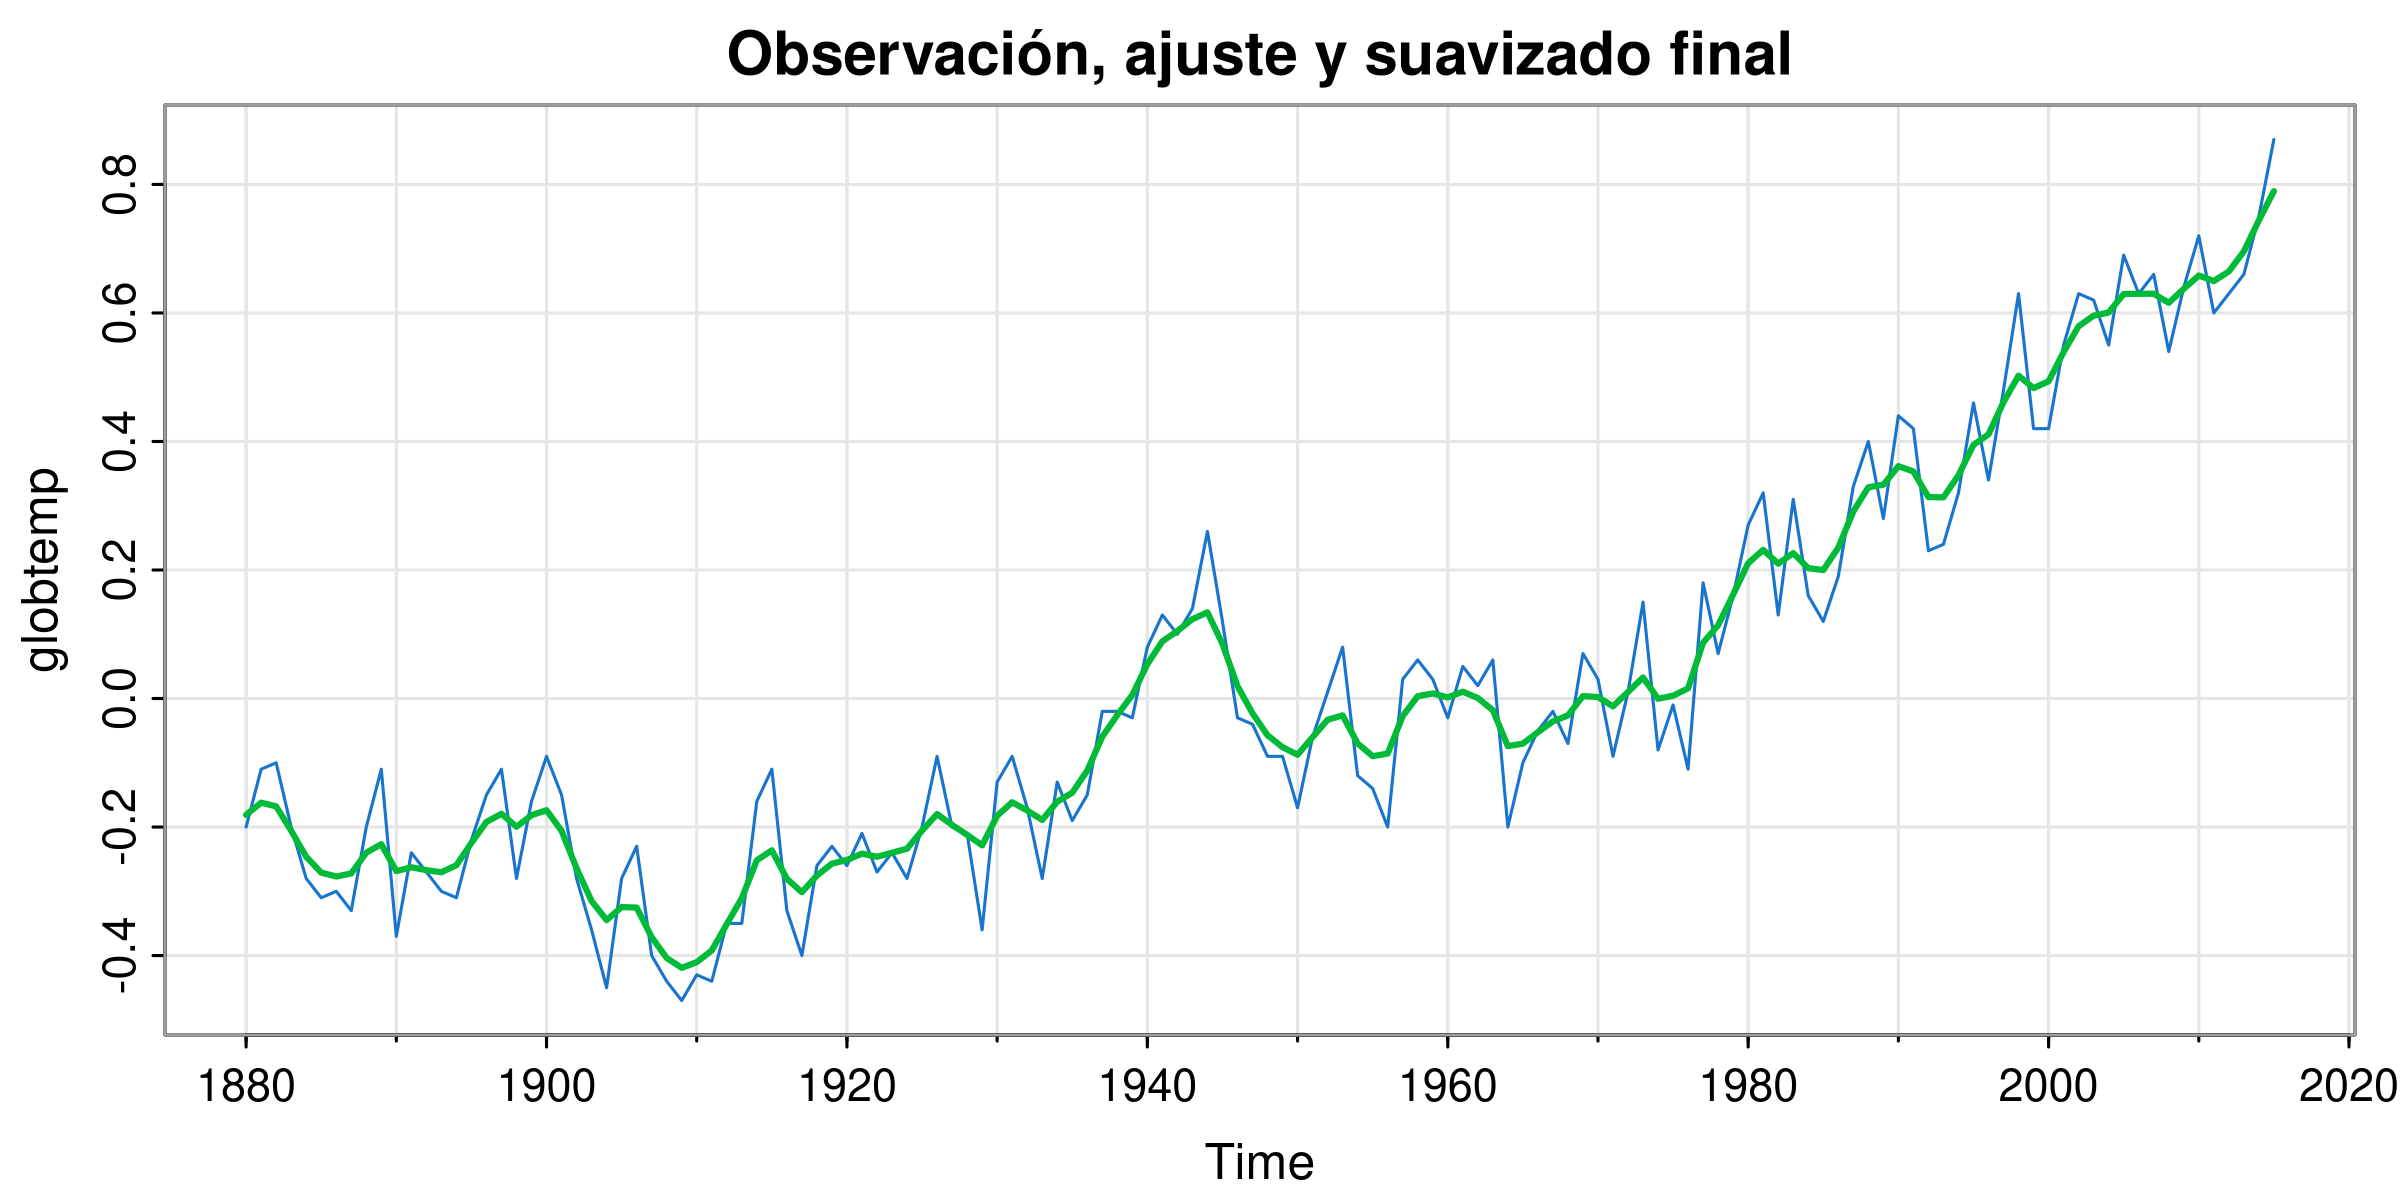

In [25]:
ks_temp = Ksmooth(globtemp,Phi=1,A=1,Ups=delta_est,mu0,Sigma0,sigma_w_est,sigma_v_est, input=1)
gtemp_smooth = ts(as.numeric(ks_temp$Xs), start=1880) #construyo la serie temporal
tsplot(globtemp, col=4, main="Observación, ajuste y suavizado final")
lines(gtemp_smooth, lwd=2,col=3)

[1] "RMSE:  0.101770183153312"

	Ljung-Box test

data:  Residuals
Q* = 15.23, df = 10, p-value = 0.1239

Model df: 0.   Total lags used: 10



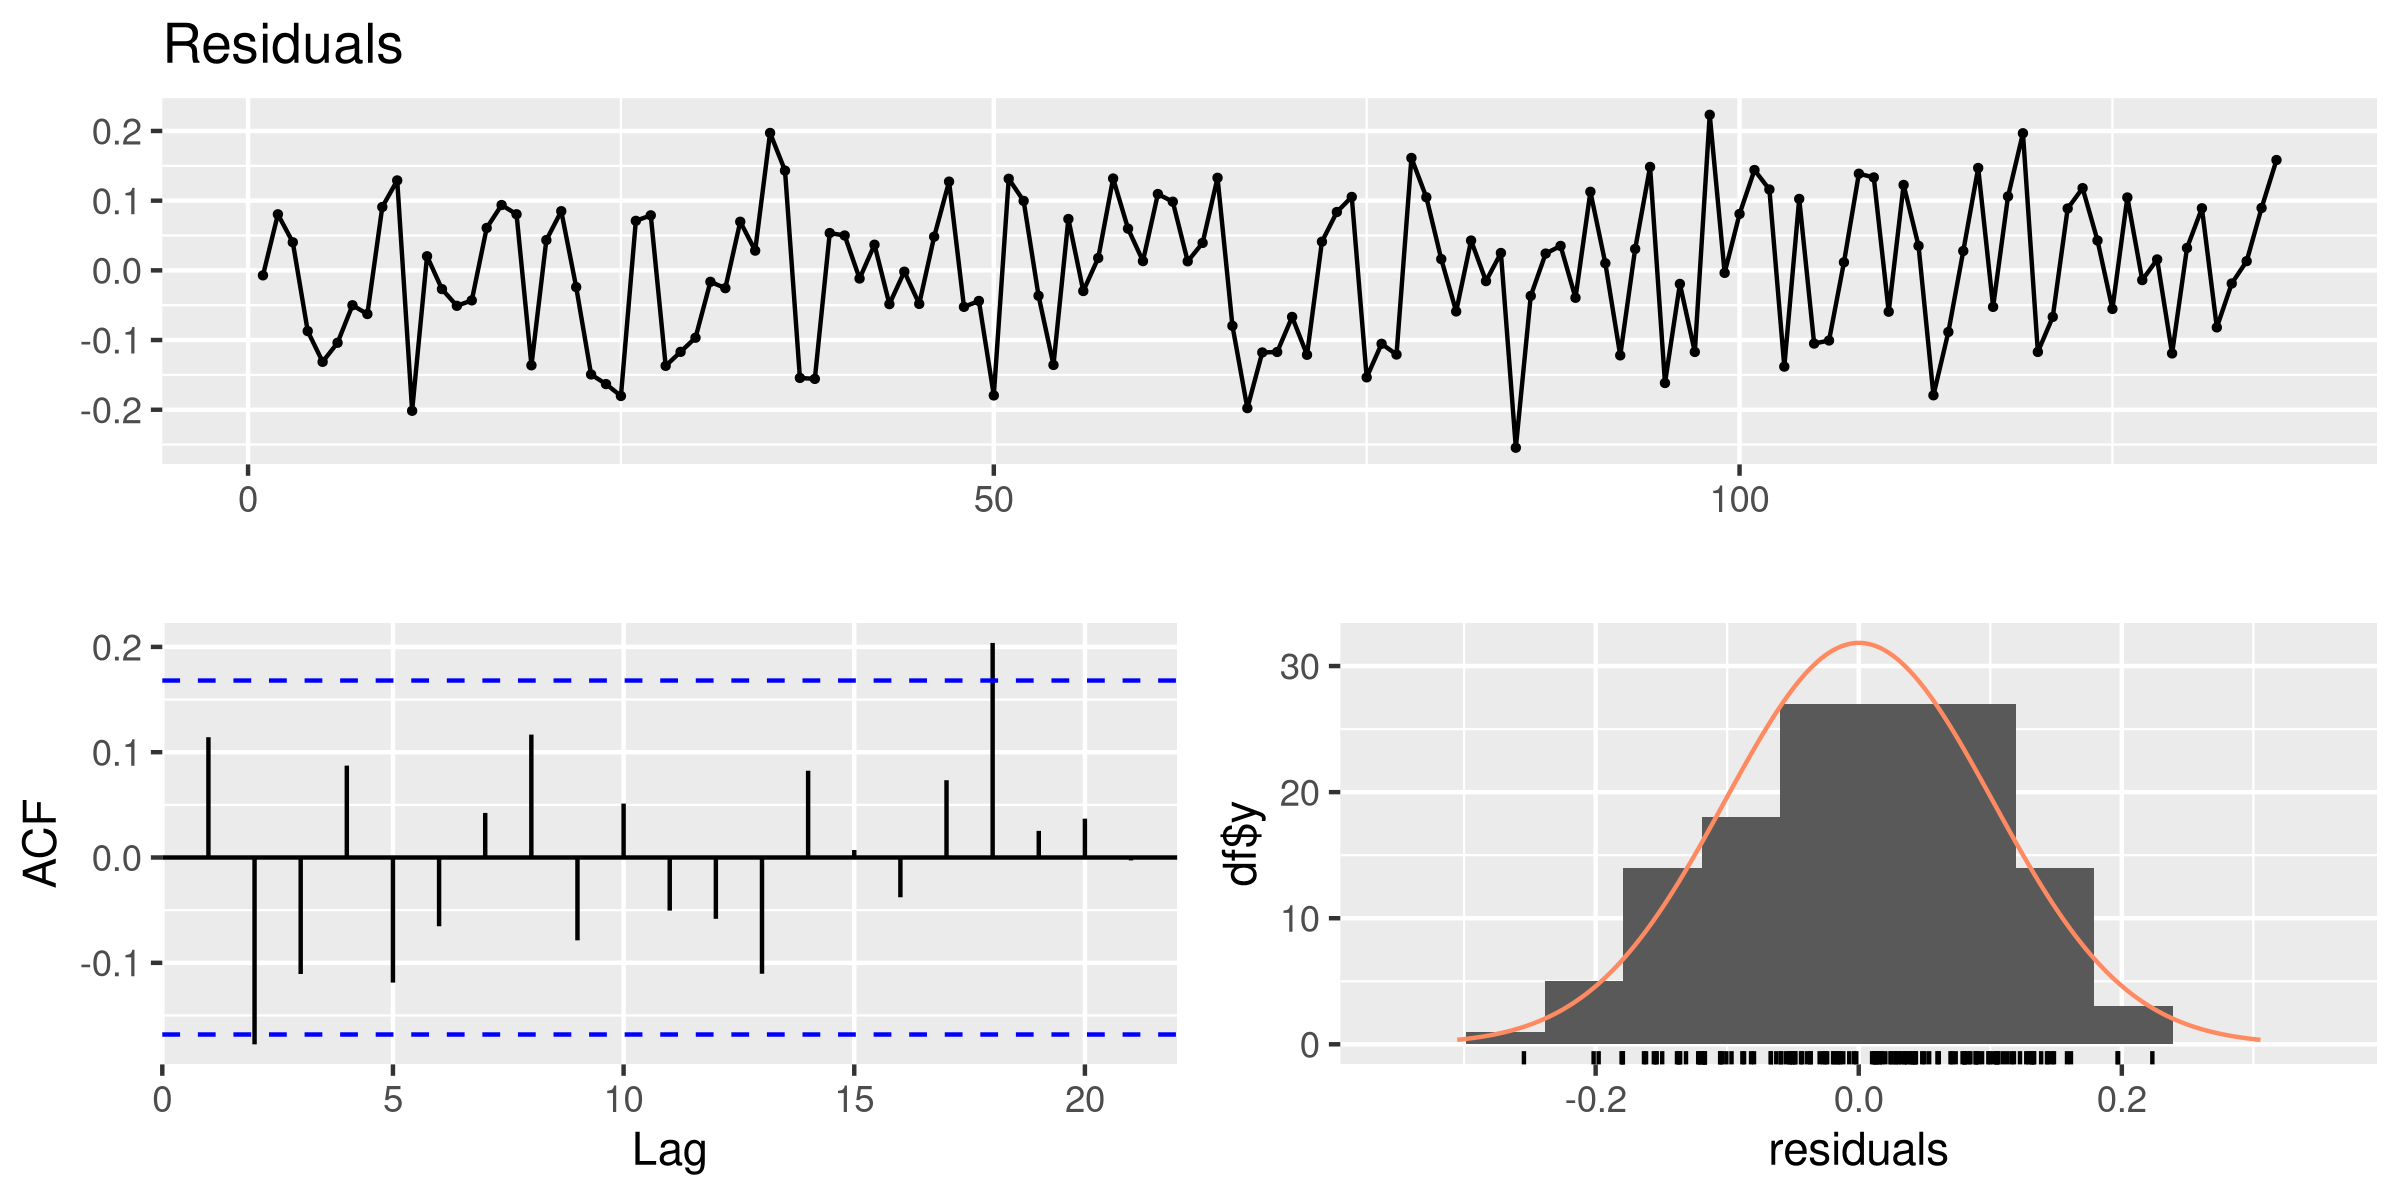

In [26]:
residuos = as.numeric(ks_temp$innov)
print(paste("RMSE: ",sd(residuos)))
checkresiduals(residuos)

### Observaciones

* El ajuste realizado es bueno. Las innovaciones quedan blancas y gaussianas.
* El ajuste de $\delta$ apenas modificó el valor, y el intervalo de confianza contiene al $0$ por lo que no hay evidencia suficiente de tendencia creciente!!

In [27]:
print(paste("Delta estimado: ", delta_est))
print(paste("Desvío estimación: ", estimation_error[3]))
print(paste("Int. de confianza para delta: ", delta_est-2*estimation_error[3], delta_est+2*estimation_error[3]))

[1] "Delta estimado:  0.0072076552584884"
[1] "Desvío estimación:  0.00431816679402631"
[1] "Int. de confianza para delta:  -0.00142867832956422 0.015843988846541"


Podríamos probar correr nuevamente el ajuste forzando el $\delta=0$ a ver si los residuos quedan similares.

### Ejemplo: calentamiento global, segunda versión

Como el $\delta$ no nos quedó significativo, lo sacamos del modelo. Sin embargo, puede ser que $\phi$ no fuera $1$ y en realidad hubiera un crecimiento multiplicativo. Probemos esta nueva hipótesis ajustando:


   $$\begin{cases} x_{t+1} = \phi x_t + w_t, \\ y_{t} = x_t + v_t, \end{cases}$$
   
Corresponde al modelo anterior con:

 * $a=1$, $\phi$ desconocido.
 * Sin entrada, $b=c=0$.
 * $\sigma_w$ y $\sigma_v$ desconocidos.

### Estimación por máxima verosimilitud.

Podemos hacer el mismo algoritmo que antes, esta vez usando `Kfilter` sin entrada y dejando libre $\phi$.

In [28]:
# Función que evalúa la verosimilitud para los parámetros libres
#Parámetros (guardados en el vector para):
# sigma_w, ruido de estado
# sigma_v, ruido de observación
# phi, valor que multiplica al estado
# Dados los parámetros, se usa Kfilter para aplicar filtro de Kalman y se computa la verosimilitud.
# Para la condición inicial se usan los primeros valores de y
mu0 = mean(head(globtemp),3)
Sigma0 = var(head(globtemp,12)) #en sigma0 va la varianza ojo

LikelihoodFunction = function(para){
    sigma_w = para[1]
    sigma_v = para[2] 
    phi = para[3]
    #Ups es el nombre que Kfilter le da a b (Matriz Upsilon, muy feo el nombre)
    kf = Kfilter(globtemp,Phi=phi,A=1,mu0,Sigma0,sQ=sigma_w,sR=sigma_v)
    return(kf$like) 
 }

In [29]:
# Ajuste por maxima verosimilitud:

#Construyo una estimación inicial de mis parámetros ajustar.
#Para phi, tomamos 1, el valor del modelo anterior
phi_ini=1
init.par = c(0.1*sd(globtemp),sd(globtemp),phi_ini)


#Llamo al optimizador de R usando el método de gradiente mejorado BFGS y guardo la estimación
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1))

#Las derivadas segundas de la estimación me dan info del error de ajuste (significación).
estimation_error = sqrt(diag(solve(est$hessian)));

initial  value -137.308761 
iter  10 value -241.452625
final  value -241.884790 
converged


In [30]:
# Asigno los parametros finales de la optimizacion
sigma_w_est = abs(est$par[1])  #el abs es por si le da la solución negativa
sigma_v_est = abs(est$par[2])
phi_est = est$par[3]

print(paste("Valor inicial de sigma_w: ", init.par[1]))
print(paste("Valor inicial de sigma_v: ", init.par[2]))
print(paste("Valor inicial de phi: ", init.par[3]))

print(paste("Valor estimado de sigma_w: ", sigma_w_est))
print(paste("Valor estimado de sigma_v: ", sigma_v_est))
print(paste("Valor estimado de phi: ", phi_est))

print(paste("Int. de confianza para sigma_w: ", sigma_w_est-2*estimation_error[1], sigma_w_est+2*estimation_error[1]))
print(paste("Int. de confianza para sigma_v: ", sigma_v_est-2*estimation_error[2], sigma_v_est+2*estimation_error[2]))
print(paste("Int. de confianza para phi: ", phi_est-2*estimation_error[3], phi_est+2*estimation_error[3]))

[1] "Valor inicial de sigma_w:  0.0317338983582366"
[1] "Valor inicial de sigma_v:  0.317338983582366"
[1] "Valor inicial de phi:  1"
[1] "Valor estimado de sigma_w:  0.052393151512224"
[1] "Valor estimado de sigma_v:  0.0712805053037677"
[1] "Valor estimado de phi:  1.00898970124614"
[1] "Int. de confianza para sigma_w:  0.0303359982279325 0.0744503047965155"
[1] "Int. de confianza para sigma_v:  0.0542202724011669 0.0883407382063684"
[1] "Int. de confianza para phi:  0.976748695700979 1.0412307067913"


### Resultado del ajuste

Finalmente, con los valores ajustados podemos estimar la tendencia y chequear residuos:

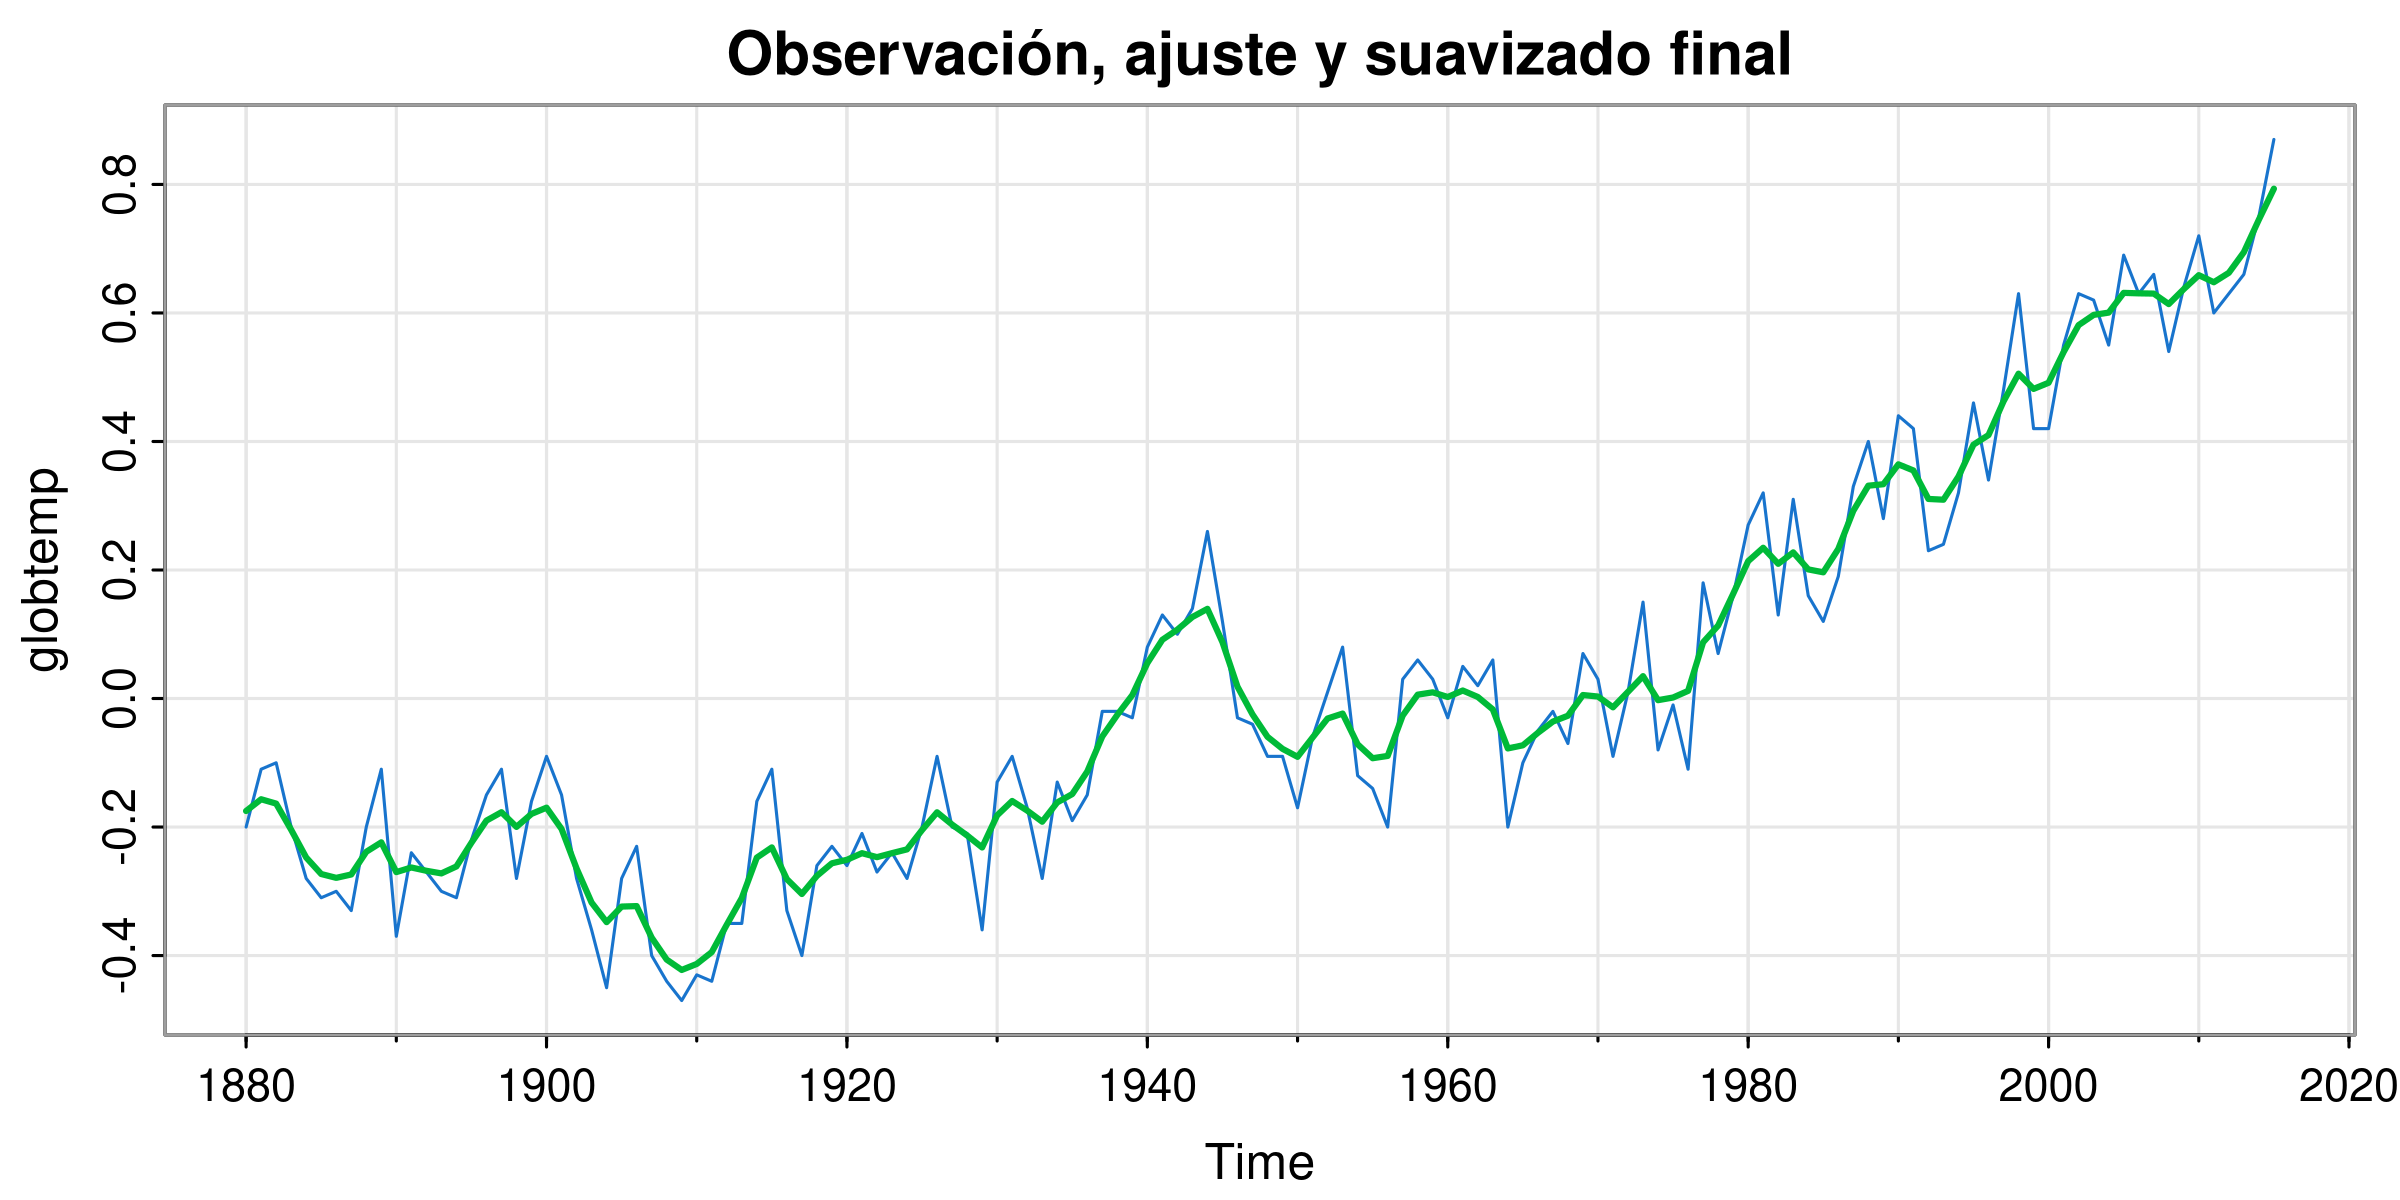

In [31]:
ks_temp = Ksmooth(globtemp,Phi=phi_est,A=1,mu0,Sigma0,sQ=sigma_w_est,sR=sigma_v_est)
gtemp_smooth = ts(as.numeric(ks_temp$Xs), start=1880) #construyo la serie temporal
tsplot(globtemp, col=4, main="Observación, ajuste y suavizado final")
lines(gtemp_smooth, lwd=2,col=3)

[1] "RMSE:  0.101659651759367"

	Ljung-Box test

data:  Residuals
Q* = 16.44, df = 10, p-value = 0.08772

Model df: 0.   Total lags used: 10



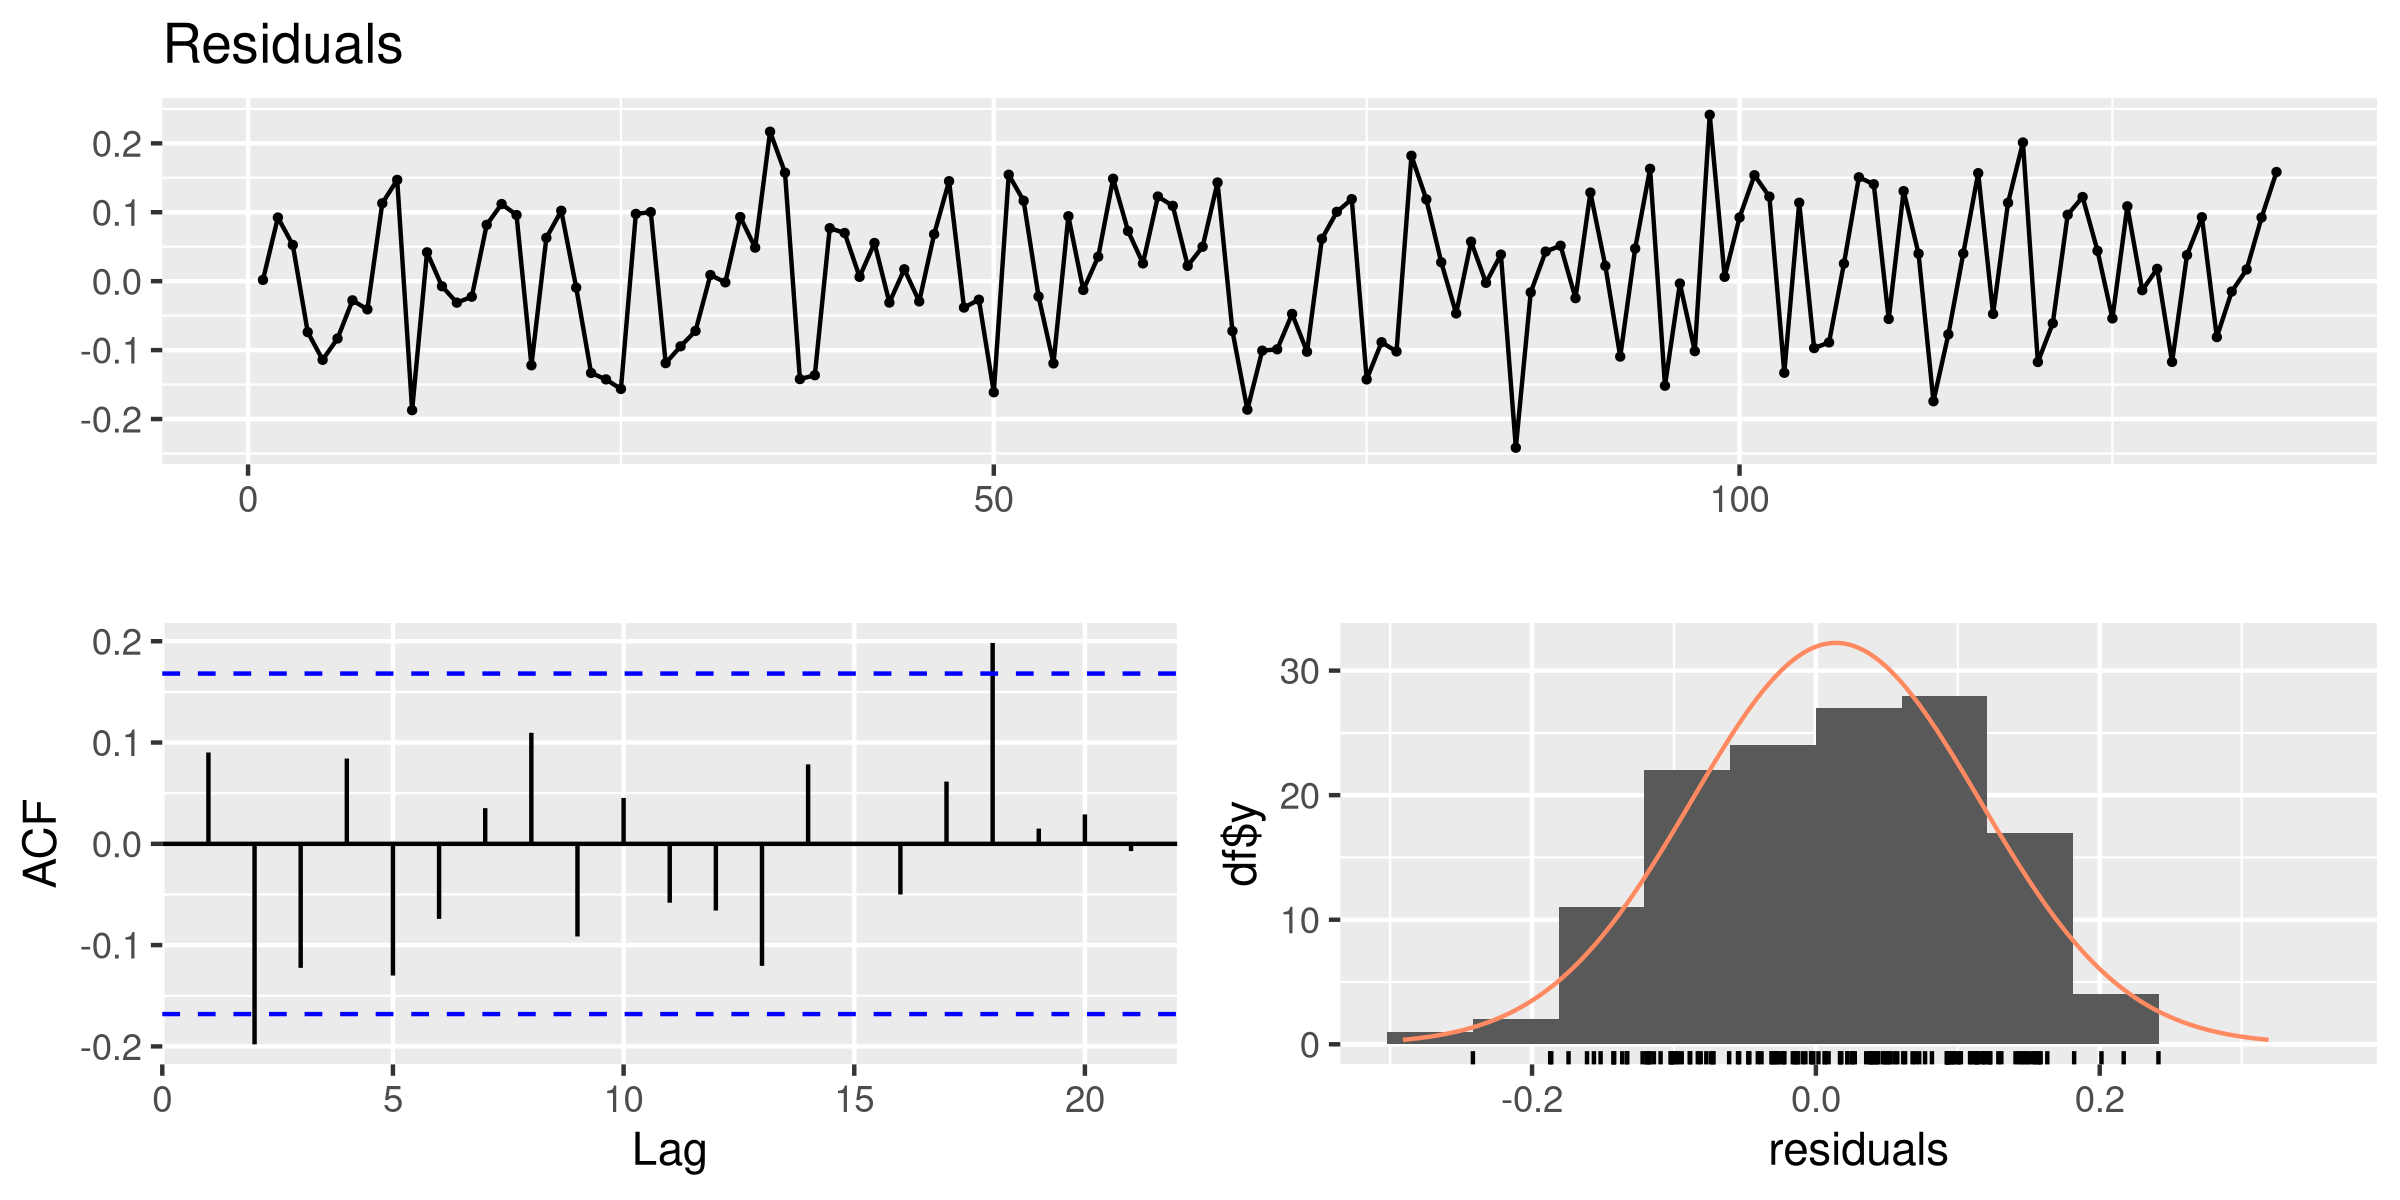

In [32]:
residuos = as.numeric(ks_temp$innov)
print(paste("RMSE: ",sd(residuos)))
checkresiduals(residuos)

### Observaciones

* El ajuste realizado es bueno, pero peor que el anterior. Las innovaciones quedan blancas y gaussianas pero el p-valor de Ljung-box empeora.
* El RMSE del residuo no mejora demasiado.
* El ajuste de $\phi$ apenas modificó el valor, y el intervalo de confianza contiene al $1$ por lo que no hay evidencia suficiente de que haya efecto multiplicativo!!!

In [33]:
print(paste("Phi estimado: ", phi_est))
print(paste("Desvío estimación: ", estimation_error[3]))
print(paste("Int. de confianza para delta: ", phi_est-2*estimation_error[3], phi_est+2*estimation_error[3]))

[1] "Phi estimado:  1.00898970124614"
[1] "Desvío estimación:  0.0161205027725795"
[1] "Int. de confianza para delta:  0.976748695700979 1.0412307067913"


**Disclaimer:** No estoy negando (ni afirmando) el calentamiento global! No todavía...

## Modelo lineal dinámico: el caso de múltiples estados.

La generalización completa del modelo lineal dinámico es considerar que podemos tener *múltiples estados* y *múltiples observaciones* ocurriendo en paralelo. Esto sirve en particular para modelar problemas físicos, donde la evolución del estado sigue una dinámica conocida.

> **Modelo Lineal Dinámico General:**
>
> $$ x_{t+1} = \Phi x_t + Bu_t + w_t.$$
>
> $$ y_t = A x_t + Cu_t + v_t,$$

* Aquí $x_t$ es un vector de tamaño $p$ con los estados, e $y_t$ un vector de tamaño $q$ con las observaciones.

* Por lo tanto $\Phi$ es una matriz de $p\times p$ que indica cómo calcular el estado siguiente a partir de los anteriores, y $A$ una matriz de $p\times q$ que indica cómo se calculan las observaciones.

* $u_t$ es una entrada vectorial de tamaño $r$ y $B$ (de $p\times r$) y $C$ (de $q\times r$) son matrices que dicen cómo afectan al estado y a la observación.

* Por último, $w_t$ y $v_t$ son ruidos blancos *vectoriales* de tamaños $p$ y $q$, con matriz de covarianzas $Q$ y $R$ cada uno.

### Reconstrucción del estado

Para reconstruir los estados $\{x_t\}$ a partir de las observaciones $\{y_t\}$ se plantean los mismos problemas que antes. Todas las técnicas vistas anteriormente funcionan, pero utilizando la versión *matricial* del filtro de Kalman que describimos a continuación.

**Notación:** denotemos por

 * $x_t^t = E[x_t \mid y^t]$, el vector estimación actual del estado.
 * $P_t^t = E[(x_t - x_t^t)(x_t-x_t^t)^T]$ la matriz de covarianzas de error (ahora es matricial, porque influencia cruzada de errores).

### Filtro de Kalman, versión matricial.

Dado un modelo en espacio de estados como los anteriores, con condición inicial $N(\mu_0,\Sigma_0)$ realizamos la siguiente iteración.

1. Se fija $x_0^0 = \mu_0$ y $P_0^0 = \Sigma_0$ es decir la estimación inicial corresponde a la condición inicial.

2. Se actualiza la predicción del estado siguiente usando la info hasta $t-1$ y su error:

    $$ x_t^{t-1} = \Phi x_{t-1}^{t-1} + B u_t, $$
    
    $$ P_{t}^{t-1} = \Phi P_{t-1}^{t-1} \Phi^T + Q.$$
    
3. Considero la nueva información $y_t$ y *corrijo la estimación*:

    $$ x_t^t = x_t^{t-1} + K_t (y_t - Ax_t^{t-1} - Cu_t), $$
    
    $$ P_{t}^{t} = [Id-K_tA] P_{t}^{t-1}.$$

    siendo $K_t = P_t^{t-1} A^T[AP_{t}^{t-1} A^T + R]^{-1}$ la *ganancia de Kalman*.
    
4. Si tengo $n$ muestras, itero 2 y 3 hasta $n$ la cantidad de muestras. Si continúo el paso 2 para $t>n$ construyo las predicciones.

### Suavizador de Kalman, versión matricial.

Para un modelo en espacio de estados matricial y un conjunto de observaciones $\{y_1,\ldots,y_n\} = y^n$:

1. Se corre el filtro de Kalman hasta hallar $x^n_n$ y $P_n^n$.
2. Se itera $t=n,n-1,\ldots,1$ corrigiendo la estimación de Kalman usando la información del futuro:
 
 $$ x^n_{t} = x_{t}^{t} + J_{t}(x^n_{t+1} - x_{t+1}^{t}),$$
 
 $$ P^n_{t} = P^{t}_{t} + J_{t}\left(P^{t+1}_n − P_{t+1}^{t}\right) J_{t}^T.$$ 

siendo:
$$ J_{t} = P_{t}^{t} \Phi^T (P_{t+1}^{t})^{-1}.$$


### Ajuste de un modelo lineal dinámico general.

Nuevamente, en las hipótesis del modelo, las *innovaciones* que surgen de la recursión:

$$\epsilon_t = y_t − E[y_t \mid y^{t-1}] = y_t − Ax_t^{t−1} − Cu_t,$$

son una secuencia de vectores Gaussianos de media $0$ y varianza

$$\Sigma_t = AP^{t-1}_t A^T + R.$$

Por lo que nuevamente podemos calcular la verosimilitud (de hecho `Kfilter` ya la devuelve también en este caso) y por lo tanto, realizar un ajuste de máxima verosimilitud.

### Ejemplo, calentamiento global con dos mediciones

La biblioteca `astsa` también proporciona medidas de temperatura basadas en tierra (`gtemp_land`) y océanos (`gtemp_ocean`):

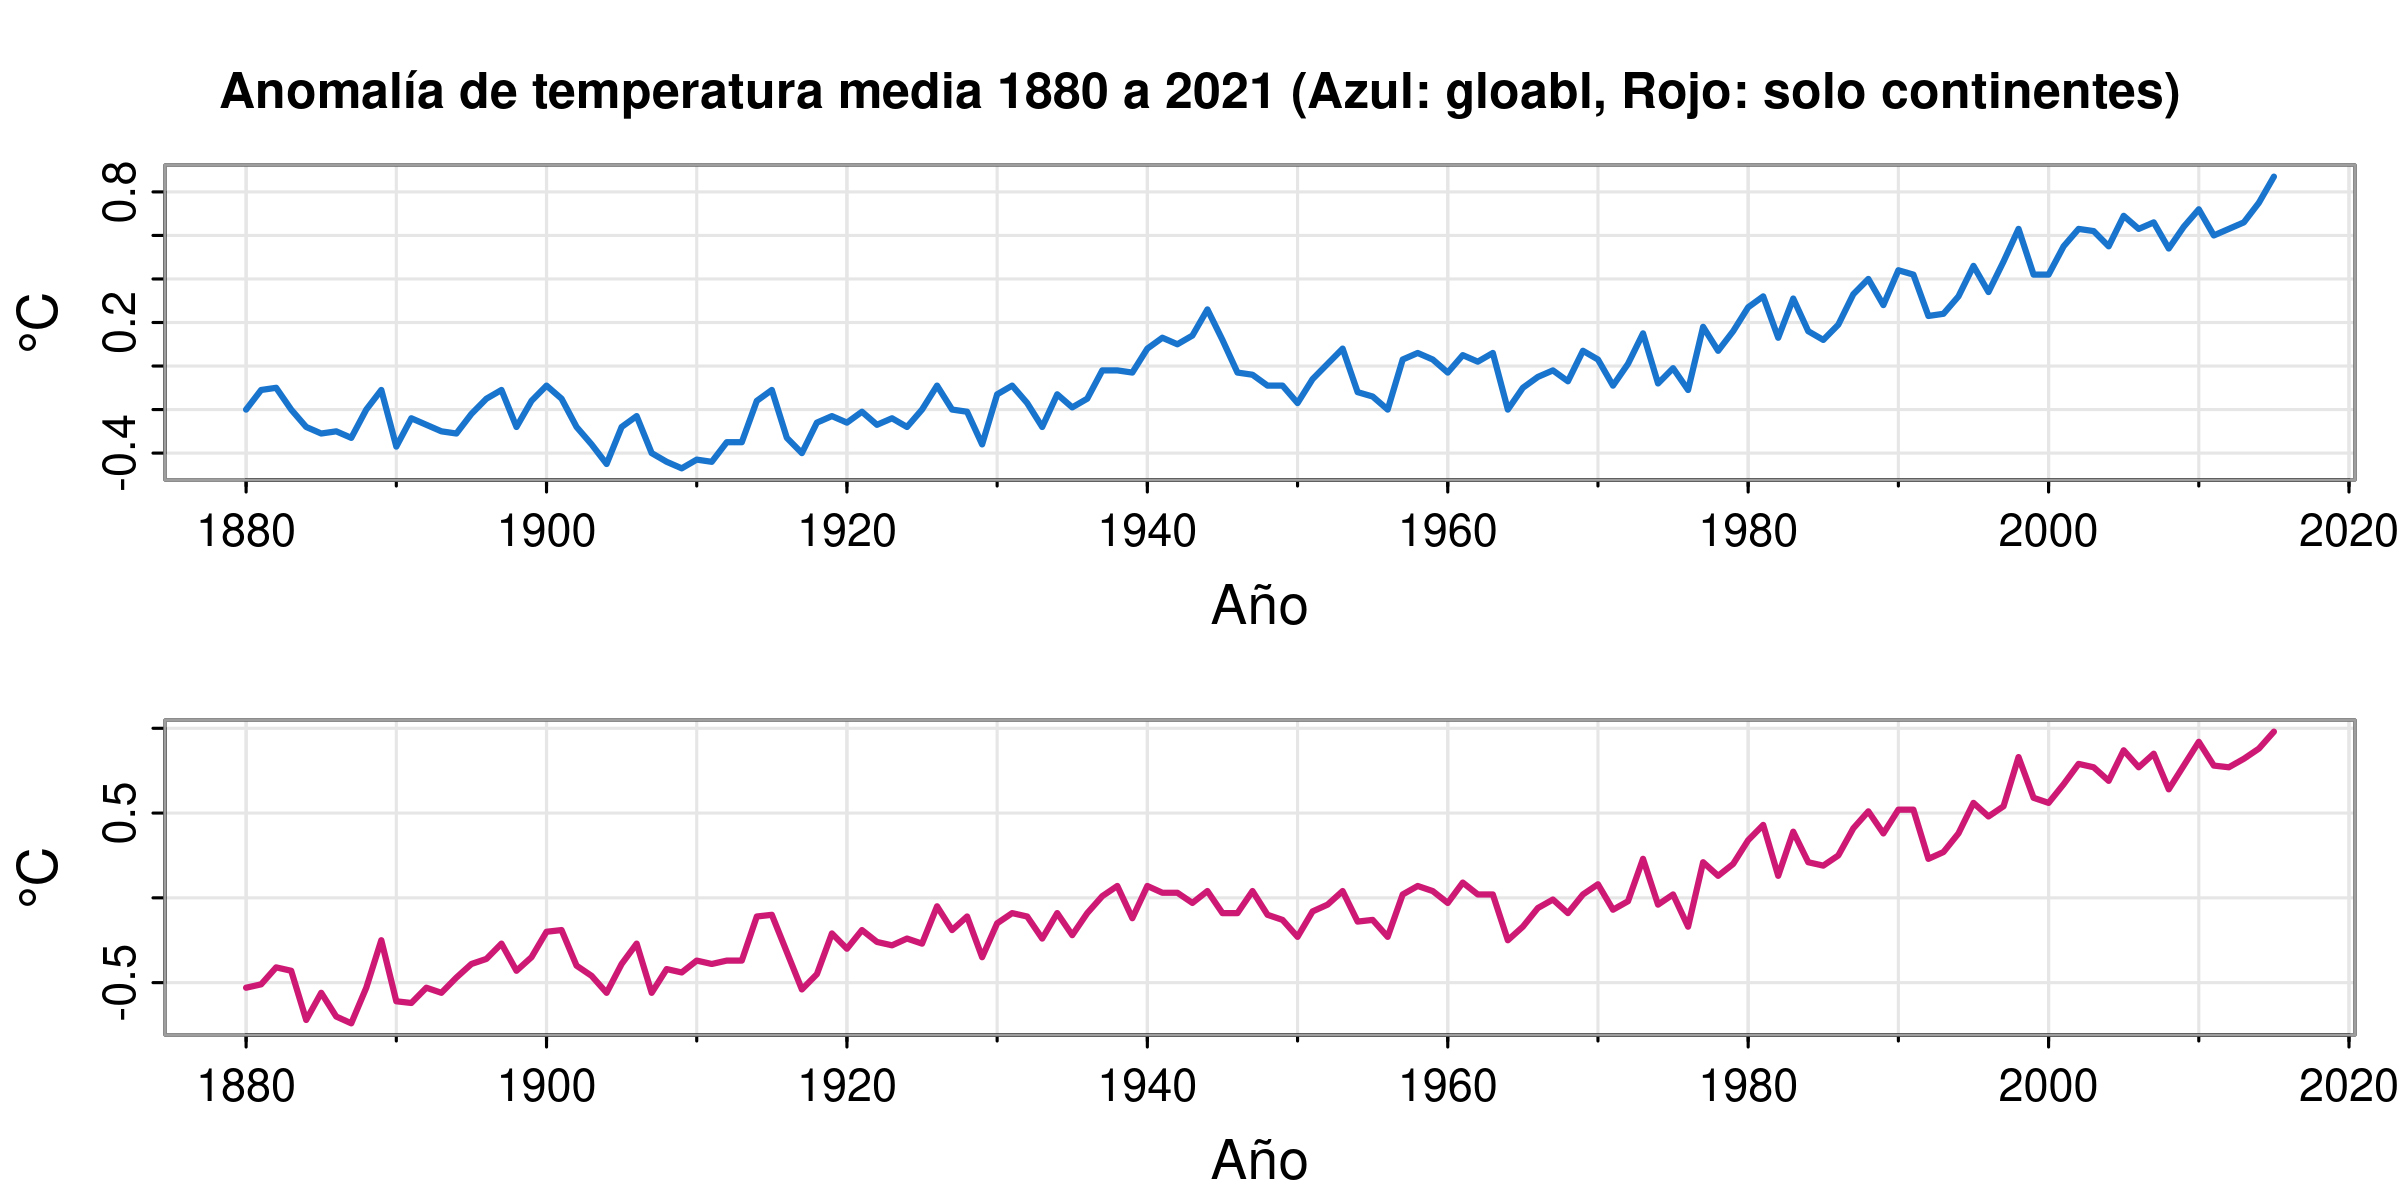

In [34]:
y = cbind(globtemp, globtempl) #junto ambas series
tsplot(y, col=c(4,6), lw=2, 
       main="Anomalía de temperatura media 1880 a 2021 (Azul: gloabl, Rojo: solo continentes)", xlab="Año", ylab="°C")

### Modelo

Planteamos un modelo como lo anteriores donde las observaciones $y_t$ tienen dimensión $2$, correspondiendo a las dos medidas, con ruidos independientes cada una, pero que surgen del mismo estado $x_t$, la temperatura a hallar.

$$\begin{cases} x_{t+1} = \phi x_t + \delta + w_t, \\ y_1^1 = x_t + v_{1,t}, \\ y_t^2 = x_t + v_{2,t}.\end{cases}$$

**Parámetros:**

 * La matriz $\Phi= [\phi]$ (de $1\times 1$ en este caso porque el estado sigue siendo escalar).
 * $B=[\delta]$, $C=[0]$, entrada $u_t$ constante, también escalares.
 * La ecuación de observación se escribe en forma matricial como:
 
     $$y_t=\begin{pmatrix}1 \\ 1\end{pmatrix}x_t + \begin{pmatrix}v_{1,t} \\ v_{2,t}\end{pmatrix}.\\ $$
 
 * El ruido de estado tiene varianza $\sigma_w^2$ y el vector de ruidos $v=(v_1,v_2)$ tiene una matriz de covarianzas $R$ a estimar.

### Estimación por máxima verosimilitud.

Aplicamos la misma idea, pero usando `Kfilter` en formato vectorial.

In [35]:
# Función que evalúa la verosimilitud para los parámetros libres
#Parámetros (guardados en el vector para):
# sigma_w, ruido de estado
# sigma_v11,sigma_v12,sigma_v22, parámetros del ruido de observación
# phi, valor que multiplica al estado
# delta, tendencia de entrada.
# Dados los parámetros, se usa Kfilter para aplicar filtro de Kalman y se computa la verosimilitud.
# Para la condición inicial se usan los primeros valores de y
mu0 = mean(head(globtemp),3) #uso gtemp_land para inicializar. Se puede cambiar
Sigma0 = var(head(globtemp,12)) #en sigma0 va la varianza

LikelihoodFunction = function(para){
    sigma_w = para[1]
    sigma_v11 = para[2] 
    sigma_v12 = para[3]
    sigma_v22 = para[4]
    phi = para[5]
    delta = para[6]
    R = matrix(c(sigma_v11^2,sigma_v12,sigma_v12,sigma_v22^2),nrow=2)
    sR = R%^%0.5
    #Ups es el nombre que Kfilter le da a b (Matriz Upsilon, muy feo el nombre)
    kf = Kfilter(y,A=c(1,1),mu0=mu0,Sigma0=Sigma0,Phi=phi,sQ=sigma_w,sR=sR,Ups=delta, input=1)
    return(kf$like) 
 }

In [36]:
# Ajuste por maxima verosimilitud:

#Construyo una estimación inicial de mis parámetros ajustar.
#Para phi y delta tomamos los del modelo anterior
init.par = c(0.1*sd(globtemp),sd(globtemp),0,sd(globtemp),phi_ini,delta_ini)

#Llamo al optimizador de R usando el método de gradiente mejorado BFGS y guardo la estimación
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1))

#Las derivadas segundas de la estimación me dan info del error de ajuste (significación).
estimation_error = sqrt(diag(solve(est$hessian)));

initial  value -278.490949 
iter  10 value -416.784709
iter  20 value -444.909329
final  value -444.968684 
converged


In [38]:
# Asigno los parametros finales de la optimizacion
sigma_w_est = abs(est$par[1])  #el abs es por si le da la solución negativa
sigma_v11_est = abs(est$par[2])
sigma_v12_est = abs(est$par[3])
sigma_v22_est = abs(est$par[4])
phi_est = est$par[5]
delta_est = est$par[6]

print(paste("Valor inicial de sigma_w: ", init.par[1]))
print(paste("Valor inicial de sigma_v11: ", init.par[2]))
print(paste("Valor inicial de sigma_v12: ", init.par[3]))
print(paste("Valor inicial de sigma_v22: ", init.par[4]))
print(paste("Valor inicial de phi: ", init.par[5]))
print(paste("Valor inicial de delta: ", init.par[6]))

print(paste("Valor estimado de sigma_w: ", sigma_w_est))
print(paste("Valor estimado de sigma_v11: ", sigma_v11_est))
print(paste("Valor estimado de sigma_v22: ", sigma_v22_est))
print(paste("Valor estimado de sigma_v12: ", sigma_v12_est))
print(paste("Valor estimado de phi: ", phi_est))
print(paste("Valor estimado de delta: ", delta_est))

print(paste("Int. de confianza para phi: ", phi_est-2*estimation_error[5], phi_est+2*estimation_error[5]))
print(paste("Int. de confianza para delta: ", delta_est-2*estimation_error[6], delta_est+2*estimation_error[6]))

[1] "Valor inicial de sigma_w:  0.0317338983582366"
[1] "Valor inicial de sigma_v11:  0.317338983582366"
[1] "Valor inicial de sigma_v12:  0"
[1] "Valor inicial de sigma_v22:  0.317338983582366"
[1] "Valor inicial de phi:  1"
[1] "Valor inicial de delta:  0.00786764705882353"
[1] "Valor estimado de sigma_w:  0.0499020549084424"
[1] "Valor estimado de sigma_v11:  0.0735349344548048"
[1] "Valor estimado de sigma_v22:  0.171171447775441"
[1] "Valor estimado de sigma_v12:  0.00788044095767142"
[1] "Valor estimado de phi:  1.01026448459363"
[1] "Valor estimado de delta:  0.00682869646930187"
[1] "Int. de confianza para phi:  0.977991715721324 1.04253725346594"
[1] "Int. de confianza para delta:  -0.00183068447782905 0.0154880774164328"


### Resultado del ajuste

Finalmente, con los valores ajustados podemos estimar la tendencia y chequear residuos:

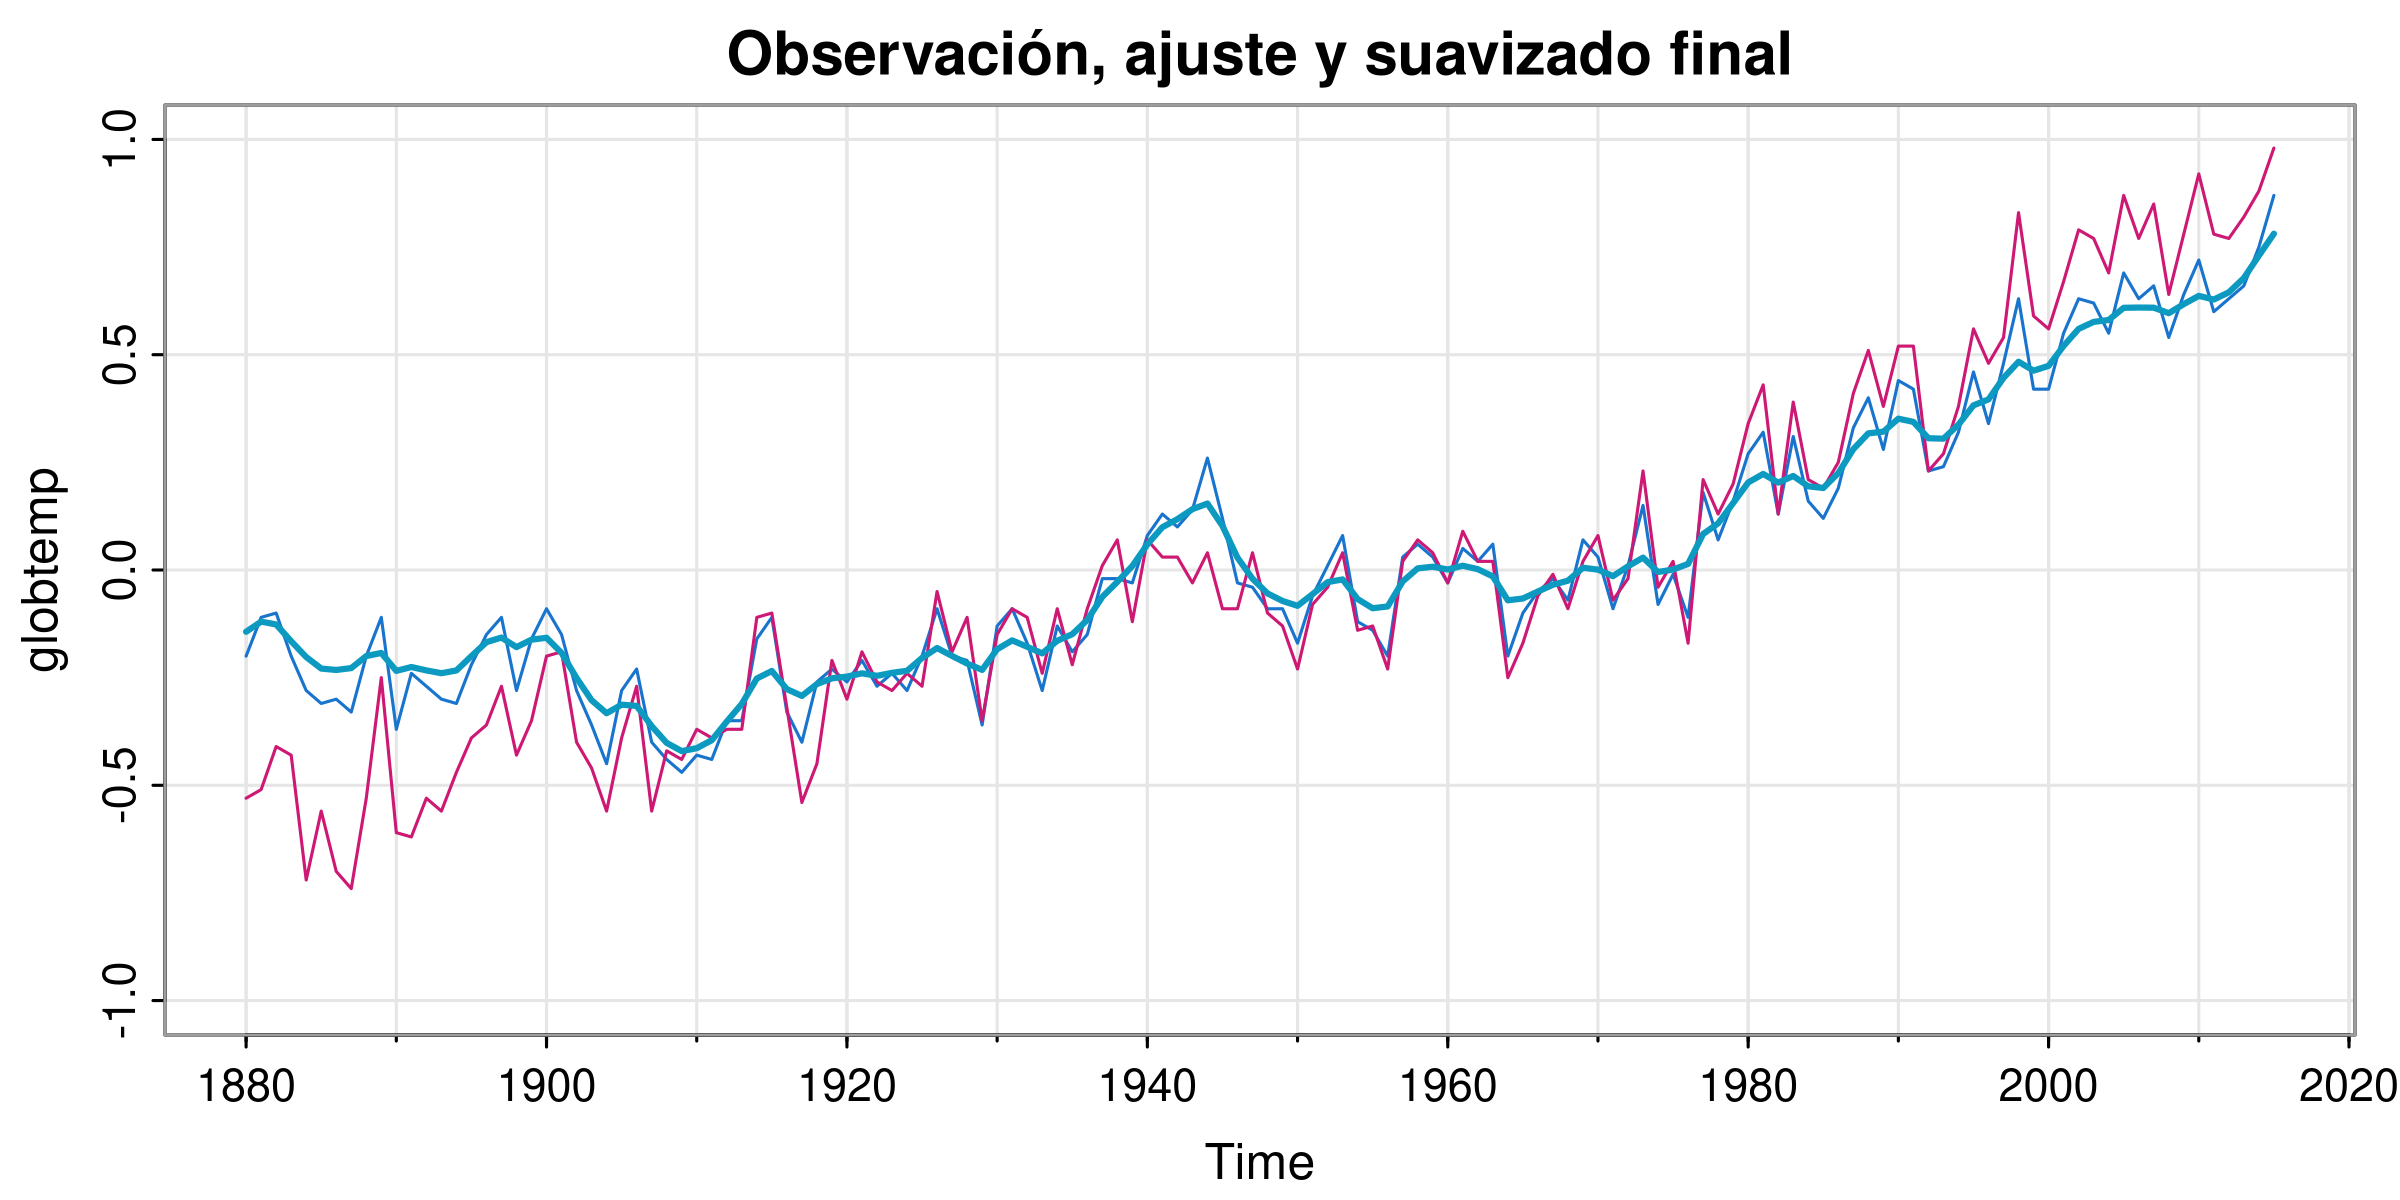

In [39]:
R = matrix(c(sigma_v11_est^2,sigma_v12_est,sigma_v12_est,sigma_v22_est^2),nrow=2)
sR = R%^%0.5
ks_temp = Ksmooth(y,A=c(1,1),mu0=mu0,Sigma0=Sigma0,Phi=phi_est,sQ=sigma_w_est,sR=sR,Ups=delta_est, input=1)

gtemp_smooth = ts(as.numeric(ks_temp$Xs), start=1880) #construyo la serie temporal

tsplot(globtemp, col=4, lwd=1, main="Observación, ajuste y suavizado final", ylim=c(-1,1))
lines(globtempl, lwd=1,col=6)
lines(gtemp_smooth, lwd=2,col=5)

### Otros ejemplos:

* Stochastic volatility.
* Tracking de vehiculos por GPS.
* Larga lista de etc.

### Bibliotecas relacionadas:

* La biblioteca `astsa` incluye las funciones `Kfilter` y `Ksmooth` ya vistas.
* La biblioteca `dlm` permite trabajar con modelos lineales dinámicos aplicando todo lo anterior (pero sin entradas $u_t$). Ya tiene implementados los ajustes por maxima verosimilitud en casos particulares como el local level model.

## Ejercicio

Considere la serie trimestral de desempleo que se da más abajo.

1. Pruebe primero ajustar un modelo estructural del tipo local level, como el visto más arriba.
2. Se intenta mejorar el modelo anterior suponiendo que el desempleo observado verifica:

$$y_t = T_t + S_t + v_t$$

siendo $v_t$ el ruido de observación (de varianza $\sigma_v^2$ desconocida). Supondremos además que $T_t$ la tendencia sigue un local-level model.

$$T_t = T_{t-1} + w_{1t}$$

Pero se agrega la componente estacional $S_t$ que verifica:

$$S_t+S_{t-1}+S_{t-2}+S_{t-3} = w_{2t}$$

que corresponde a decir que la parte estacional suma $0$ en media a lo largo del año.

Escribir este proceso en espacio de estados, y aplicar el método de Newton-Raphson visto arriba para ajustar los valores.

3. Pruebe mejorar el modelo anterior cambiando la ecuación de estado por:

$$T_t = \phi T_{t-1} + w_{1t}$$

con $\phi$ parámetro a determinar.


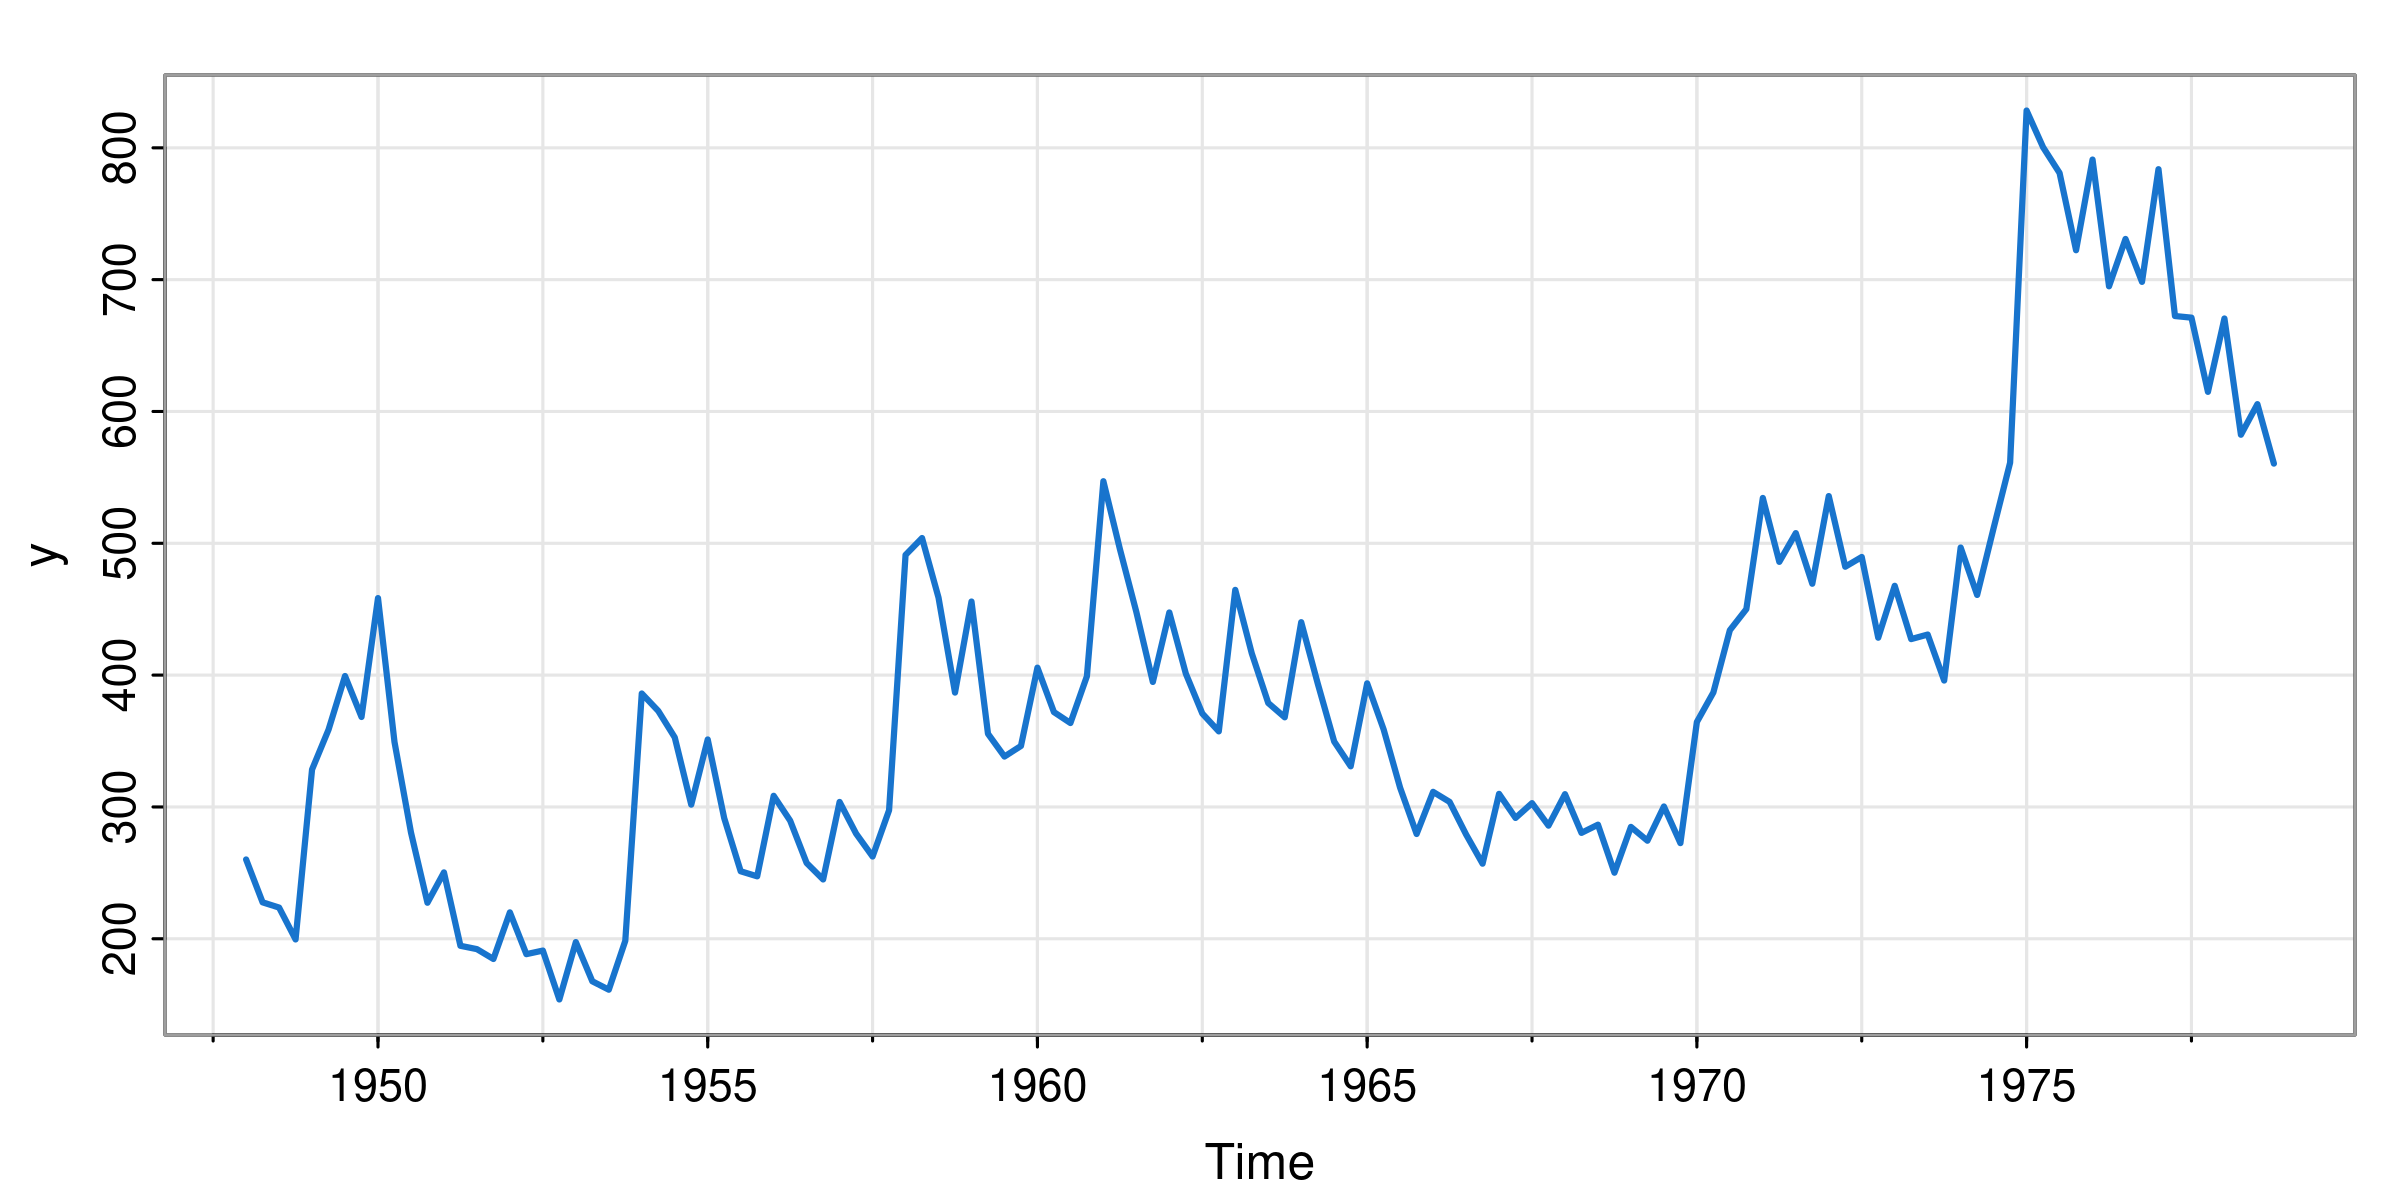

In [40]:
y=aggregate(unemp, nfrequency=4, FUN=mean) #agrego el desempleo promedio de cada trimestre
tsplot(y, col=4, lwd=2)